# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [2]:
from utils import *
from MSVR import MSVR
from experiment_setup import ExpSetup, GroupedAssessor, OptunaStudy

/home/pbsl/pog/proj-mtr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [3]:
DIR = 'heart'

seed = 2609612152#randint(0, 4294967295)
print(seed)

2609612152


In [4]:
setup = ExpSetup(DIR, seed, 0)

Xa_train, Xa_train_norm, Xa_test, Xa_test_norm, ya_train, ya_test, pred_corrls, pred_corrls2, performs = setup.assessorData()

Nº de instâncias: 270
[REGISTERED: DTREE]
[Training]

Accuracy:         0.8404
Recall:           0.9362
Precision:        0.7857
F1:               0.8544
AUROC:            0.9006
AUPR:             0.8810
1-maxProb média:  0.1596
1-maxProb dp:     0.1487

[Testing]

Accuracy:         0.7474
Recall:           0.9459
Precision:        0.6140
F1:               0.7447
AUROC:            0.8022
AUPR:             0.6371
1-maxProb média:  0.1808
1-maxProb dp:     0.1506

[REGISTERED: SGD]
[Training]

Accuracy:         0.8936
Recall:           0.8511
Precision:        0.9302
F1:               0.8889
AUROC:            0.9683
AUPR:             0.9705
1-maxProb média:  0.1189
1-maxProb dp:     0.1282

[Testing]

Accuracy:         0.8105
Recall:           0.8919
Precision:        0.7021
F1:               0.7857
AUROC:            0.8751
AUPR:             0.7655
1-maxProb média:  0.1548
1-maxProb dp:     0.1444

[REGISTERED: LR]
[Training]

Accuracy:         0.8723
Recall:           0.8298
Precision: 

In [5]:
ya_train_copy = ya_train.copy()
ya_test_copy = ya_test.copy()
pred_corrls_copy = pred_corrls.copy()
pred_corrls2_copy = pred_corrls2.copy()

# Assessors

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

In [7]:
groups = {}
model_names = ['svm_linear', 'sgd', 'lr', 'mlp'] # ['dtree', 'xgb', 'knn'] #list(performs.keys())

ya_train = ya_train_copy[model_names]
ya_test = ya_test_copy[model_names]
pred_corrls = pred_corrls_copy.loc[model_names, model_names]
pred_corrls2 = pred_corrls2_copy.loc[model_names, model_names]

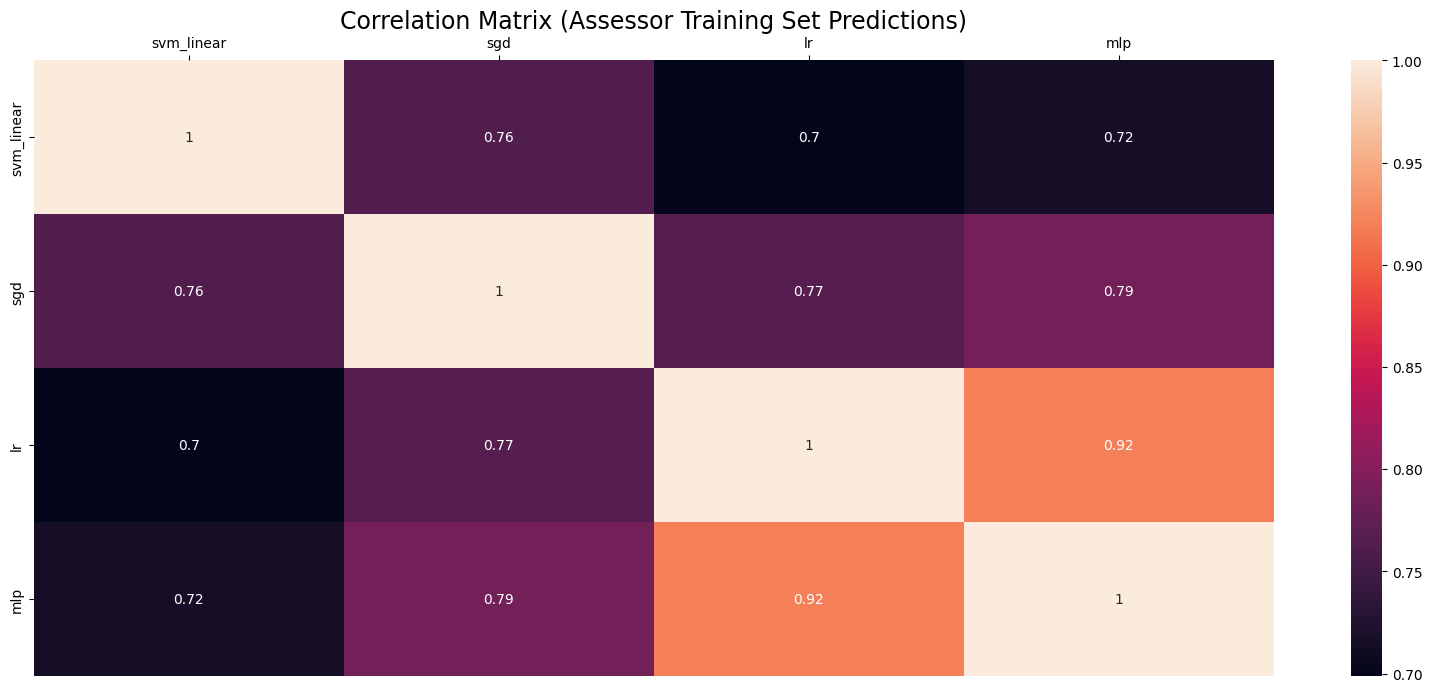

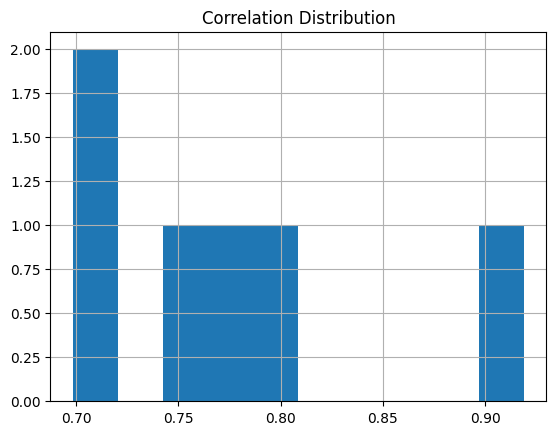

Training correlation distribution:
count    6.000000
mean     0.774617
std      0.078190
min      0.698544
25%      0.726764
50%      0.763718
75%      0.782195
max      0.918925
Name: corr, dtype: float64
[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


In [8]:
correlation_matrix(pred_corrls, True, DIR, 'Assessor', 'Training')

In [9]:
MIN_SCORE = 0.725 #corrls_values['corr'].quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.725


[['sgd', 'svm_linear'], ['sgd', 'lr', 'mlp']]

        Min_score: 0.725
        [['svm_linear', 'sgd'],
        ['xgb'],
        ['svm_poly'],
        ['kan'],
        ['dtree'],
        ['adab'],
        ['rforest'],
        ['gb'],
        ['svm_rbf', 'lr', 'mlp'],
        ['svm_rbf', 'lr', 'knn'],
        ['sgd', 'mlp', 'lr']]

Conjunto de Teste:

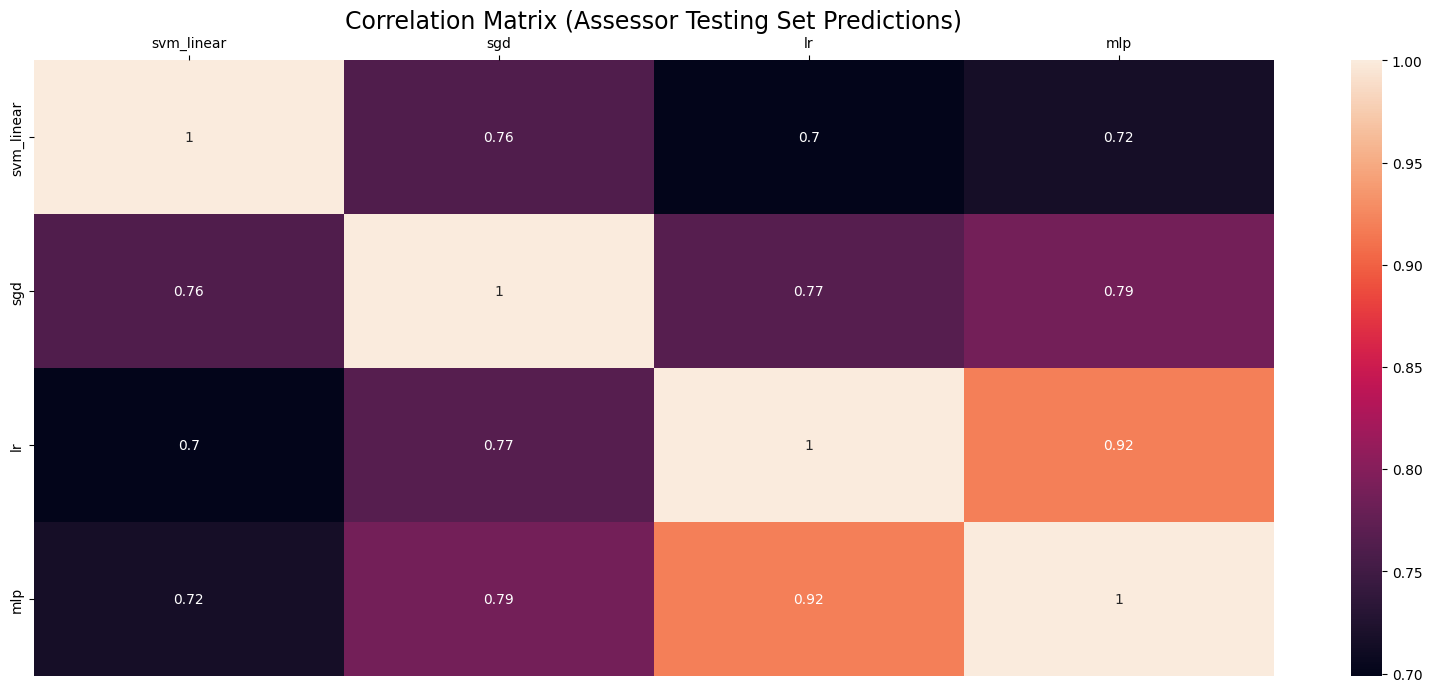

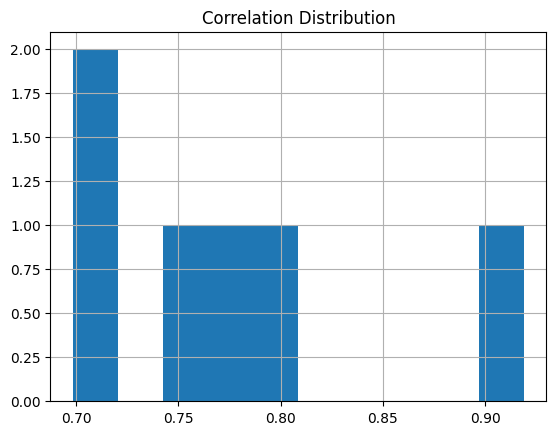

Testing correlation distribution:
count    6.000000
mean     0.774617
std      0.078190
min      0.698544
25%      0.726764
50%      0.763718
75%      0.782195
max      0.918925
Name: corr, dtype: float64
[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [ ]:
correlation_matrix(pred_corrls2, True, DIR, 'Assessor', 'Testing')

In [11]:
groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

[['sgd', 'svm_linear', 'mlp'], ['sgd', 'lr', 'mlp']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE:  0.0006
NMSE: 0.0538
MAE:  0.0163
NMAE: 0.1664
aRRMSE: 0.2153
aCC:  0.9869


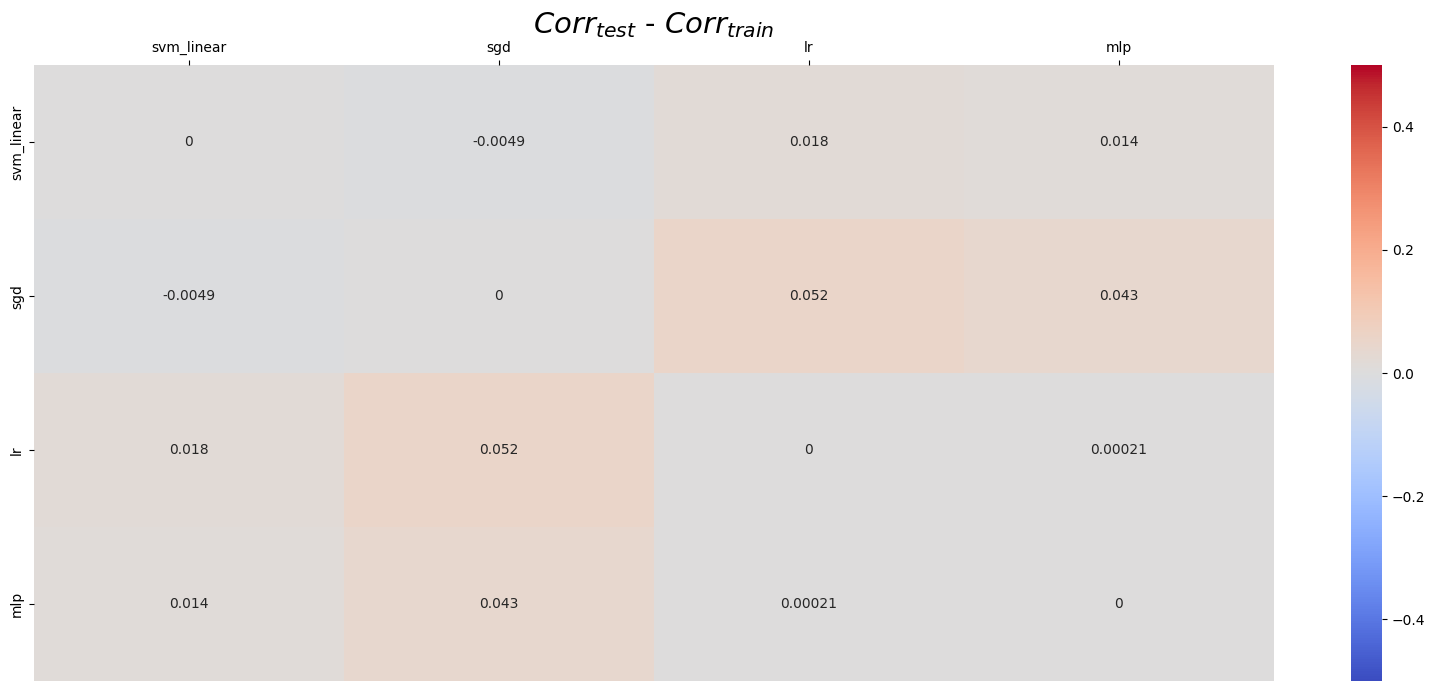

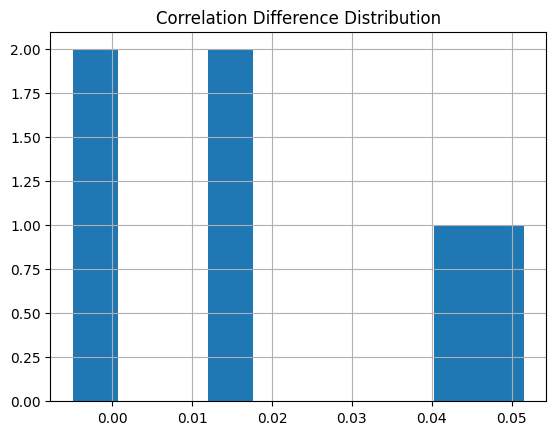

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [12]:
diff_corrls = pred_corrls2-pred_corrls
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(f'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE:  {mse(pred_corrls, pred_corrls2):.4f}
NMSE: {nmse(pred_corrls, pred_corrls2):.4f}
MAE:  {mae(pred_corrls, pred_corrls2):.4f}
NMAE: {nmae(pred_corrls, pred_corrls2):.4f}
aRRMSE: {rrmse(pred_corrls, pred_corrls2):.4f}
aCC:  {corrCoeff(pred_corrls, pred_corrls2):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Globais

In [13]:
parameters = {'max_depth':[None,10,20,30],
                    'criterion':['squared_error', 'poisson', 'friedman_mse'],
                    'min_samples_split':[2,5,10,20,40,60],
                    'min_samples_leaf':[1,2,10,30],
                    'n_estimators':[20,50,100,150]}

In [14]:
# Criando o MultiIndex
multi_index = multIdx('ST','MRT','MRT(g)','M-SVR','M-SVR(g)','RC','RC(g)', subindex=model_names)

metrics_cols = ['MSE', 'MAE', 'NMSE', 'NMAE', 'aRRMSE', 'aCC']
metrics_df = pd.DataFrame(columns=metrics_cols, index=multi_index)
diff_metrics = pd.DataFrame(columns=metrics_cols, index=['ST','MRT','MRT(g)','M-SVR','M-SVR(g)','RC','RC(g)'])

### Regressor Chain
(RC)

In [12]:
#study = OptunaStudy(Xa_train, ya_train, 30, seed)
#
#study.search(RegressorChain, cv=5)
#
#rc_params = study.best_params
#regchain = RegressorChain(RandomForestRegressor(random_state=seed).set_params(**rc_params),
#                          random_state=seed, cv=5, verbose=True).fit(Xa_train, ya_train)

In [15]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), random_state=seed, cv=5,
                          verbose=True, order='random').fit(Xa_train, ya_train)

[Chain] ................... (1 of 4) Processing order 2, total=   0.1s
[Chain] ................... (2 of 4) Processing order 3, total=   0.1s
[Chain] ................... (3 of 4) Processing order 0, total=   0.1s
[Chain] ................... (4 of 4) Processing order 1, total=   0.1s


In [16]:
metrics_df.loc['RC',:] = assr_performance(regchain, Xa_test, ya_test, Xa_train, ya_train)

metrics_df.loc['RC',:]

[TRAINING SET]
MSE: 0.0171
NMSE: 0.2606
MAE: 0.0934
NMAE: 0.4675
aRRMSE: 0.5009
aCC: 0.8997

[TESTING SET]
MSE: 0.0613
NMSE: 1.1096
MAE: 0.1984
NMAE: 1.0334
aRRMSE: 1.0534
aCC: 0.0999


MSE       MAE      NMSE      NMAE    aRRMSE       aCC
Model                                                                 
svm_linear  0.044838  1.113201  0.171553  1.056493  1.055084  0.086545
sgd         0.083711  1.111504  0.238313  1.051391  1.054279   0.06708
lr          0.046417   1.11667  0.171636  1.022398  1.056726  0.119061
mlp           0.0703  1.096962   0.21217  1.003335   1.04736  0.126748

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

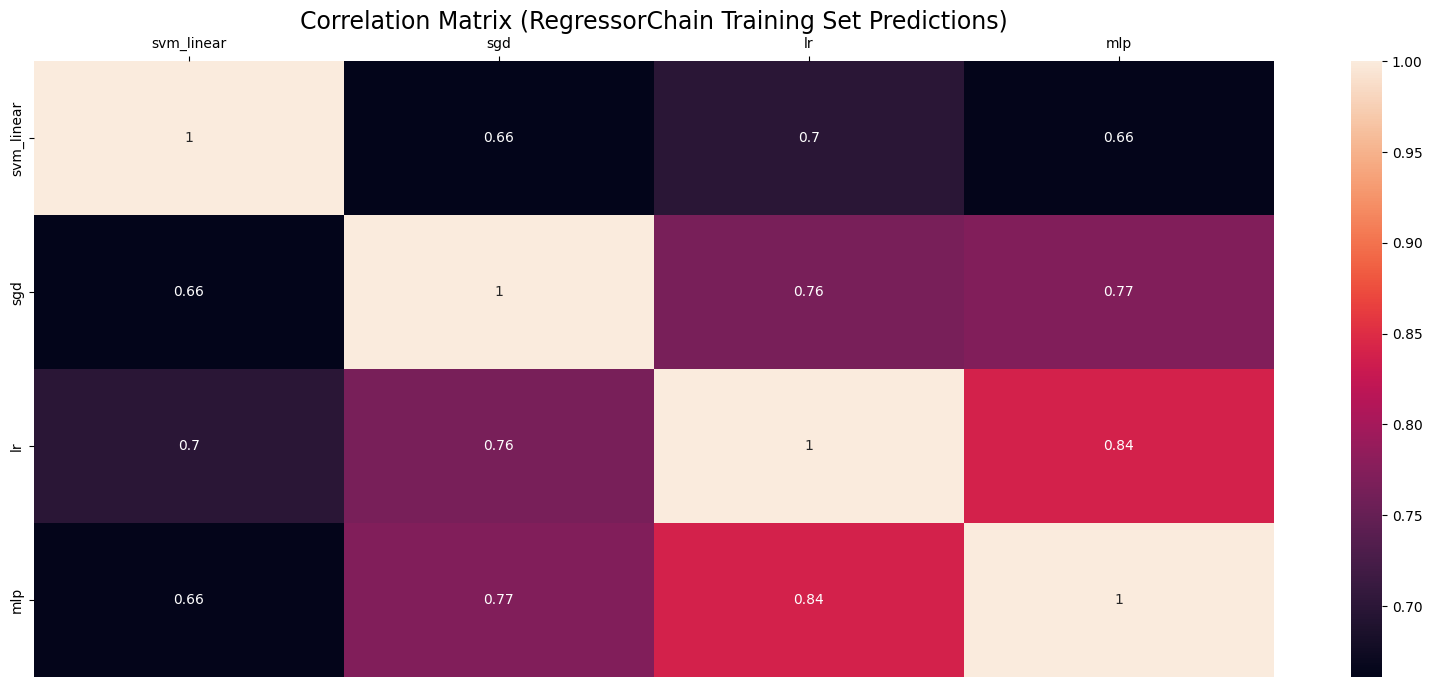

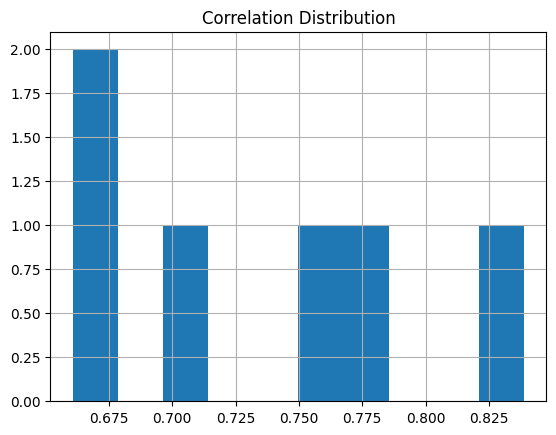

Training correlation distribution:
count    6.000000
mean     0.732960
std      0.070814
min      0.660918
25%      0.671445
50%      0.731915
75%      0.770213
max      0.838746
Name: corr, dtype: float64


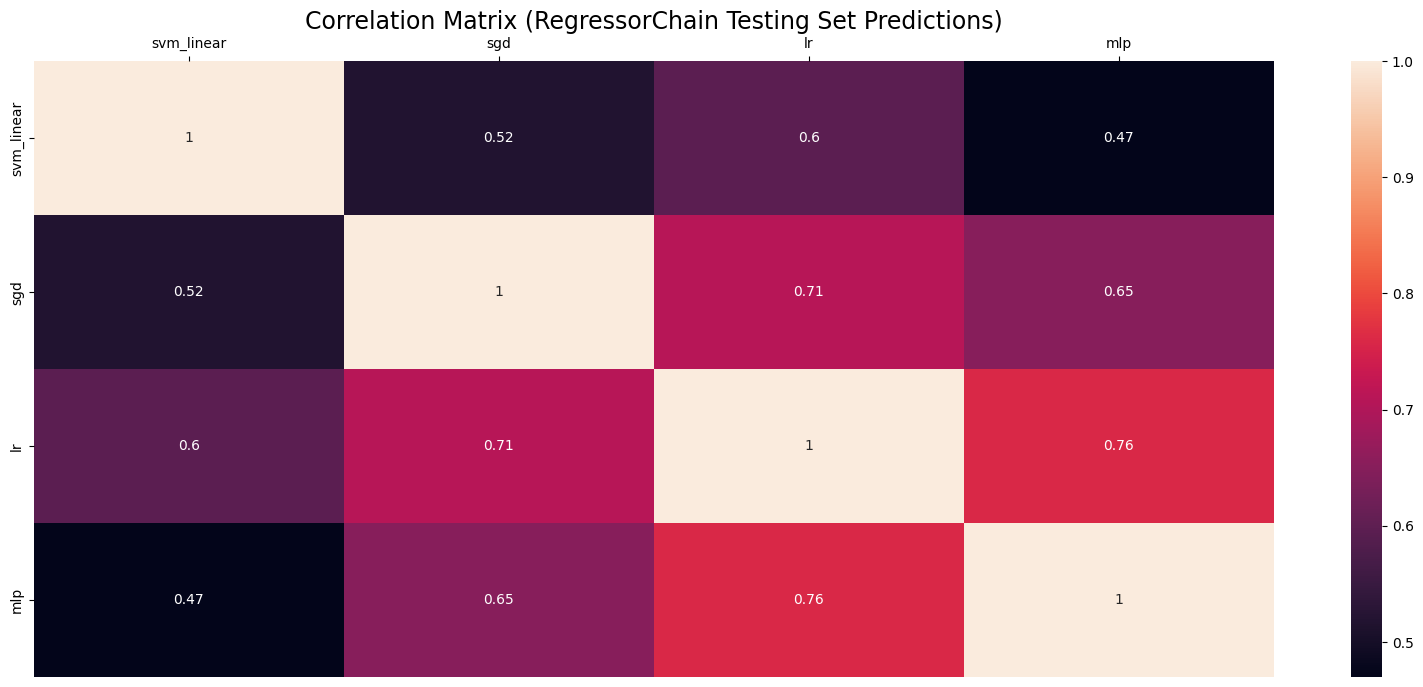

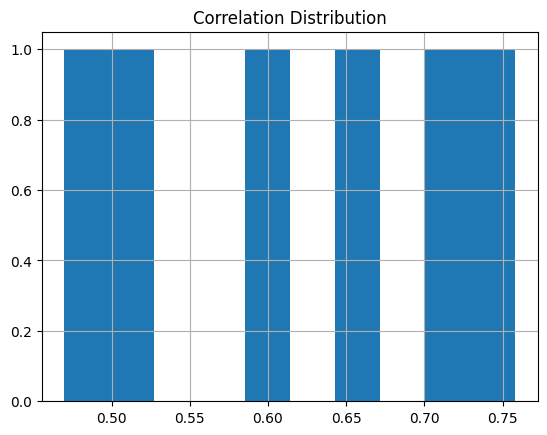

Testing correlation distribution:
count    6.000000
mean     0.616770
std      0.111089
min      0.469753
25%      0.536420
50%      0.623765
75%      0.694444
max      0.758025
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0261
NMSE: 0.1335
MAE: 2.4743
NMAE: 1.4995
aRRMSE: 1.5475
aCC: 0.9661


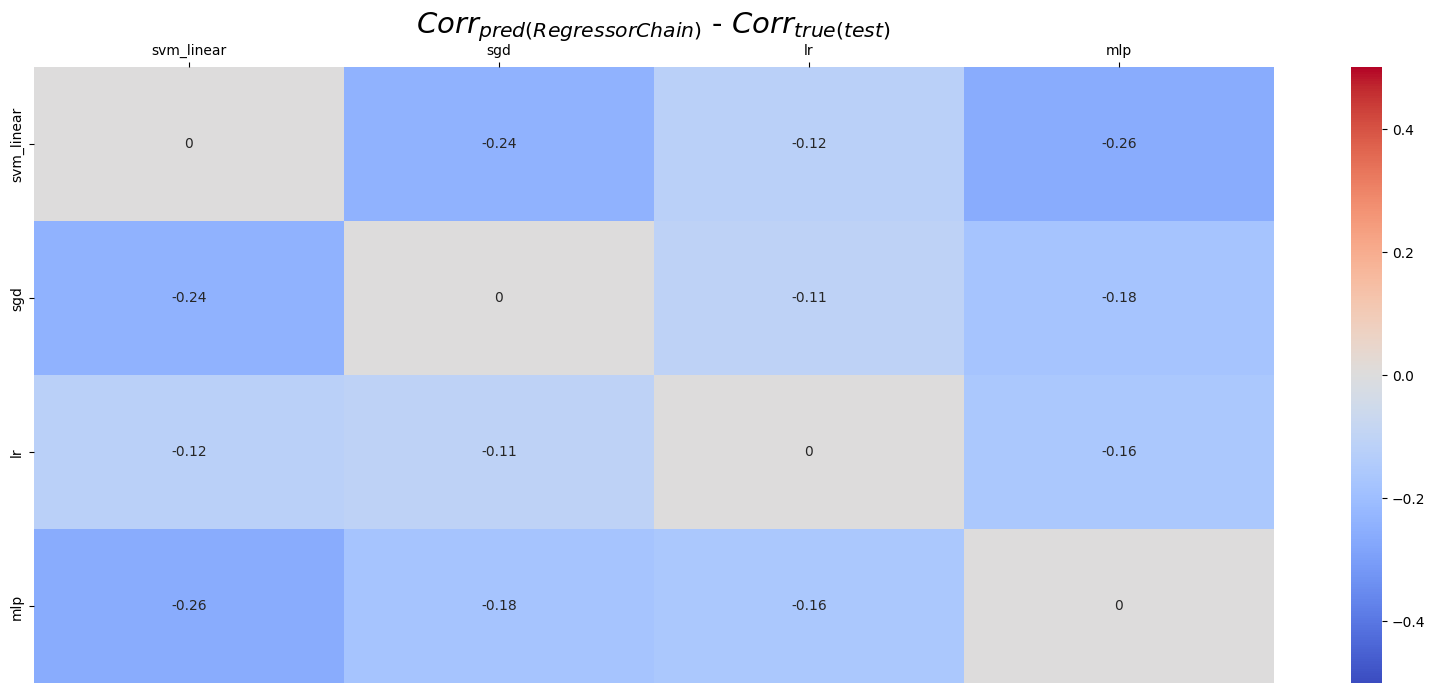

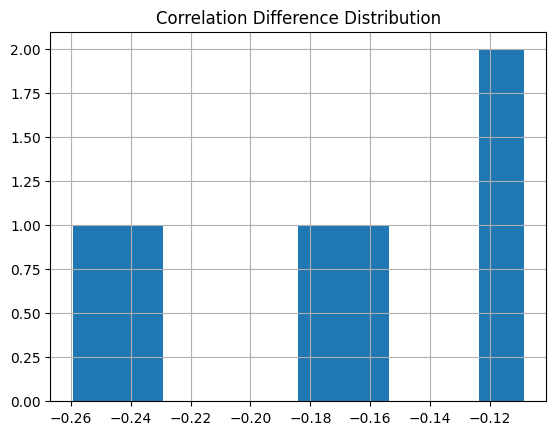

In [17]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 

results = correlation_pred_performance(regchain, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name="RegressorChain",
                                       show_plot=True, save_plot=None)

In [18]:
diff_metrics.loc['RC',:] = results['results']
diff_metrics.loc['RC',:]

MSE       0.026119
MAE       0.133488
NMSE       2.47433
NMAE      1.499483
aRRMSE    1.547492
aCC       0.966132
Name: RC, dtype: object

In [19]:
groups['regchain_assessor'] = results['groups']
groups['regchain_assessor']['test']

[['sgd'], ['svm_linear'], ['lr', 'mlp']]

### Ensemble of Regressor Chains

In [50]:
num_chains = 80
rc_ac = f'RC[{num_chains}]'

rc_ests = [RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
                          random_state=seed+i,
                          order='random', cv=5) for i in range(num_chains)]

rc_plus = GroupedAssessor(rc_ests).fit(Xa_train, ya_train)

In [ ]:
# keeping the concat because multiple numbers of chains could be recorded
if(rc_ac in metrics_df.index):
    metrics_df.loc[rc_ac,:] = assr_performance(rc_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rc_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rc_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])
metrics_df.loc[rc_ac,:]

[TRAINING SET]
MSE: 0.0133
NMSE: 0.2133
MAE: 0.0866
NMAE: 0.4392
aRRMSE: 0.4613
aCC: 0.9405

[TESTING SET]
MSE: 0.0620
NMSE: 1.1154
MAE: 0.1977
NMAE: 1.0276
aRRMSE: 1.0561
aCC: 0.0938


MSE       MAE      NMSE      NMAE    aRRMSE       aCC
Model                                                                 
svm_linear  0.044243  1.098416  0.167503  1.031554  1.048053  0.109314
sgd          0.08699  1.155029  0.240877  1.062702  1.074723   0.05139
lr          0.045572  1.096345  0.168456  1.003451  1.047065  0.112713
mlp         0.071258  1.111921  0.214158  1.012735  1.054477  0.101808

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

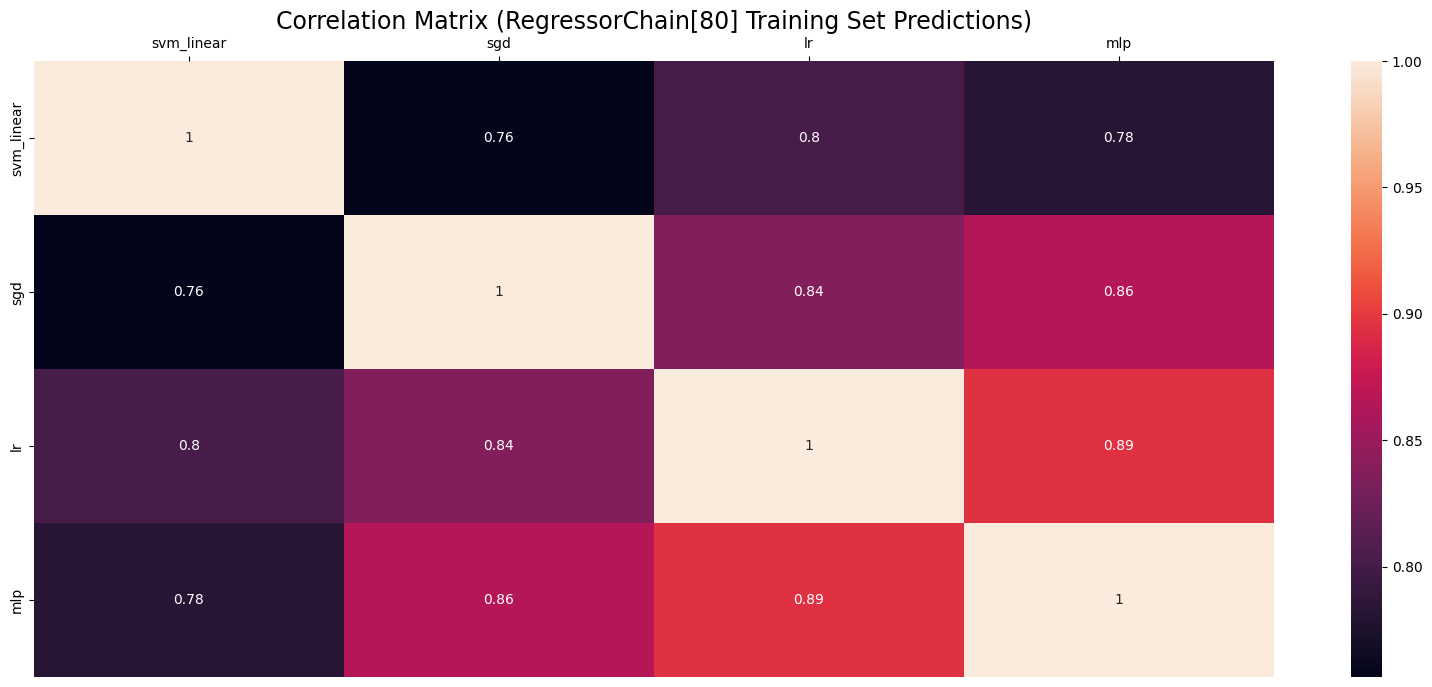

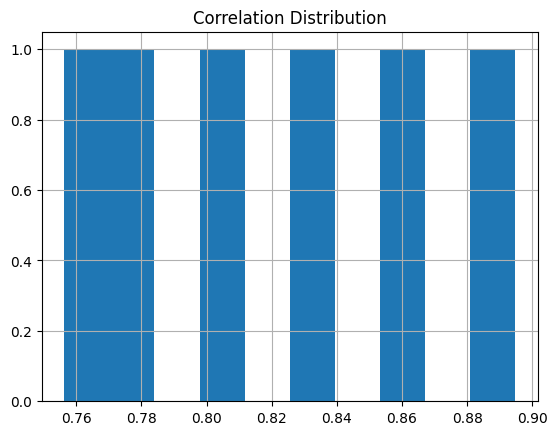

Training correlation distribution:
count    6.000000
mean     0.822844
std      0.052139
min      0.756327
25%      0.787346
50%      0.819485
75%      0.857671
max      0.894737
Name: corr, dtype: float64


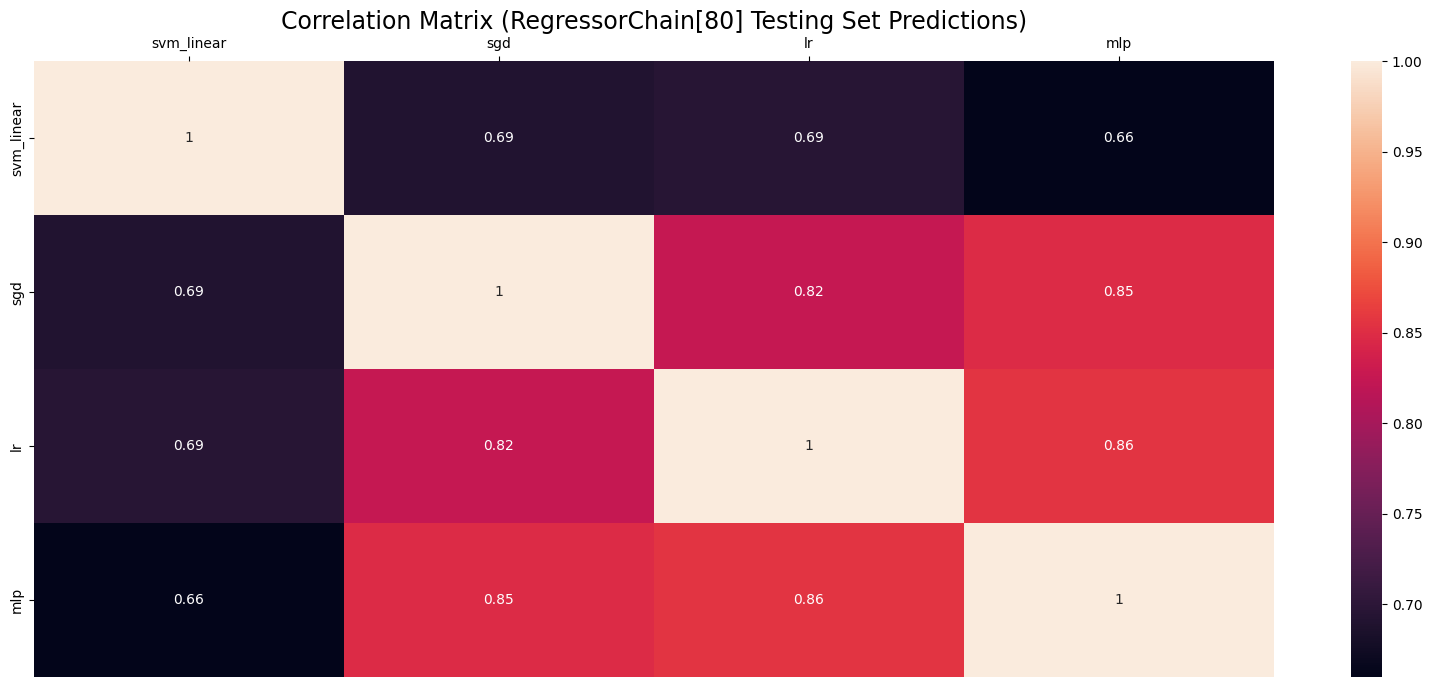

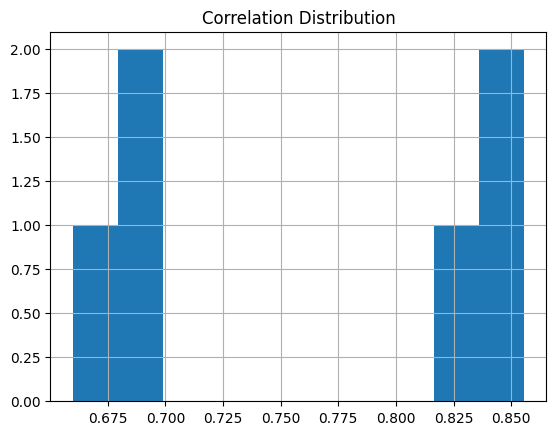

Testing correlation distribution:
count    6.000000
mean     0.762037
std      0.089836
min      0.659877
25%      0.690741
50%      0.759568
75%      0.842284
max      0.855556
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0018
NMSE: 0.0309
MAE: 0.1639
NMAE: 0.3413
aRRMSE: 0.4008
aCC: 0.9689


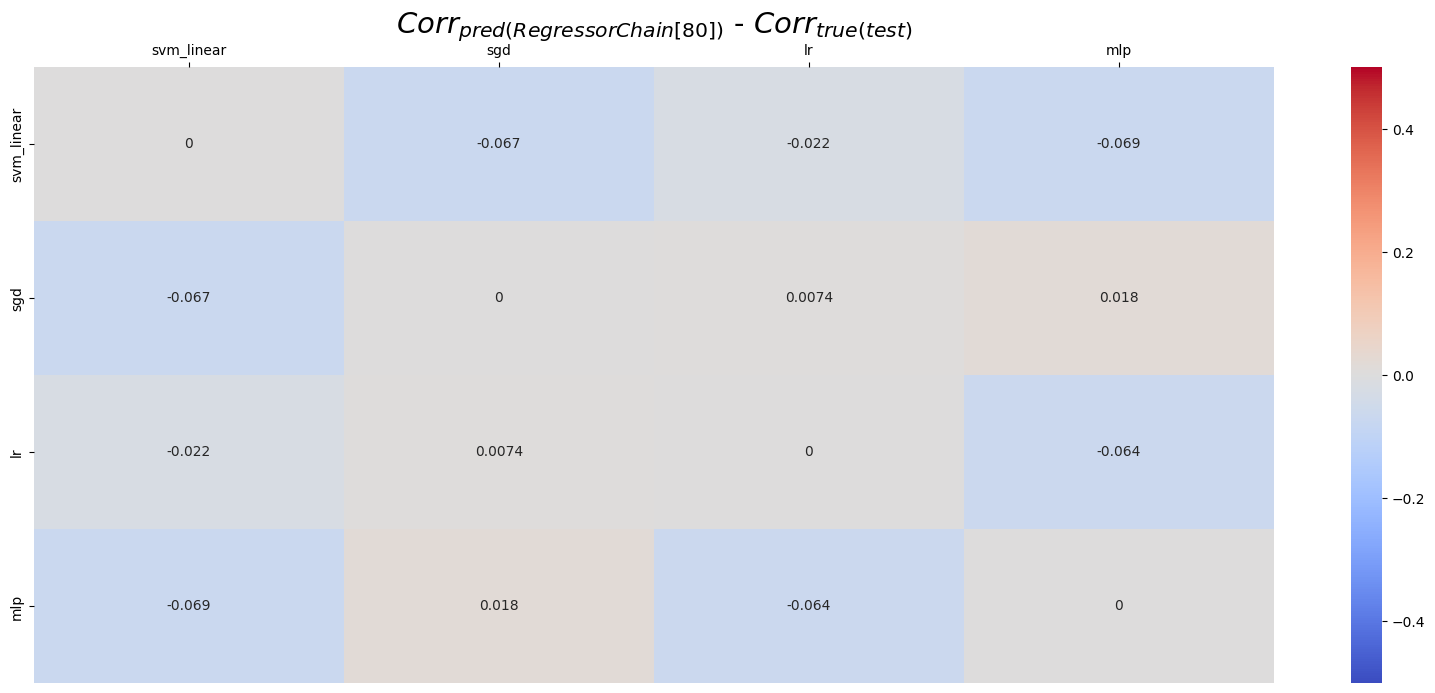

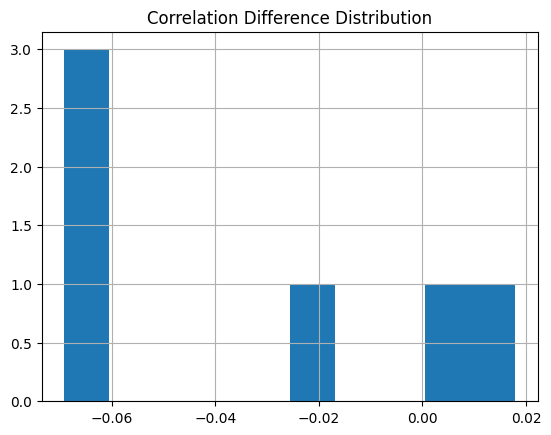

In [52]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#80chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]",
                                       show_plot=True, save_plot=None)

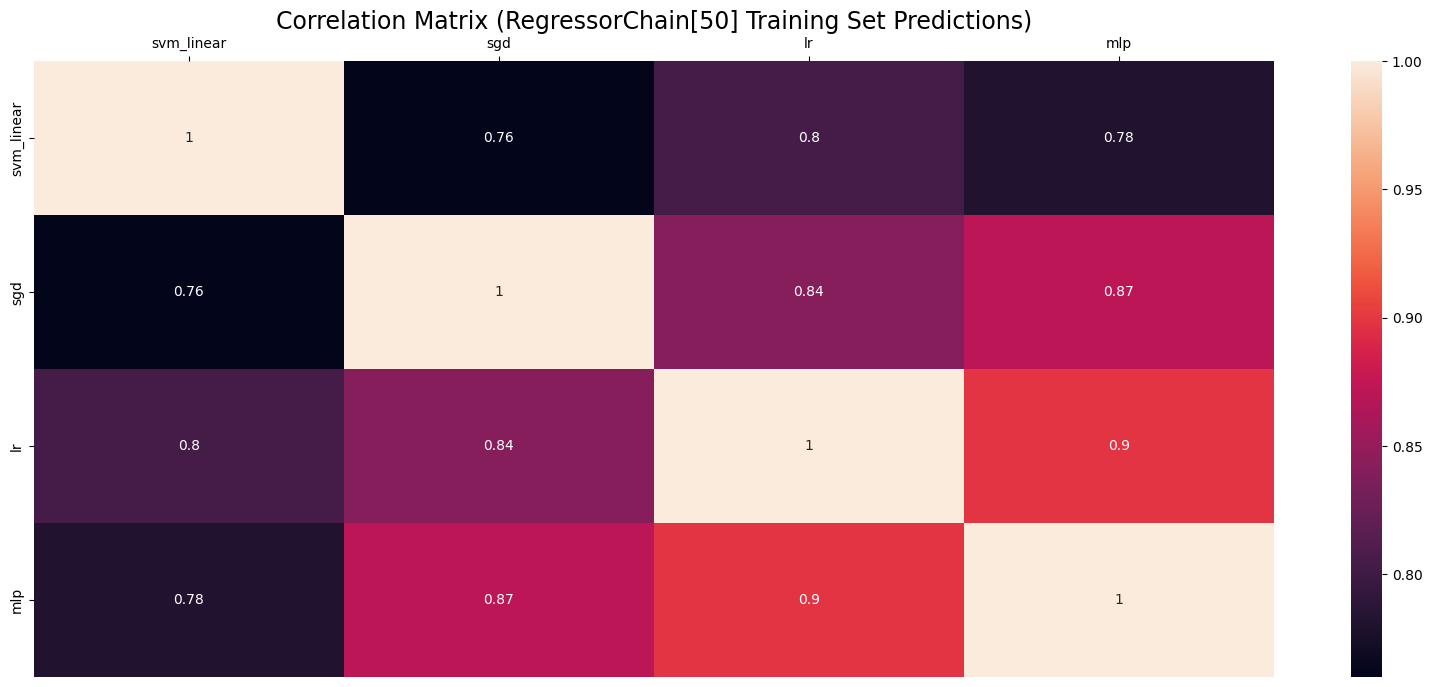

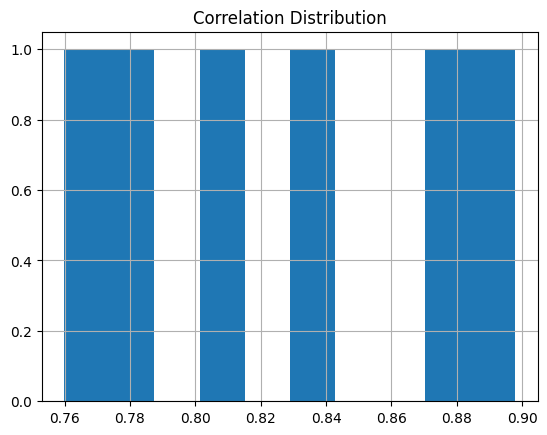

Training correlation distribution:
count    6.000000
mean     0.825756
std      0.053598
min      0.759910
25%      0.786562
50%      0.822172
75%      0.863830
max      0.897872
Name: corr, dtype: float64


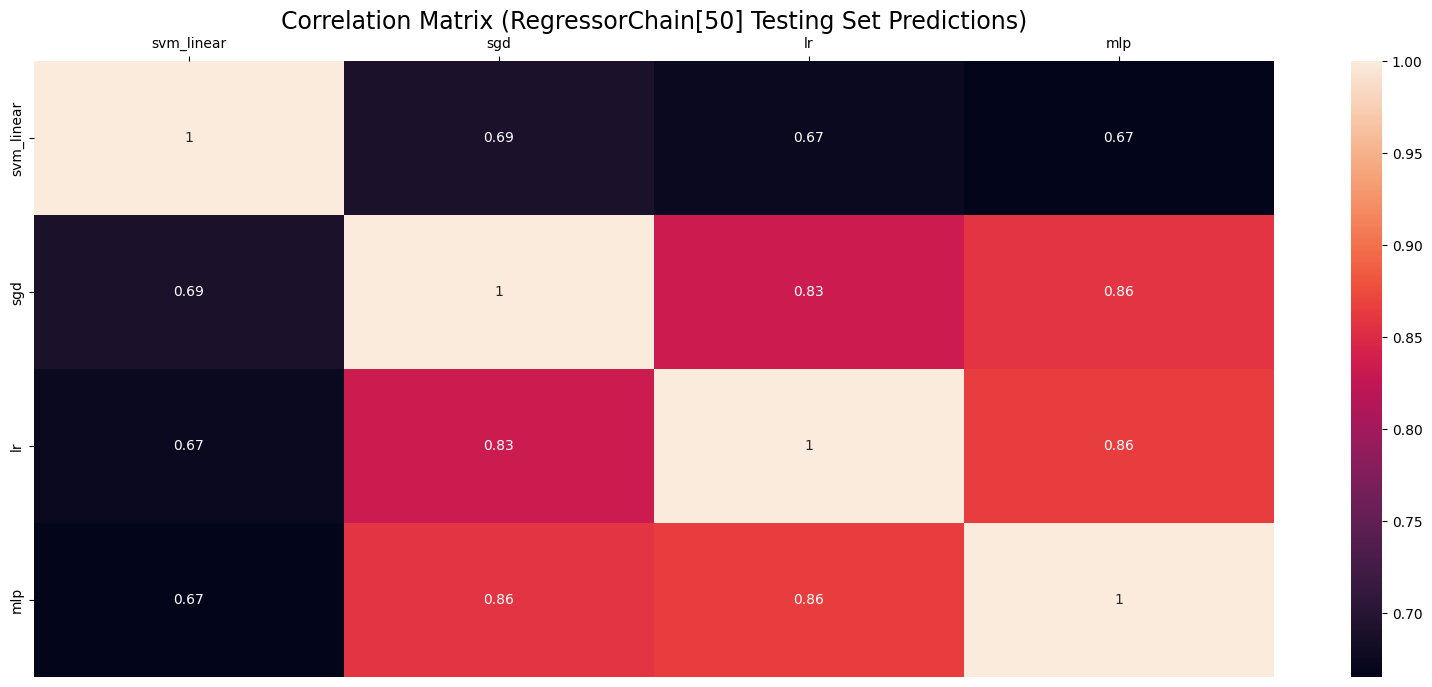

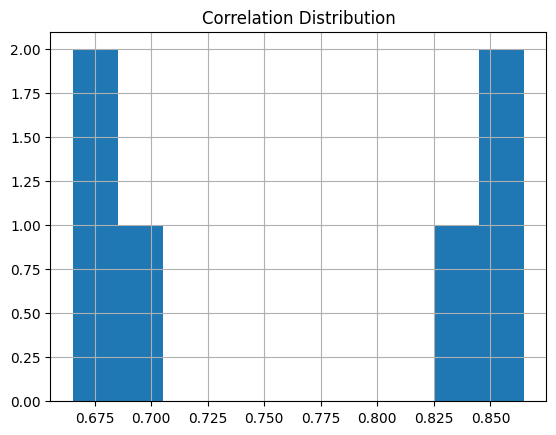

Testing correlation distribution:
count    6.000000
mean     0.764198
std      0.097356
min      0.665432
25%      0.677469
50%      0.761420
75%      0.852315
max      0.864815
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0018
NMSE: 0.0340
MAE: 0.1663
NMAE: 0.3773
aRRMSE: 0.4054
aCC: 0.9676


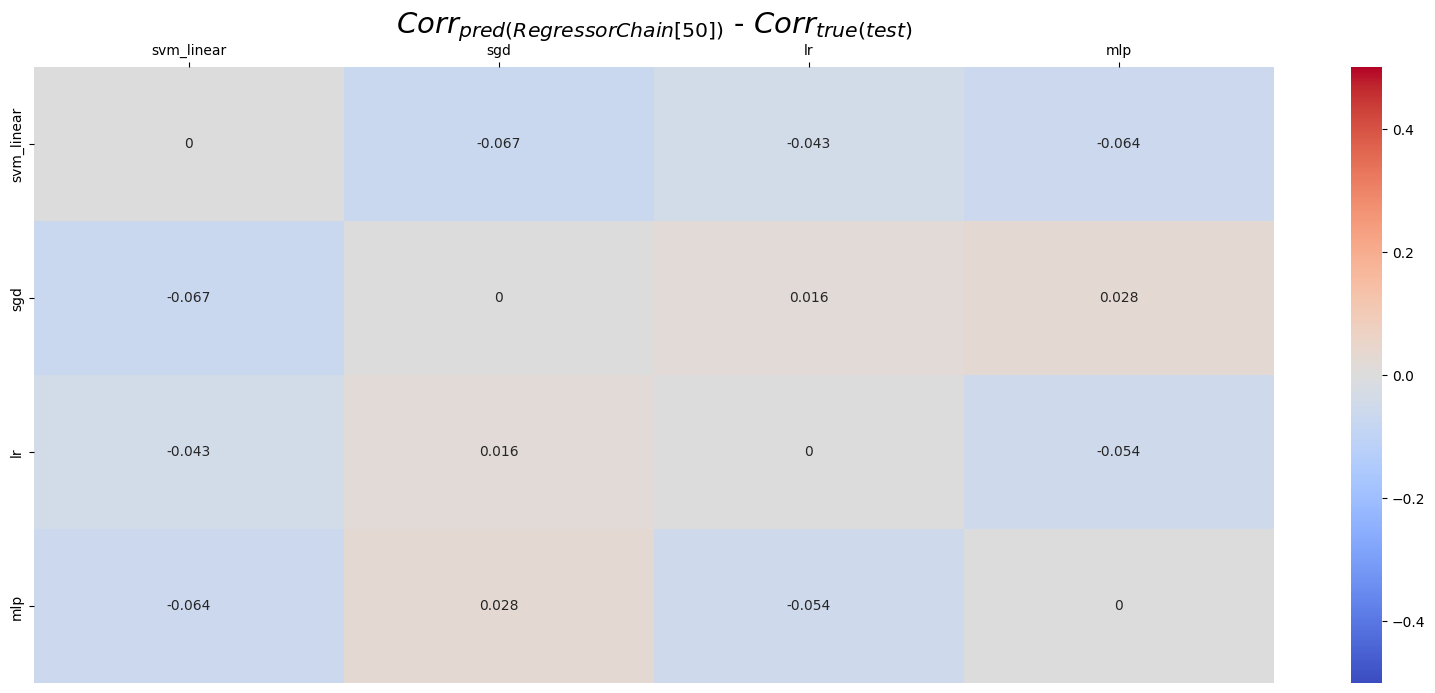

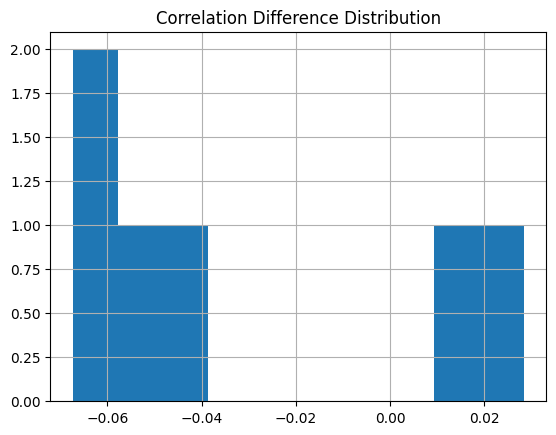

In [45]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#50chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]",
                                       show_plot=True, save_plot=None)

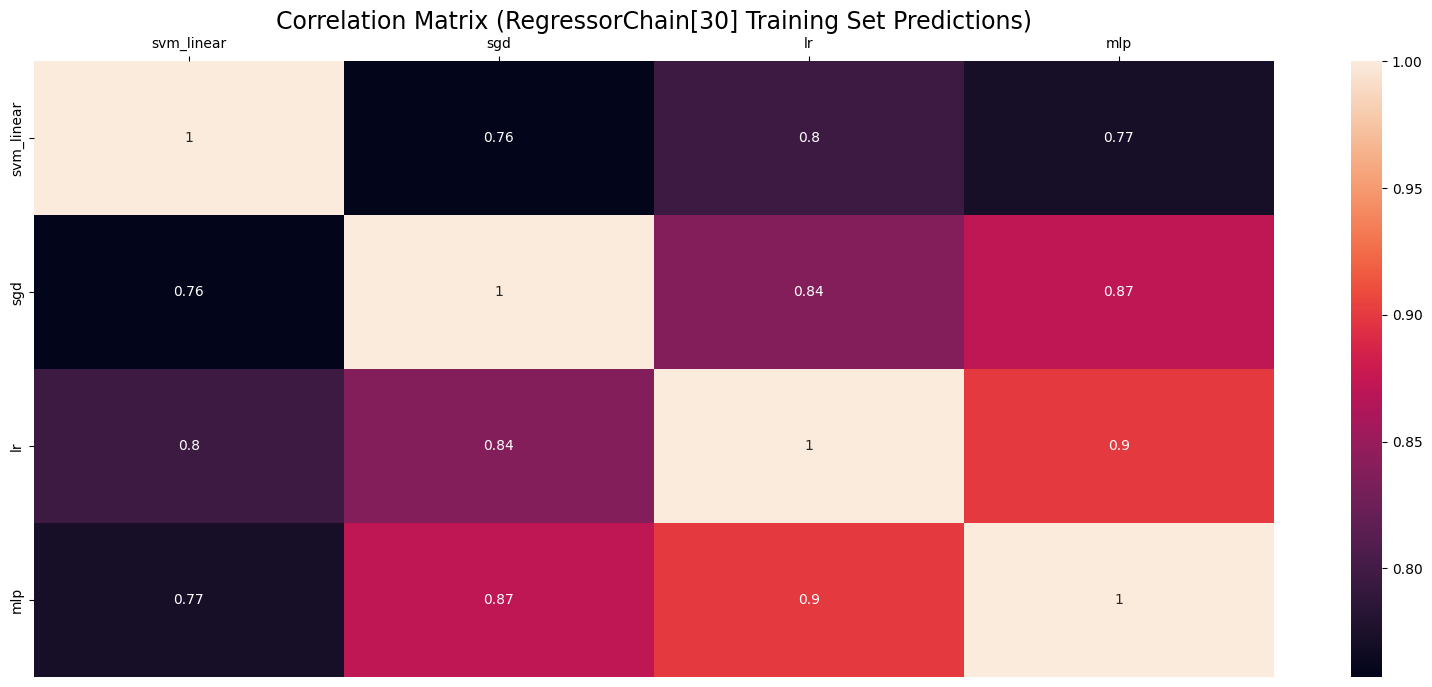

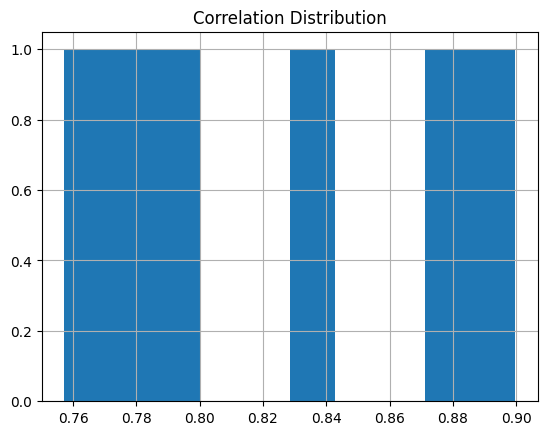

Training correlation distribution:
count    6.000000
mean     0.822620
std      0.056891
min      0.757223
25%      0.777828
50%      0.817693
75%      0.863606
max      0.899664
Name: corr, dtype: float64


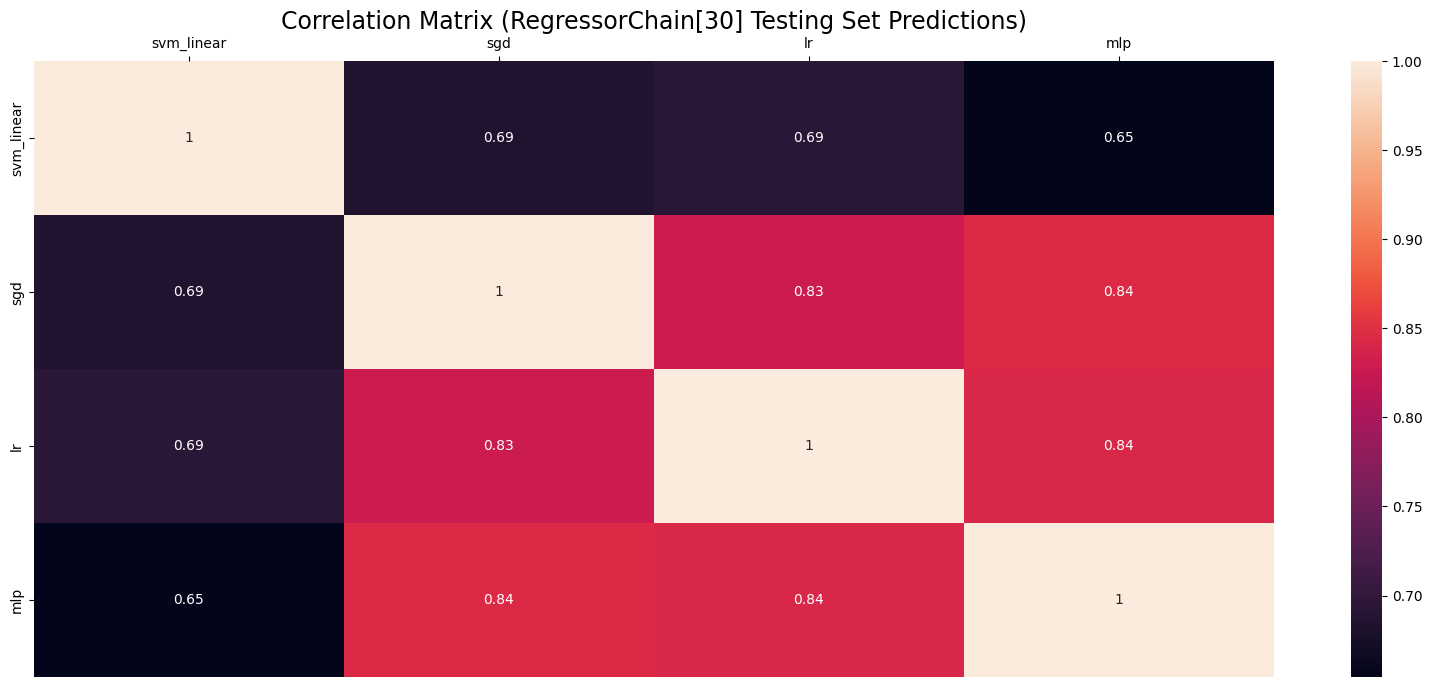

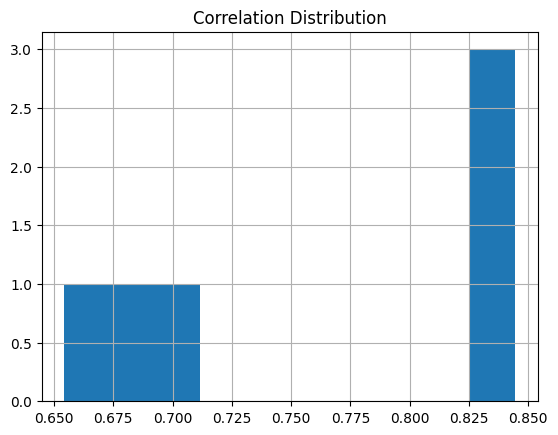

Testing correlation distribution:
count    6.000000
mean     0.757613
std      0.088997
min      0.654321
25%      0.687037
50%      0.760494
75%      0.837654
max      0.844444
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0022
NMSE: 0.0342
MAE: 0.2044
NMAE: 0.3771
aRRMSE: 0.4482
aCC: 0.9610


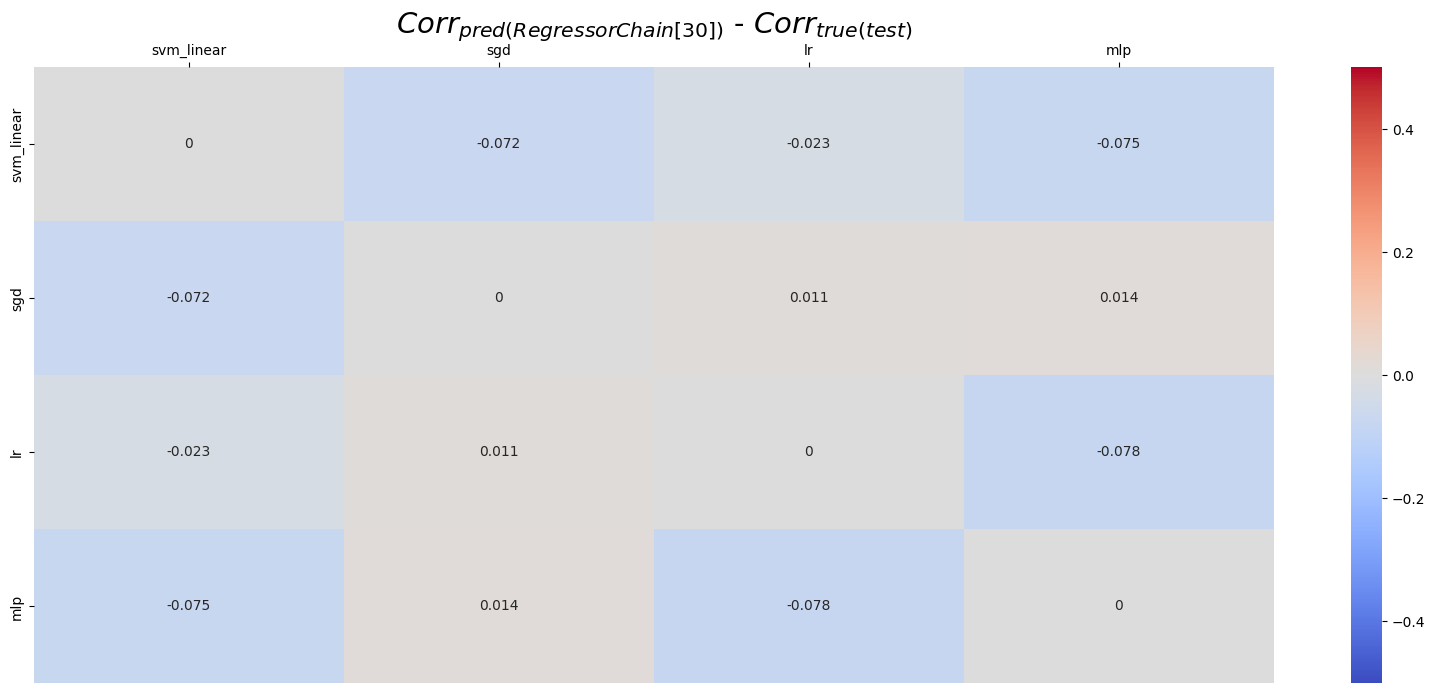

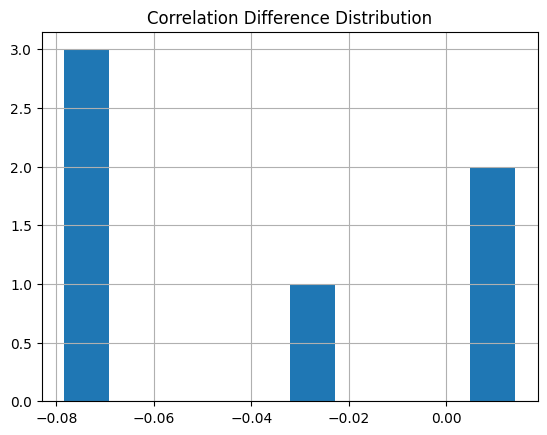

In [38]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#30chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]",
                                       show_plot=True, save_plot=None)

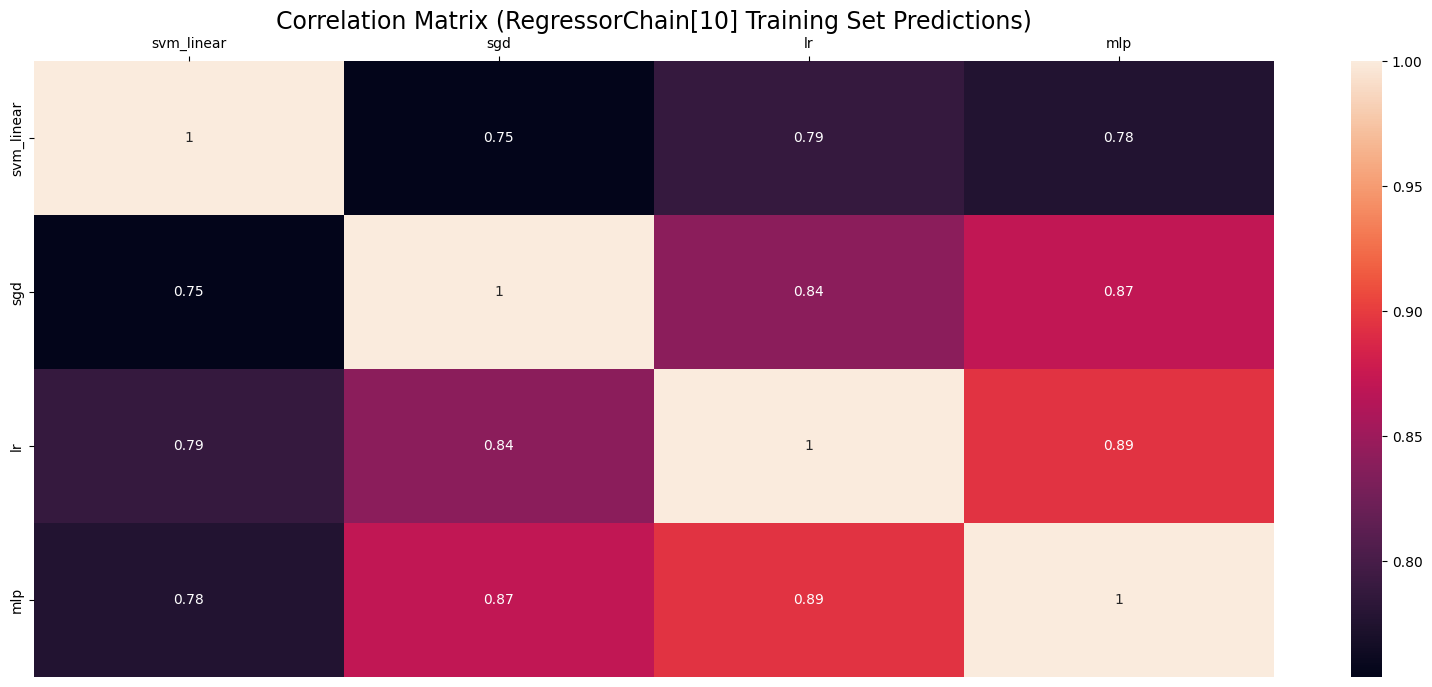

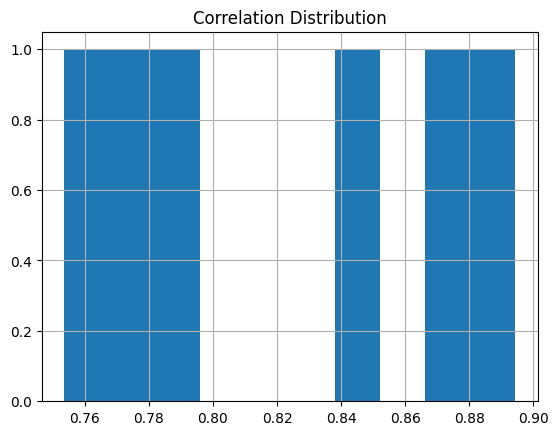

Training correlation distribution:
count    6.000000
mean     0.820381
std      0.056103
min      0.753639
25%      0.779171
50%      0.814110
75%      0.862486
max      0.894289
Name: corr, dtype: float64


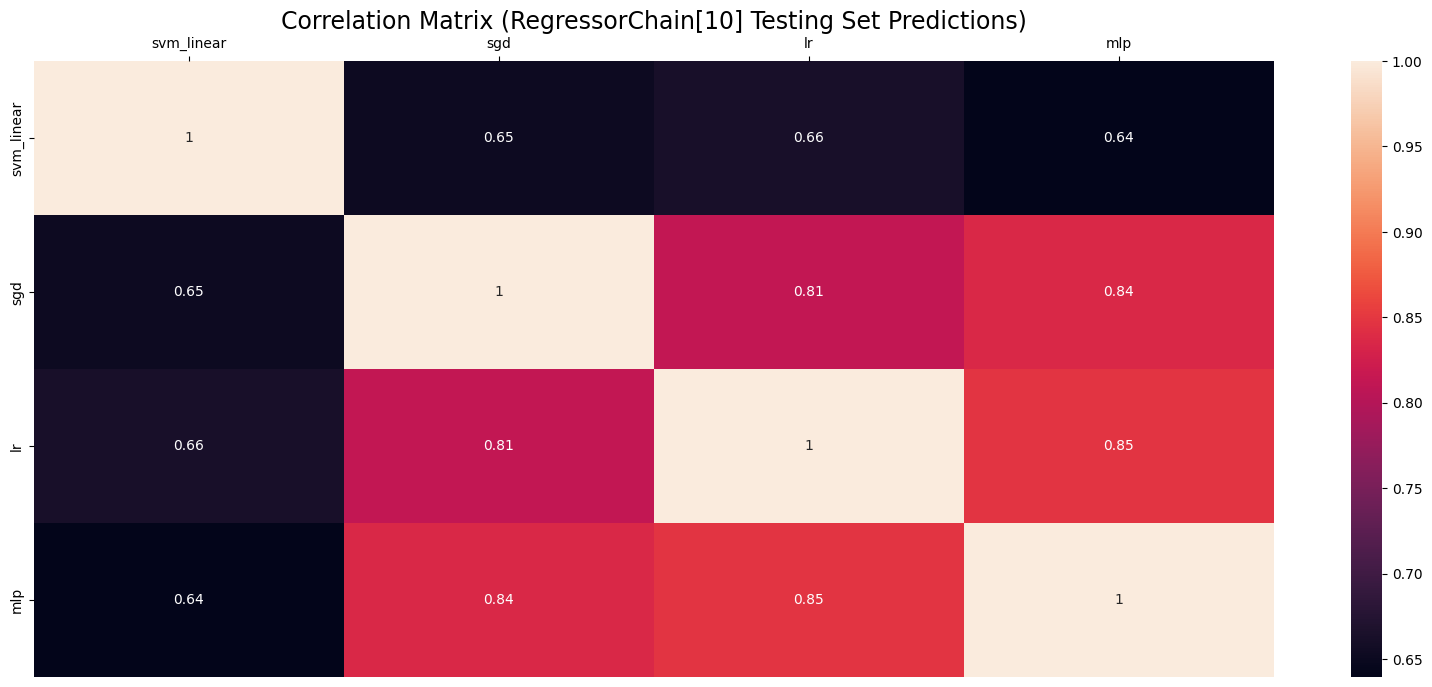

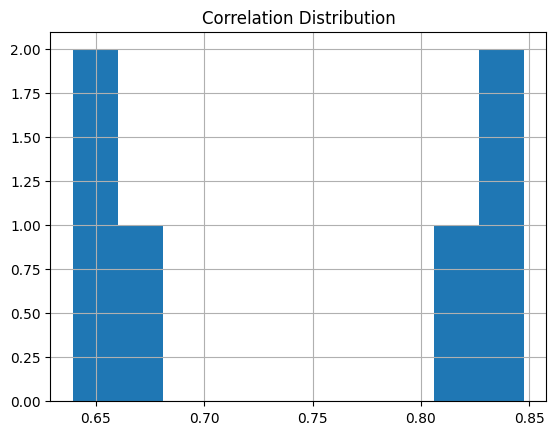

Testing correlation distribution:
count    6.000000
mean     0.741461
std      0.099772
min      0.639506
25%      0.654475
50%      0.737037
75%      0.829784
max      0.847531
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0034
NMSE: 0.0414
MAE: 0.3112
NMAE: 0.4534
aRRMSE: 0.5520
aCC: 0.9685


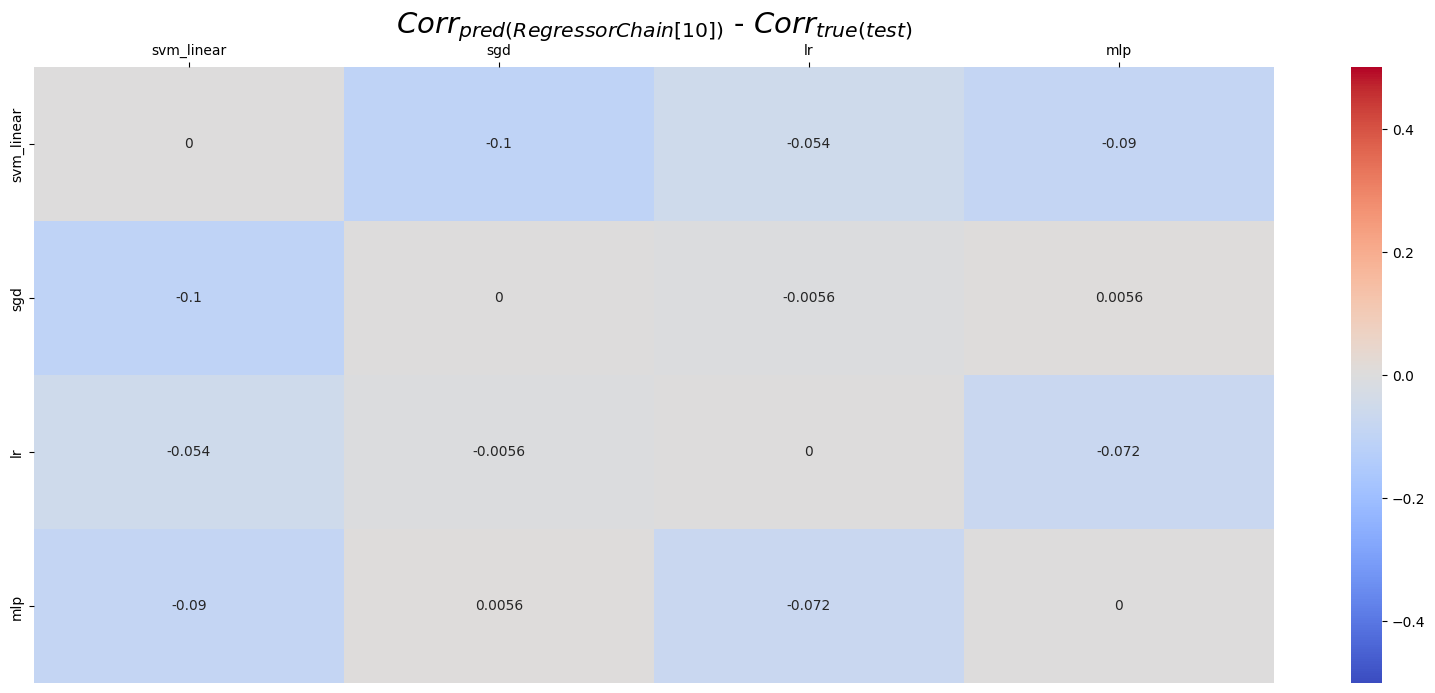

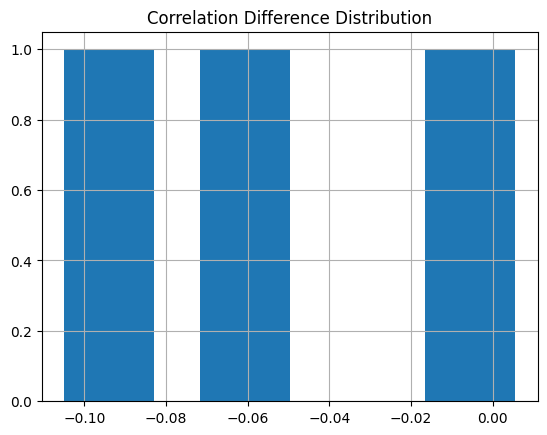

In [22]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#10chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]",
                                       show_plot=True, save_plot=None)

In [53]:
diff_metrics.loc[rc_ac,:] = results['results']
diff_metrics.loc[rc_ac,:]

MSE       0.001774
MAE       0.030864
NMSE      0.163913
NMAE      0.341346
aRRMSE    0.400761
aCC       0.968865
Name: RC[80], dtype: object

In [54]:
groups[f'regchain{num_chains}_assessor'] = results['groups']
groups[f'regchain{num_chains}_assessor']['test']

[['sgd', 'lr', 'mlp'], ['svm_linear']]

### Multi-Output Random Forest Regressor 

In [18]:
mrf = RandomForestRegressor(random_state=seed).fit(Xa_train, ya_train)

In [19]:
metrics_df.loc['MRT',:] = assr_performance(mrf, Xa_test, ya_test, Xa_train, ya_train)

[TRAINING SET]
MSE: 0.0065
NMSE: 0.1247
MAE: 0.0566
NMAE: 0.3300
aRRMSE: 0.3531
aCC: 0.9738

[TESTING SET]
MSE: 0.0552
NMSE: 1.0449
MAE: 0.1685
NMAE: 0.9599
aRRMSE: 1.0214
aCC: 0.1633


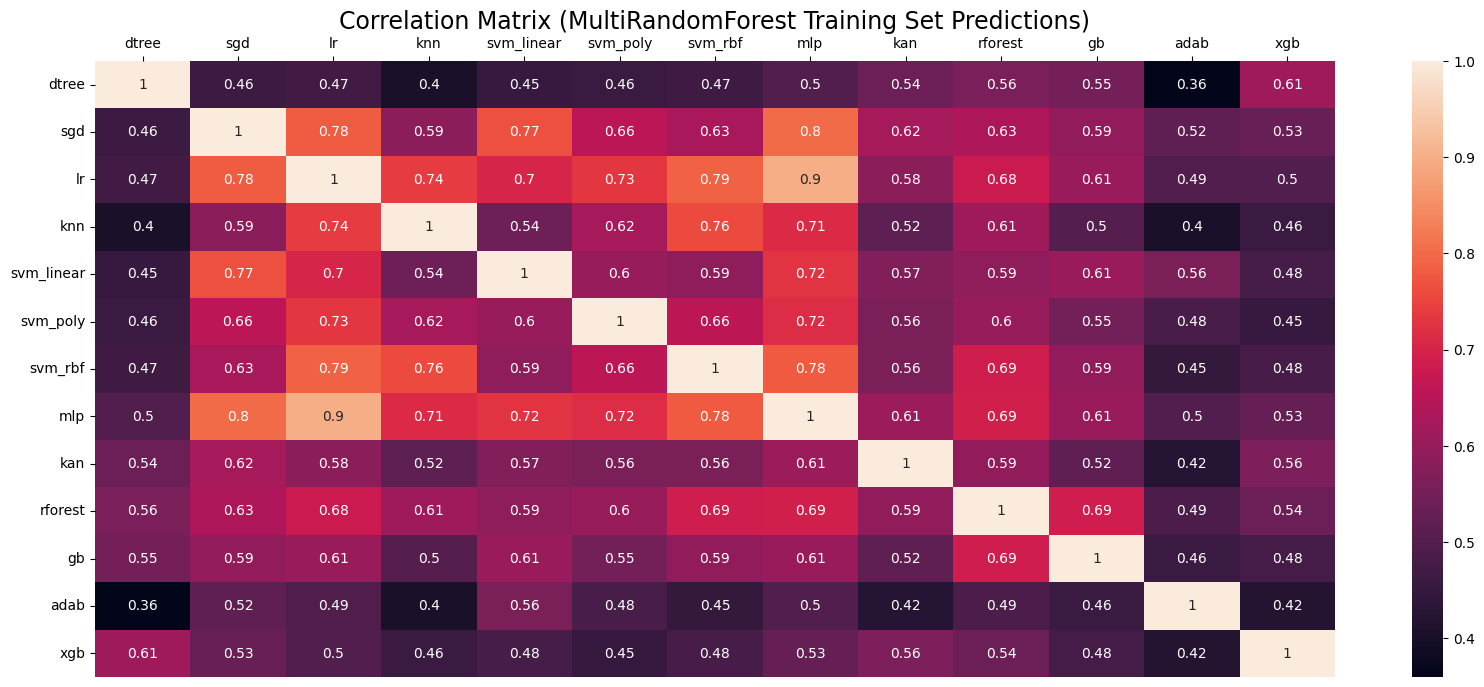

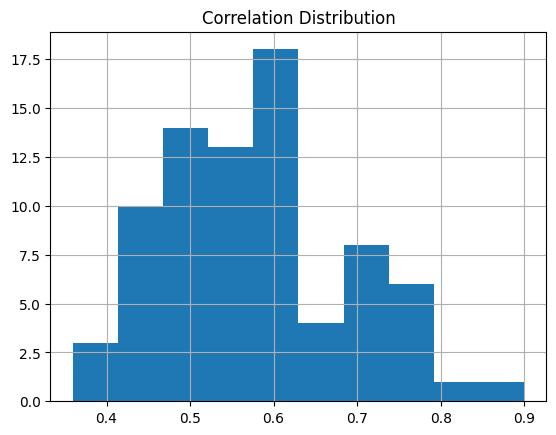

Training correlation distribution:
count    78.000000
mean      0.579582
std       0.110127
min       0.359910
25%       0.493505
50%       0.568197
75%       0.631131
max       0.899664
Name: corr, dtype: float64


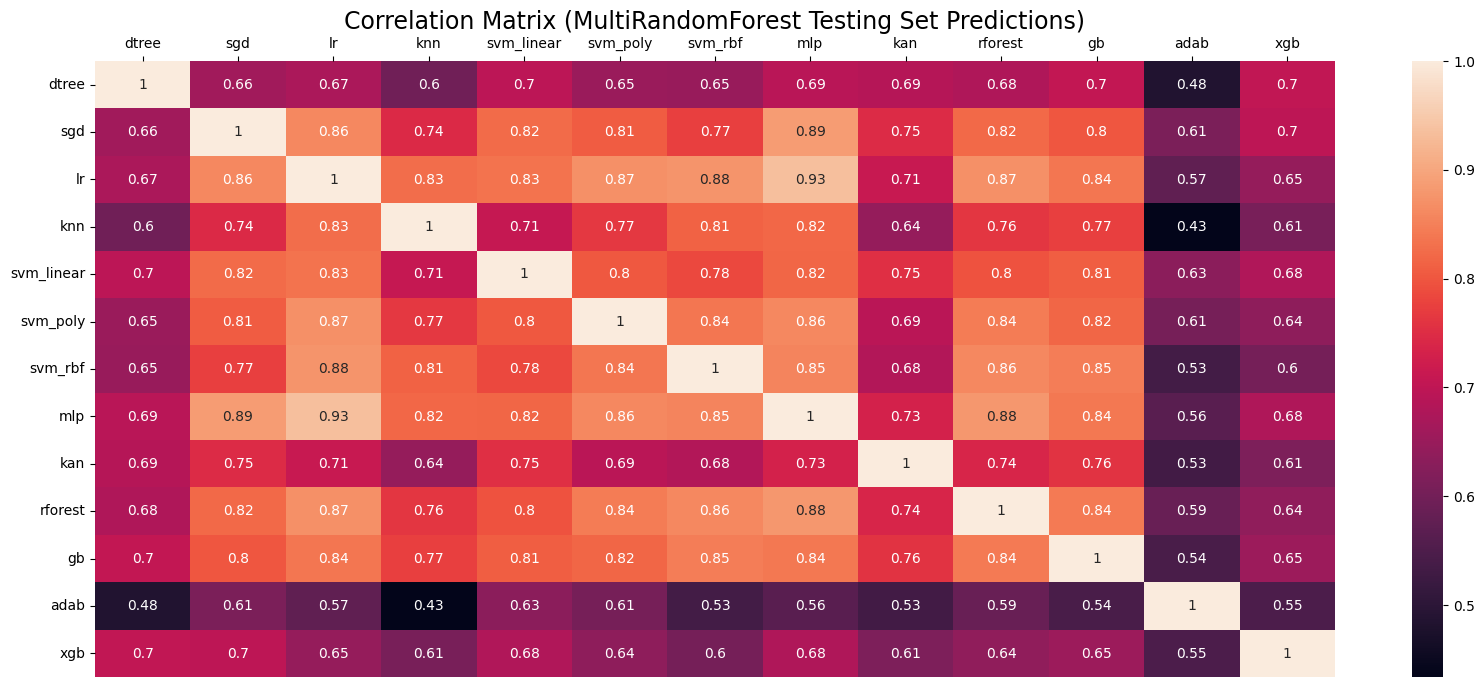

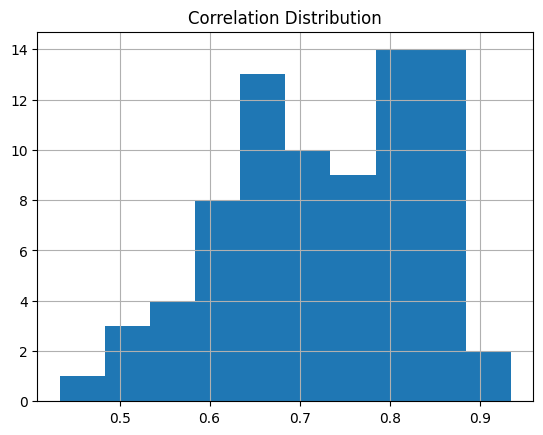

Testing correlation distribution:
count    78.000000
mean      0.726164
std       0.110445
min       0.433709
25%       0.646142
50%       0.733951
75%       0.821405
max       0.934568
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0390
NMSE: 0.1641
MAE: 1.5652
NMAE: 1.4414
aRRMSE: 1.2090
aCC: 0.7753


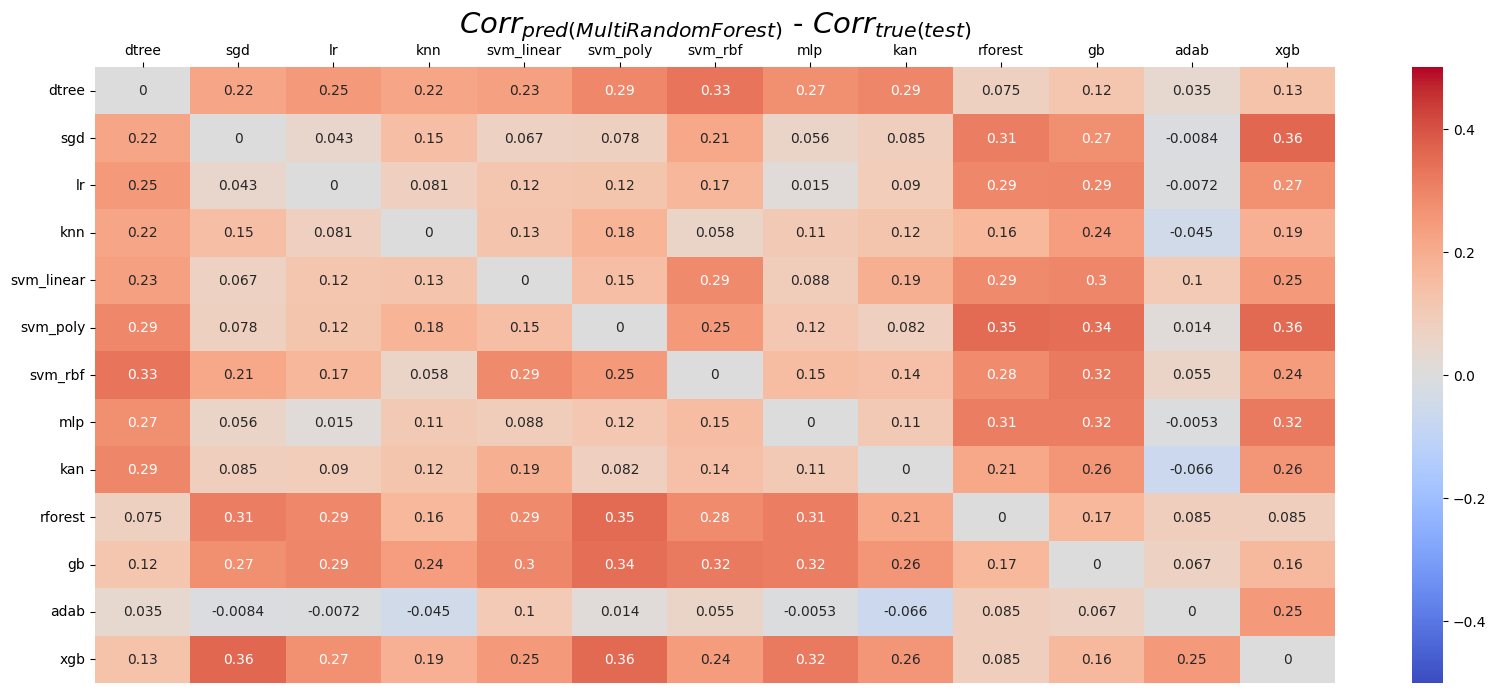

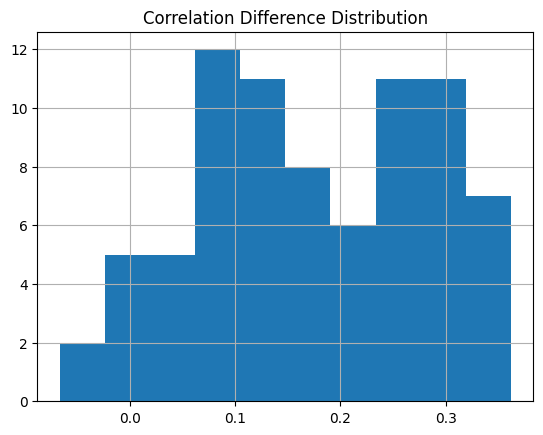

In [20]:
results = correlation_pred_performance(mrf, Xa_test, ya_test, Xa_train, 
                                       MIN_SCORE, name="MultiRandomForest")

In [21]:
diff_metrics.loc['MRT',:] = results['results']
diff_metrics.loc['MRT',:]

MSE       0.038984
MAE       0.164065
NMSE      1.565188
NMAE      1.441396
aRRMSE    1.209004
aCC       0.775307
Name: MRT, dtype: object

In [22]:
groups['mrf_assessor'] = results['groups']
groups['mrf_assessor']['test']

[['dtree'],
 ['xgb'],
 ['mlp', 'rforest', 'sgd', 'knn', 'svm_rbf', 'svm_poly', 'gb', 'lr'],
 ['mlp', 'rforest', 'sgd', 'kan', 'svm_linear', 'gb'],
 ['mlp', 'rforest', 'sgd', 'svm_linear', 'svm_rbf', 'svm_poly', 'gb', 'lr'],
 ['adab']]

### Multi-Output SVR

In [23]:
#msvr = MSVR()
#msvr.fit(np.asarray(Xa_train_norm), np.asarray(ya_train))
#msvr_params = product(svm_rbf_params)
#g_search = GridSearchCV(MSVR(), svm_rbf_params, scoring='neg_mean_squared_error', n_jobs=-1).fit(np.asarray(Xa_train_norm), np.asarray(ya_train))
#print(g_search.best_params_)
#msvr = g_search.best_estimator_

In [24]:
#study_norm = OptunaStudy(Xa_train_norm, ya_train.values, 200)
#study_norm.search(MSVR)

In [25]:
msvr = MSVR().fit(Xa_train_norm, ya_train.values)

In [26]:
metrics_df.loc['M-SVR',:] = assr_performance(msvr, Xa_test_norm, ya_test, Xa_train_norm, ya_train)

[TRAINING SET]
MSE: 0.0153
NMSE: 0.4433
MAE: 0.0920
NMAE: 0.6101
aRRMSE: 0.6315
aCC: 0.8343

[TESTING SET]
MSE: 0.0479
NMSE: 1.2736
MAE: 0.1565
NMAE: 0.9826
aRRMSE: 1.0767
aCC: 0.3397


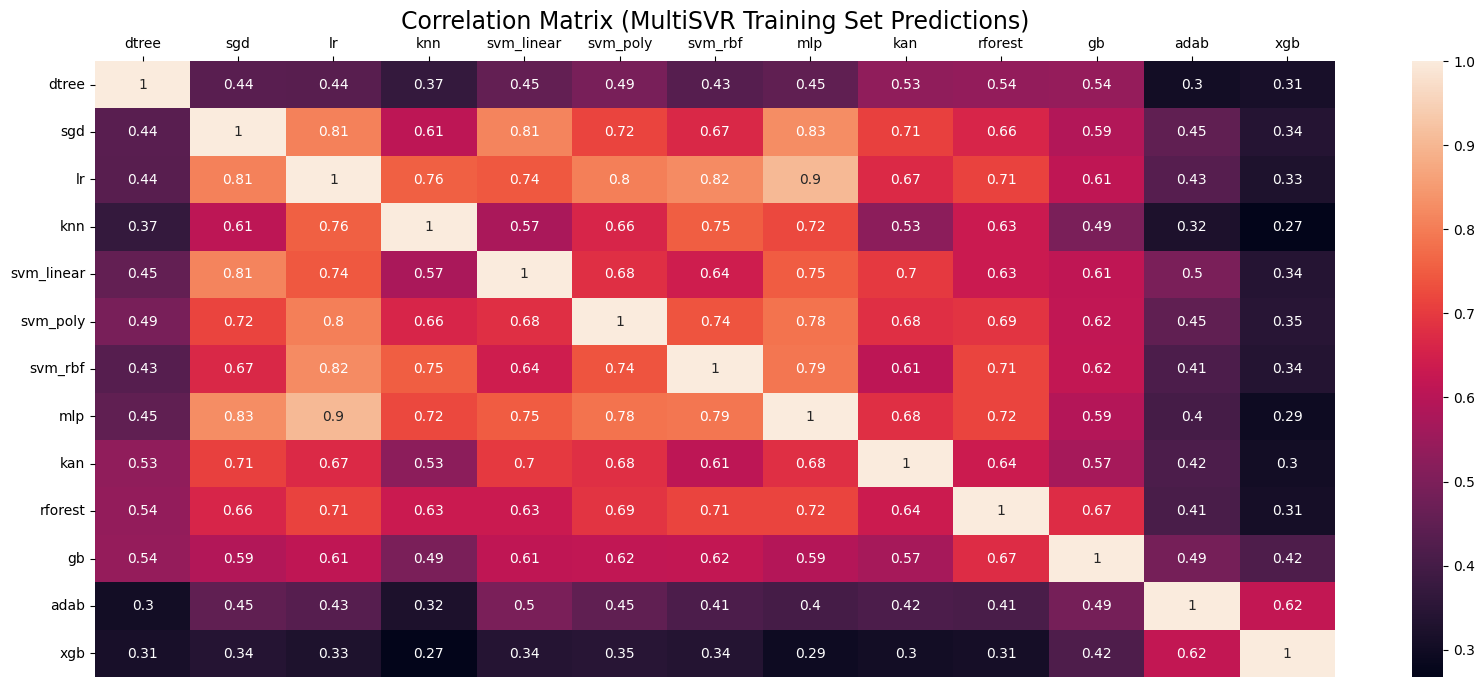

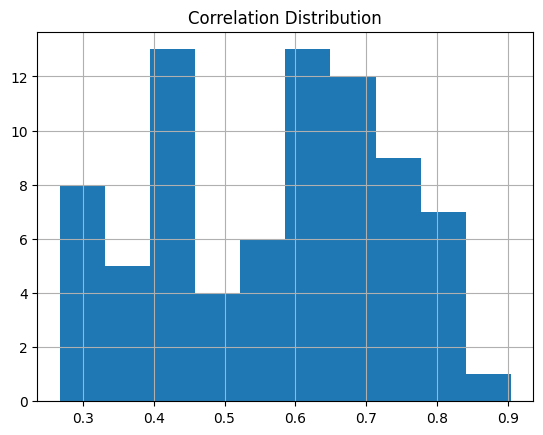

Training correlation distribution:
count    78.000000
mean      0.569070
std       0.162541
min       0.267637
25%       0.432475
50%       0.610526
75%       0.695073
max       0.904143
Name: corr, dtype: float64


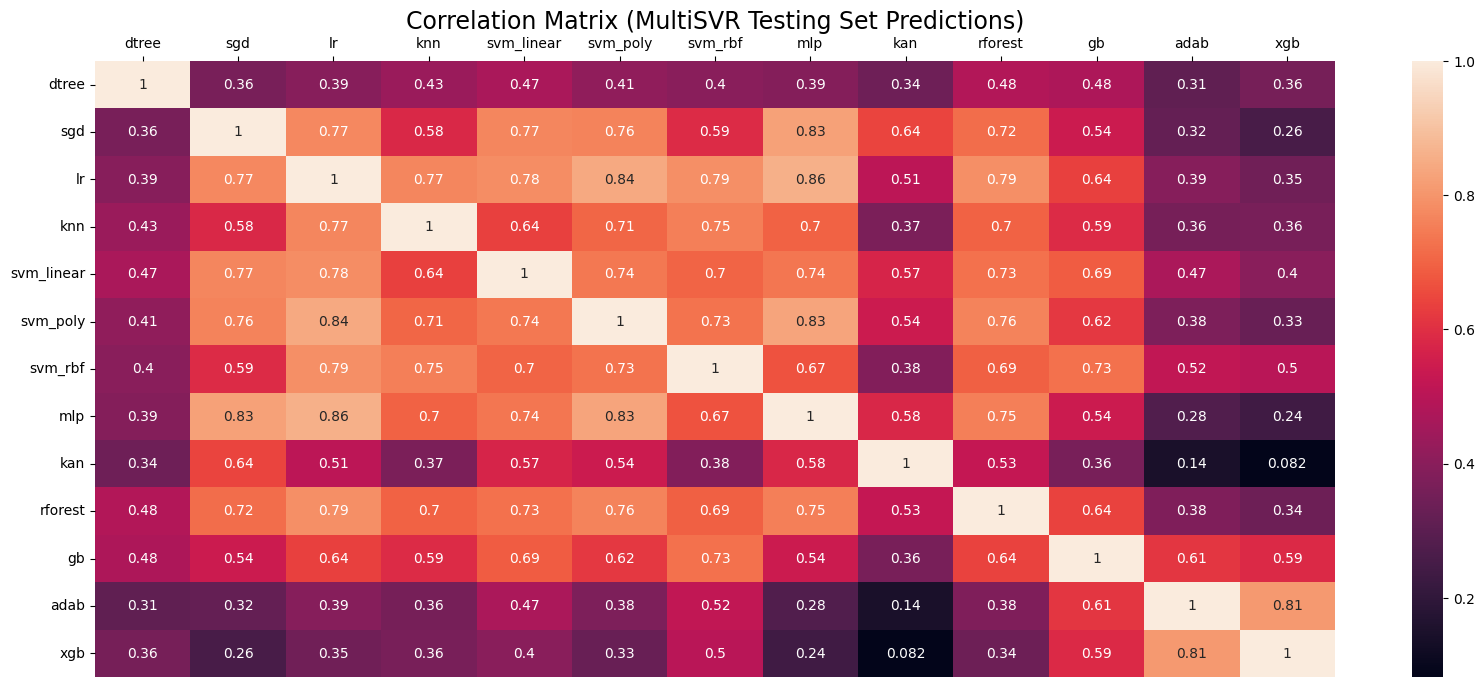

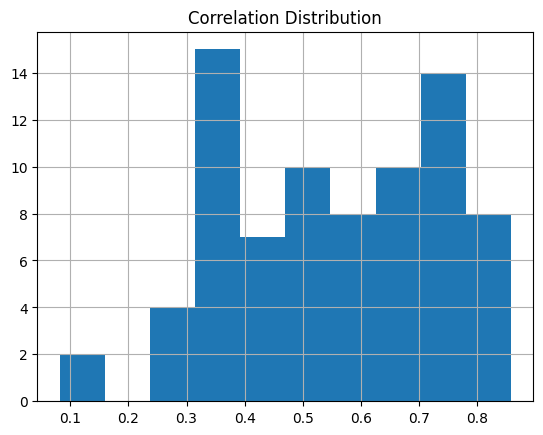

Testing correlation distribution:
count    78.000000
mean      0.552279
std       0.186543
min       0.082099
25%       0.384259
50%       0.575926
75%       0.723765
max       0.858025
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0195
NMSE: 0.1000
MAE: 0.7967
NMAE: 0.9043
aRRMSE: 0.8315
aCC: 0.7639


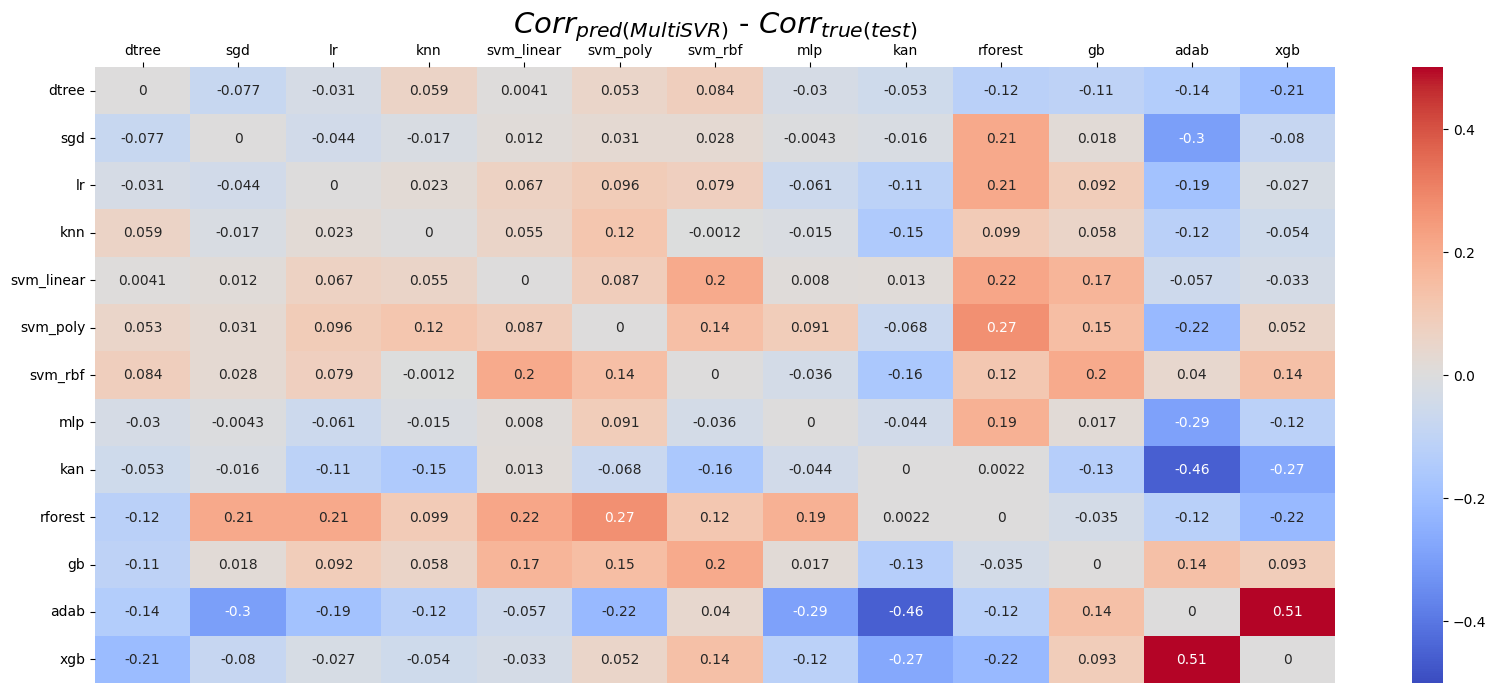

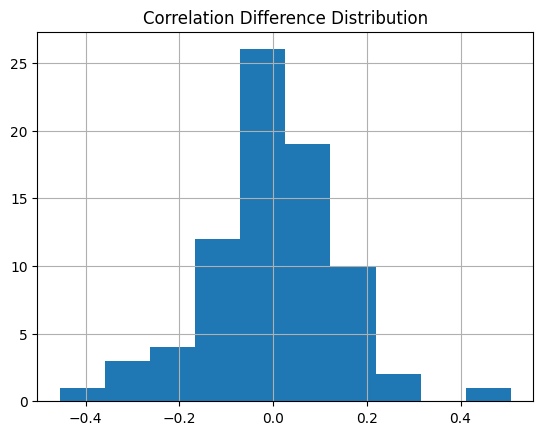

In [27]:
results = correlation_pred_performance(msvr, 
                                       pd.DataFrame(Xa_test_norm, index=Xa_test.index), 
                                       ya_test,
                                       pd.DataFrame(Xa_train_norm, index=Xa_train.index), 
                                       MIN_SCORE, name="MultiSVR")

In [28]:
diff_metrics.loc['M-SVR',:] = results['results']
diff_metrics.loc['M-SVR',:]

MSE       0.019476
MAE        0.10004
NMSE      0.796705
NMAE      0.904293
aRRMSE    0.831468
aCC       0.763911
Name: M-SVR, dtype: object

In [29]:
groups['msvr_assessor'] = results['groups']
groups['msvr_assessor']['test']

[['xgb', 'adab'],
 ['kan'],
 ['dtree'],
 ['gb', 'svm_rbf'],
 ['knn', 'svm_rbf', 'lr'],
 ['lr', 'svm_rbf', 'svm_poly'],
 ['mlp', 'sgd', 'svm_linear', 'svm_poly', 'lr'],
 ['mlp', 'rforest', 'svm_linear', 'svm_poly', 'lr']]

### Multi-Output Regressor 
(ST)

In [30]:
#mtr_params = getAssrParams(RandomForestRegressor, parameters, seed, False, 'estimator')
#
##mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)
#g_search = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), mtr_params, n_jobs=-1, verbose=True, scoring="neg_mean_absolute_error").fit(Xa_train, ya_train)
#print(g_search.best_params_)
#mor = g_search.best_estimator_

In [31]:
#study = OptunaStudy(Xa_train, ya_train, 100)
#study.search(MultiOutputRegressor)

In [25]:
single_tgt = MultiOutputRegressor(RandomForestRegressor(random_state=seed), 
                                  n_jobs=-1).fit(Xa_train, ya_train)

In [26]:
metrics_df.loc['ST',:] = assr_performance(single_tgt, Xa_test, ya_test, Xa_train, ya_train)

[TRAINING SET]
MSE: 0.0073
NMSE: 0.1190
MAE: 0.0644
NMAE: 0.3295
aRRMSE: 0.3450
aCC: 0.9724

[TESTING SET]
MSE: 0.0655
NMSE: 1.1659
MAE: 0.1995
NMAE: 1.0349
aRRMSE: 1.0793
aCC: 0.0854


#### Análise das correlações

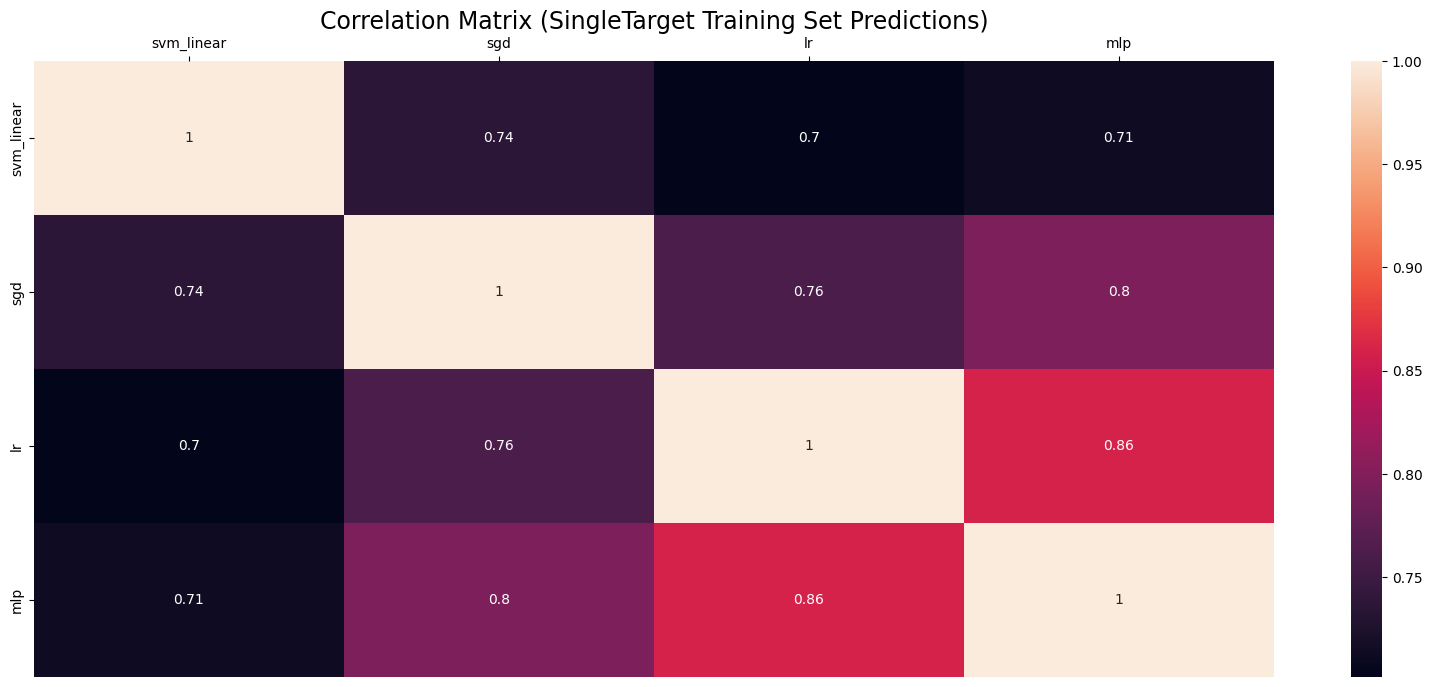

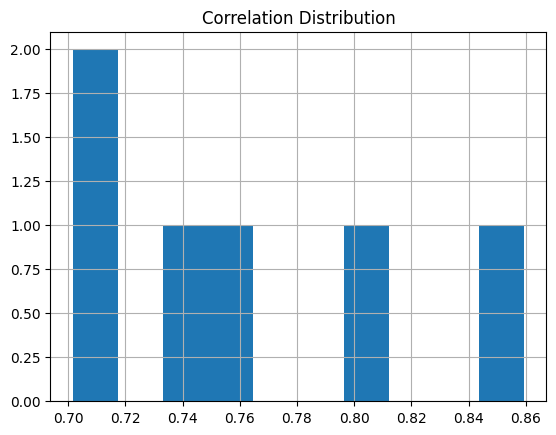

Training correlation distribution:
count    6.000000
mean     0.761254
std      0.059017
min      0.701680
25%      0.718477
50%      0.748712
75%      0.787682
max      0.859351
Name: corr, dtype: float64


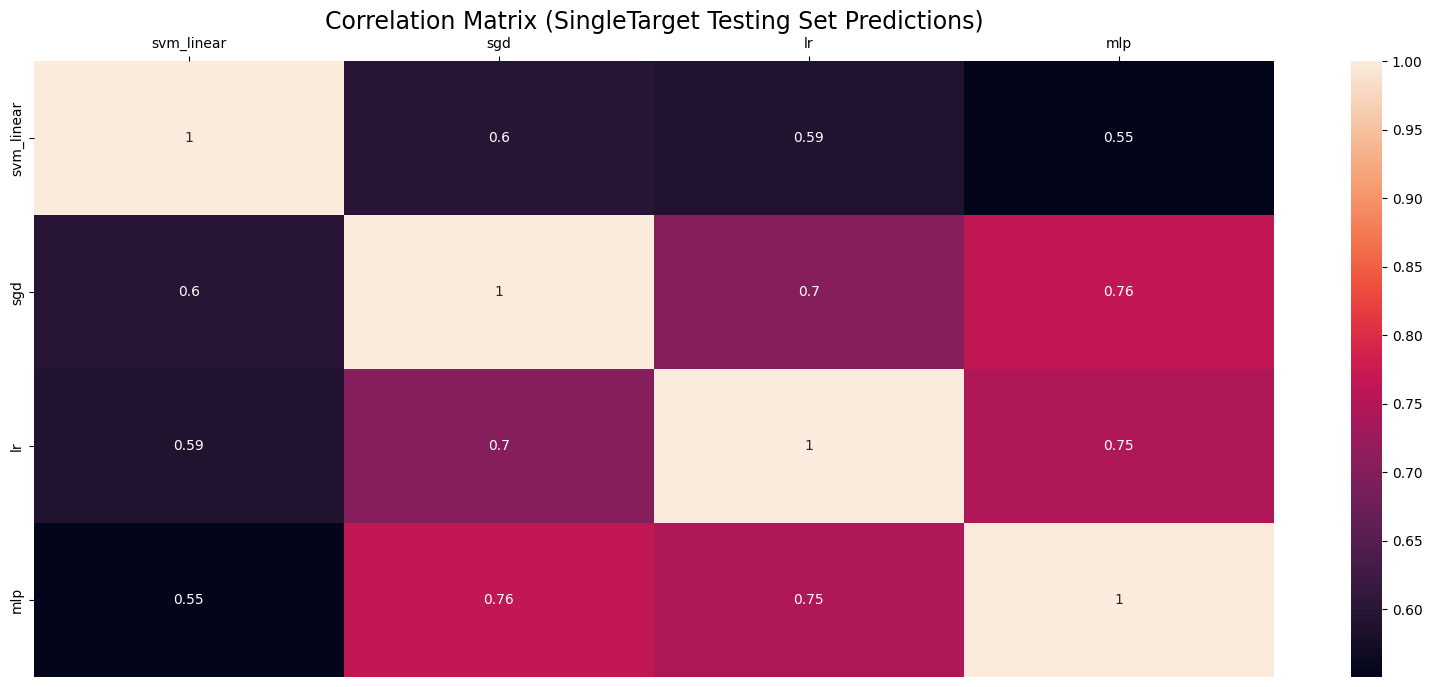

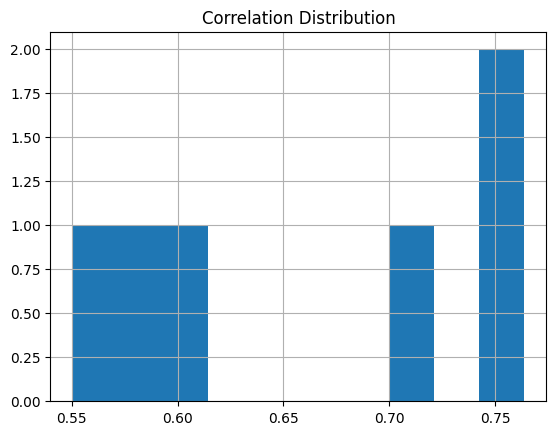

Testing correlation distribution:
count    6.000000
mean     0.658436
std      0.090249
min      0.550617
25%      0.591667
50%      0.650309
75%      0.735340
max      0.763580
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0151
NMSE: 0.1022
MAE: 1.3954
NMAE: 1.1346
aRRMSE: 1.1800
aCC: 0.9619


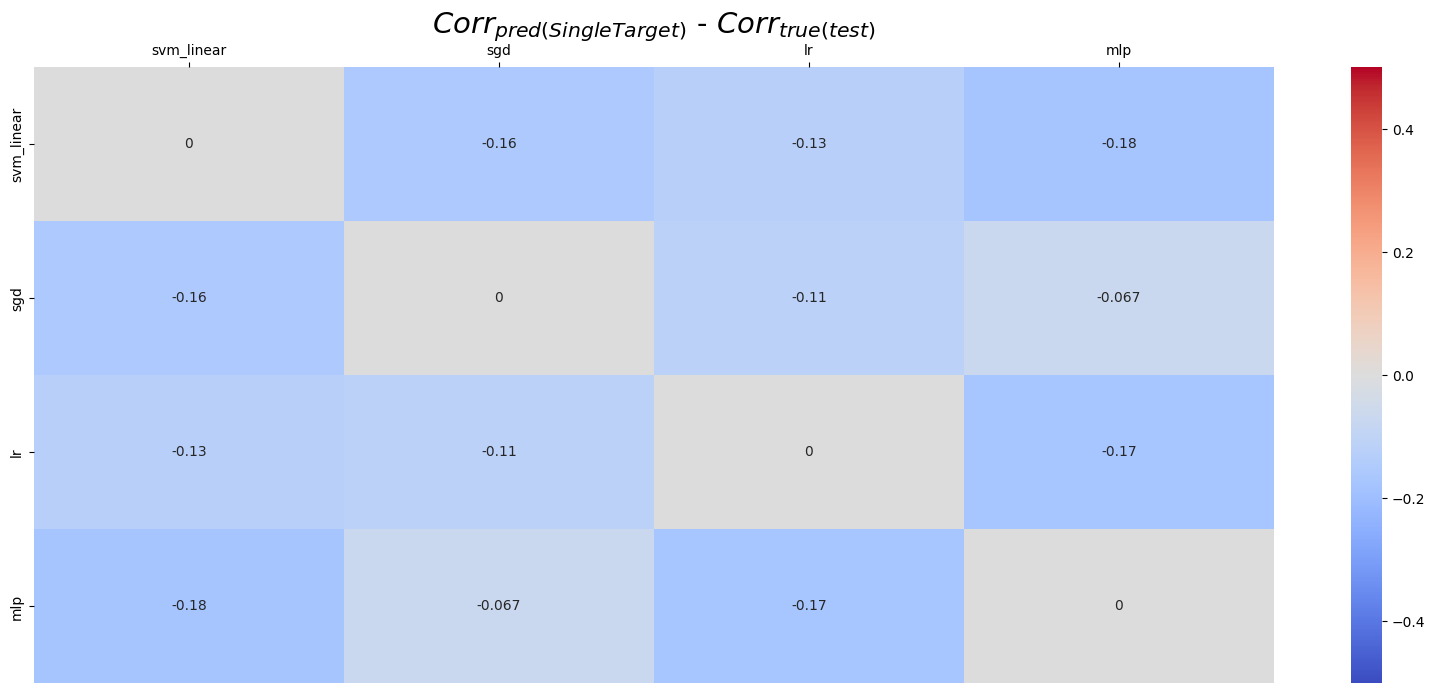

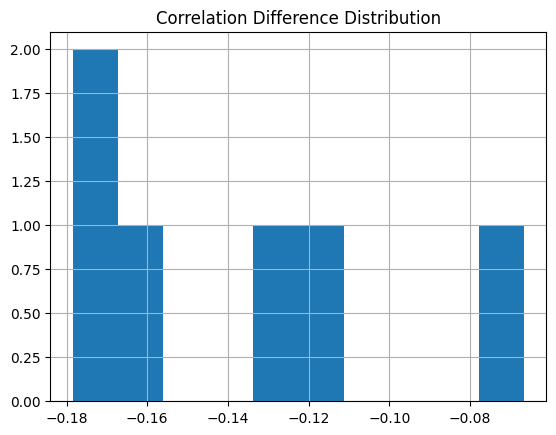

In [27]:
results = correlation_pred_performance(single_tgt, Xa_test, ya_test, Xa_train,
                                       MIN_SCORE, name="SingleTarget")

In [28]:
diff_metrics.loc['ST',:] = results['results']
diff_metrics.loc['ST',:]

MSE       0.015063
MAE       0.102238
NMSE      1.395396
NMAE      1.134611
aRRMSE    1.179994
aCC       0.961923
Name: ST, dtype: object

In [29]:
groups['st_assessor'] = results['groups']
groups['st_assessor']['test']

[['svm_linear'], ['sgd', 'mlp'], ['lr', 'mlp']]

## Grupais

In [37]:
#keys = list(groups.keys())
#for i in range(len(keys)):
#    for j in range(i+1, len(keys)):
#        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
#        count = 0
#        for g in groups[keys[i]]:
#            if(g in groups[keys[j]]):
#                print(g)
#                count += 1
#        print(f'Número de grupos em comum: {count}\n\n')

In [55]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['sgd', 'svm_linear']
total: 0.7617021276595745

['sgd', 'lr', 'mlp']
total: 0.8241134751773048



### Regressor Chain

In [31]:
#[RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
#                random_state=seed,
#                order='random', cv=5) for _ in range(num_chains)]

rcg = GroupedAssessor([RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
                                      random_state=seed,
                                      order='random', 
                                      cv=5) for _ in range(len(groups['true_assessor_train']))])

rcg.fit(Xa_train, ya_train, groups=groups['true_assessor_train'])

[TRAINING SET]
MSE: 0.0109
NMSE: 0.1904
MAE: 0.0792
NMAE: 0.4120
aRRMSE: 0.4311
aCC: 0.9328

[TESTING SET]
MSE: 0.0671
NMSE: 1.2047
MAE: 0.2044
NMAE: 1.0639
aRRMSE: 1.0973
aCC: 0.0658


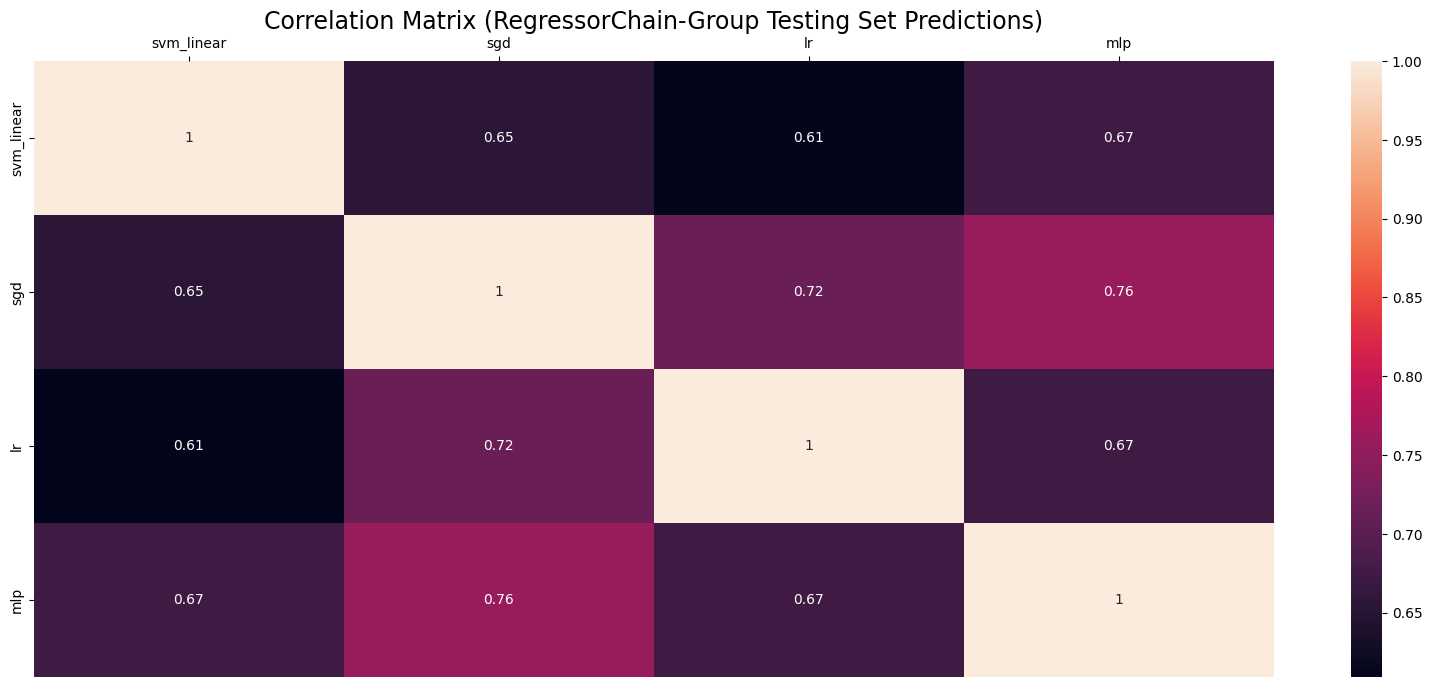

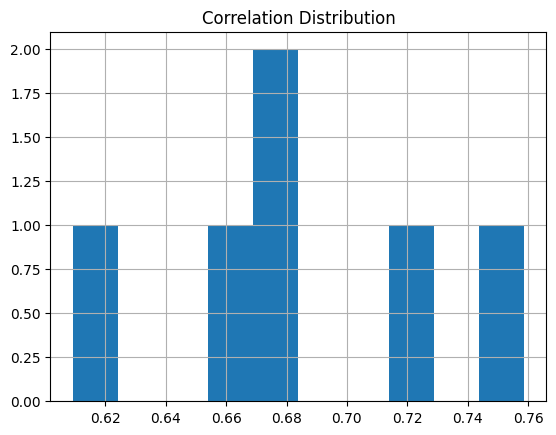

Testing correlation distribution:
count    6.000000
mean     0.681276
std      0.051322
min      0.609259
25%      0.659722
50%      0.674383
75%      0.705710
max      0.758642
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0125
NMSE: 0.0851
MAE: 1.1747
NMAE: 0.9466
aRRMSE: 1.0482
aCC: 0.8837


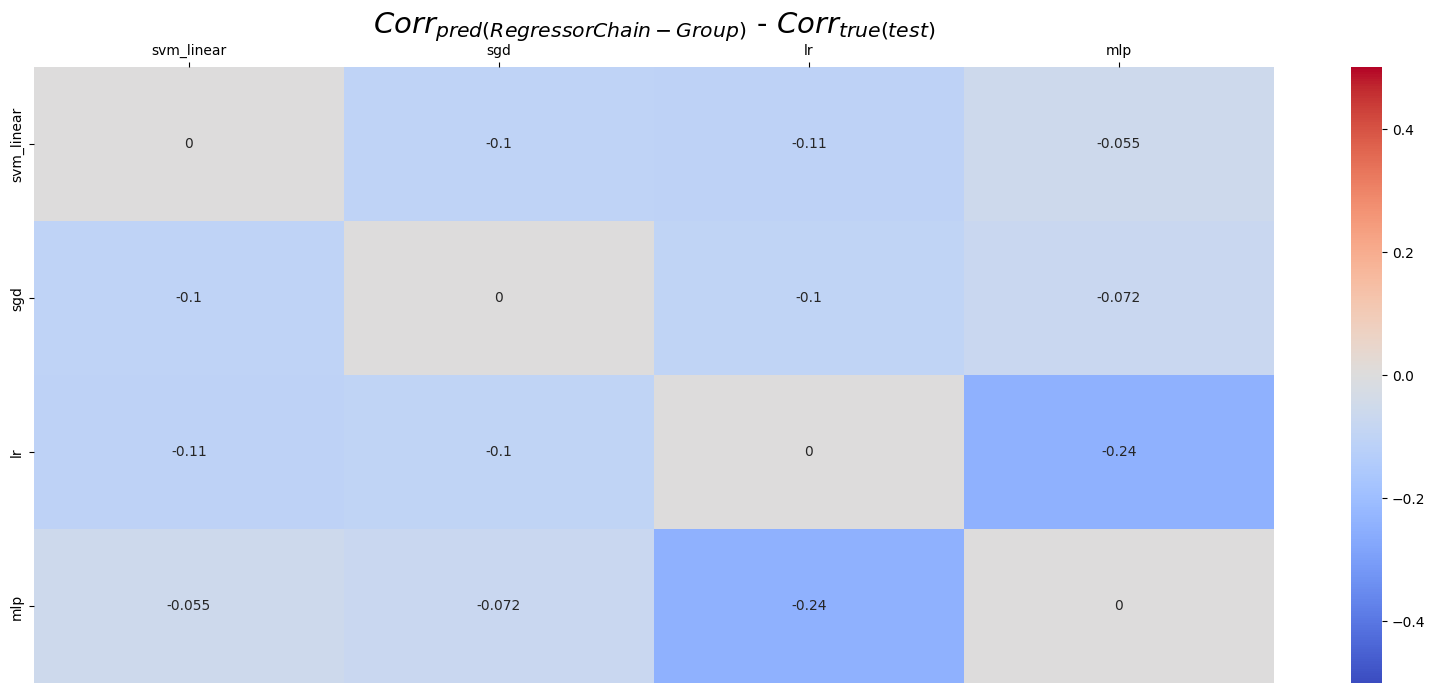

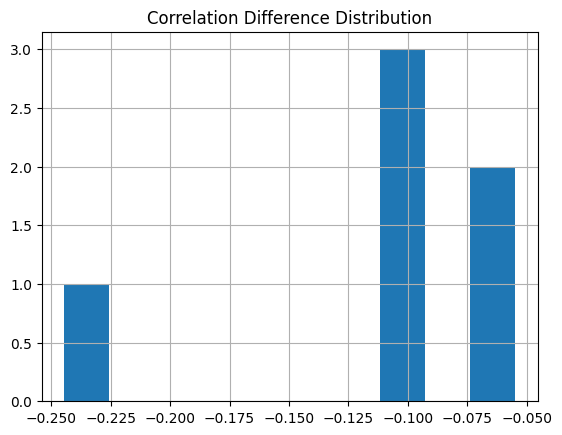

[['sgd', 'mlp'], ['svm_linear'], ['lr']]


In [32]:
metrics_df.loc['RC(g)',:] = assr_performance(rcg, Xa_test, ya_test, Xa_train, ya_train)

results = correlation_pred_performance(rcg, Xa_test, ya_test, min_score=MIN_SCORE, name="RegressorChain-Group")

diff_metrics.loc['RC(g)',:] = results['results']

groups['rcg_assessor'] = results['groups']
print(groups['rcg_assessor']['test'])

In [33]:
results

{'results': [0.012490616902911134,
  0.085108024691358,
  np.float64(1.1746899463953682),
  np.float64(0.946608520841237),
  np.float64(1.0481509741369417),
  np.float64(0.8837416979333199)],
 'groups': {'test': [['sgd', 'mlp'], ['svm_linear'], ['lr']]}}

### Ensemble of Regressor Chains

In [56]:
#rcg = GroupedAssessor(RegressorChain, model_names, random_state=seed)
#rcg.fit(Xa_train, ya_train, groups['true_assessor_train'], base_estimator=RandomForestRegressor(random_state=seed), 
#        random_state=seed, order='random', cv=5)

#rcg_plus = GroupedAssessor(VotingRegressor, model_names, random_state=seed,
#                           estimators=rc_ests, n_jobs=-1)

rcg_ac = f'RC[{num_chains}](g)'

rcg_plus = GroupedAssessor([GroupedAssessor([RegressorChain(
                                                base_estimator=RandomForestRegressor(random_state=seed),
                                                random_state=seed+i,
                                                order='random', cv=5) for i in range(num_chains)]
                                            ) for _ in range(len(groups['true_assessor_train']))])

rcg_plus.fit(Xa_train, ya_train, groups=groups['true_assessor_train'])

[TRAINING SET]
MSE: 0.0103
NMSE: 0.1687
MAE: 0.0760
NMAE: 0.3885
aRRMSE: 0.4099
aCC: 0.9541

[TESTING SET]
MSE: 0.0642
NMSE: 1.1527
MAE: 0.1997
NMAE: 1.0378
aRRMSE: 1.0735
aCC: 0.0877


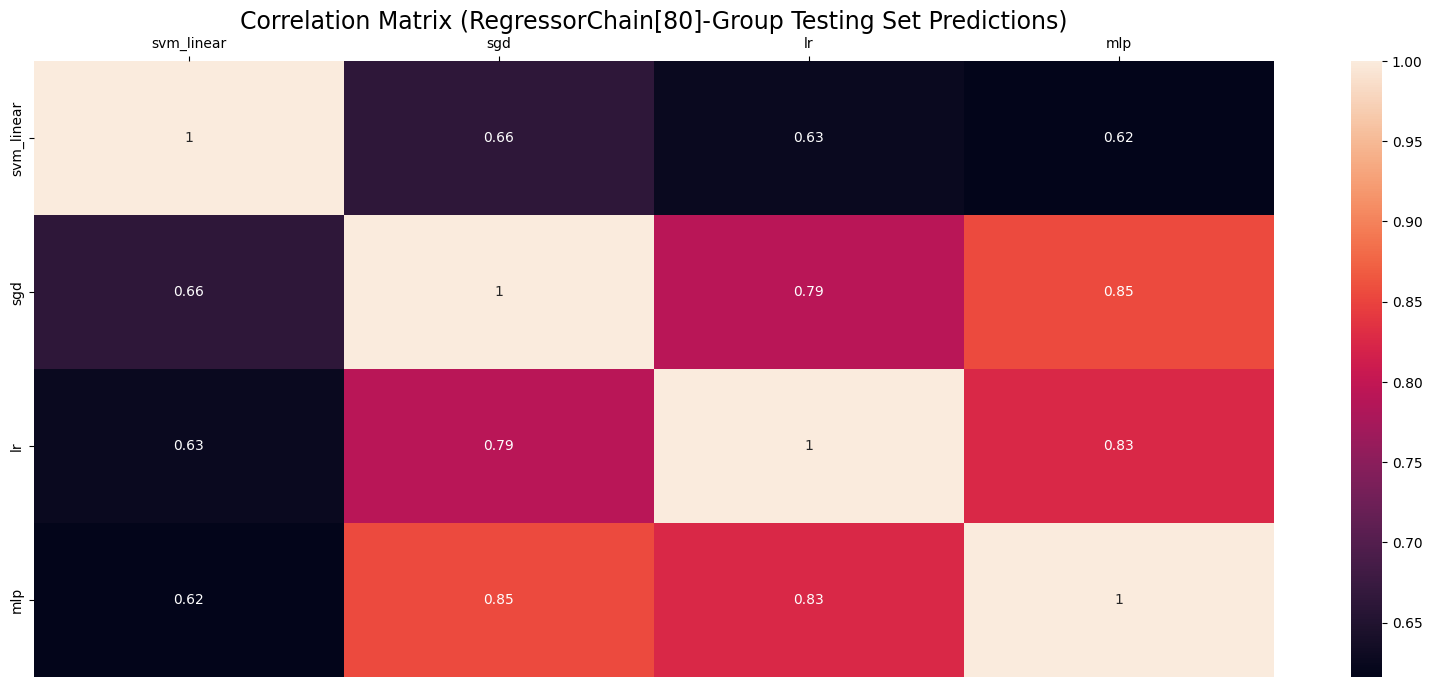

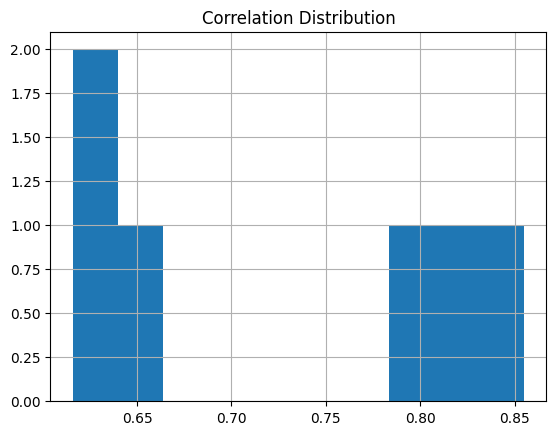

Testing correlation distribution:
count    6.000000
mean     0.729424
std      0.106213
min      0.616049
25%      0.635802
50%      0.726852
75%      0.816512
max      0.854938
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0050
NMSE: 0.0552
MAE: 0.4455
NMAE: 0.6042
aRRMSE: 0.6628
aCC: 0.9603


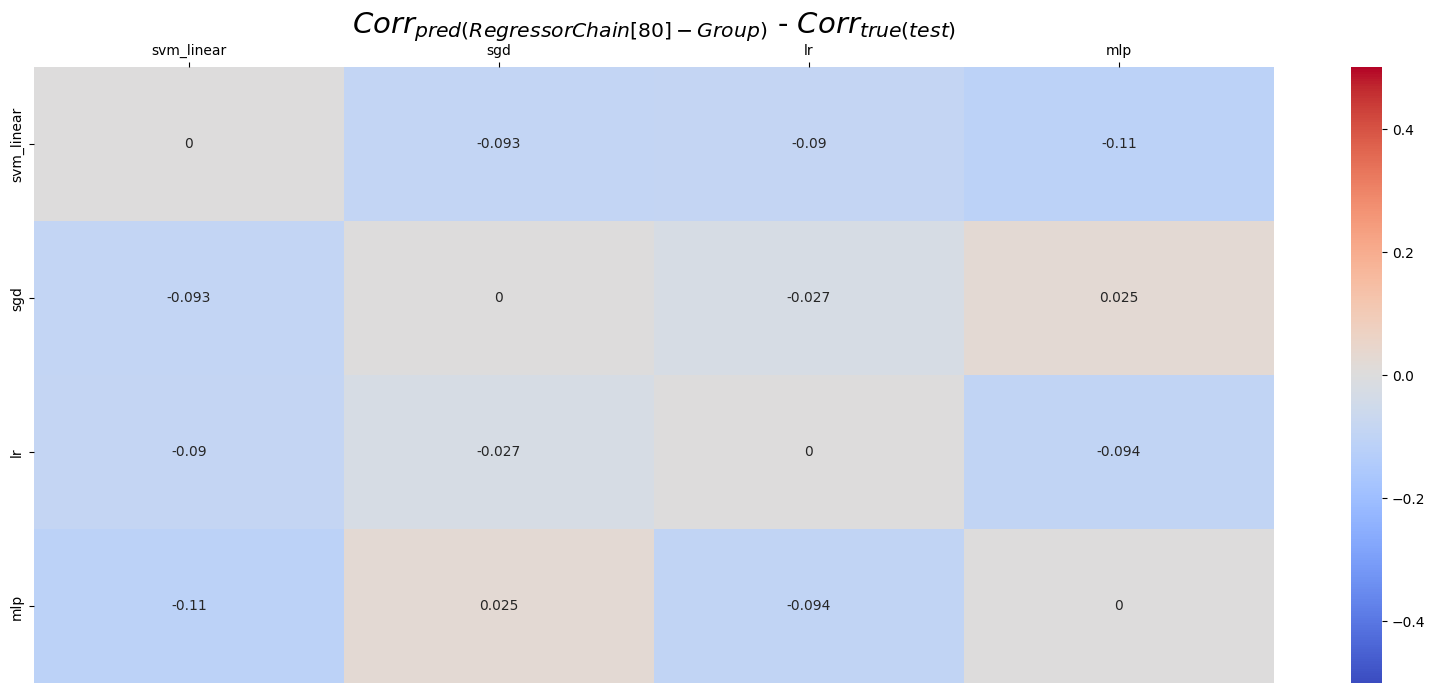

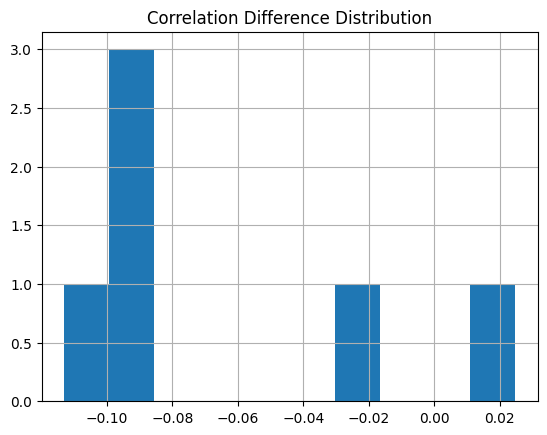

[['sgd', 'lr', 'mlp'], ['svm_linear']]


In [57]:
# keeping the concat because multiple numbers of chains could be recorded
#80chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

[TRAINING SET]
MSE: 0.0104
NMSE: 0.1693
MAE: 0.0762
NMAE: 0.3889
aRRMSE: 0.4105
aCC: 0.9542

[TESTING SET]
MSE: 0.0640
NMSE: 1.1480
MAE: 0.1994
NMAE: 1.0362
aRRMSE: 1.0713
aCC: 0.0897


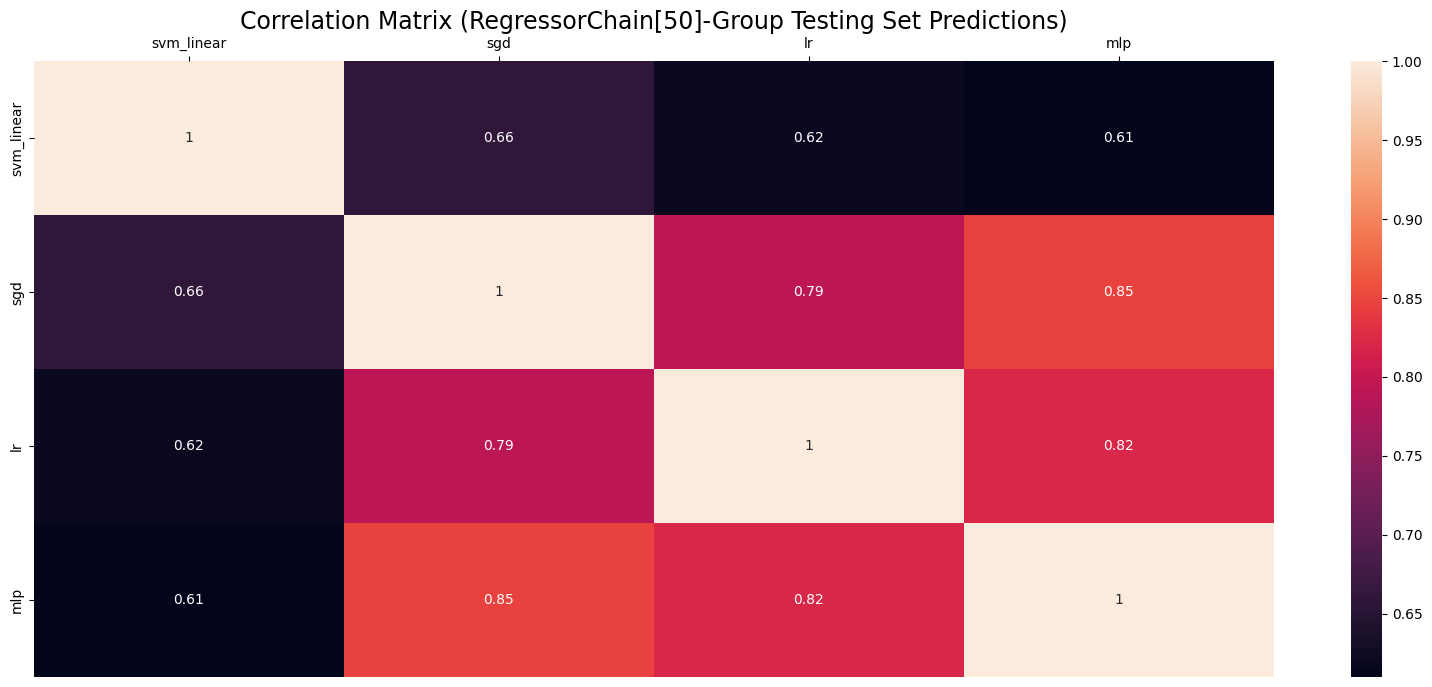

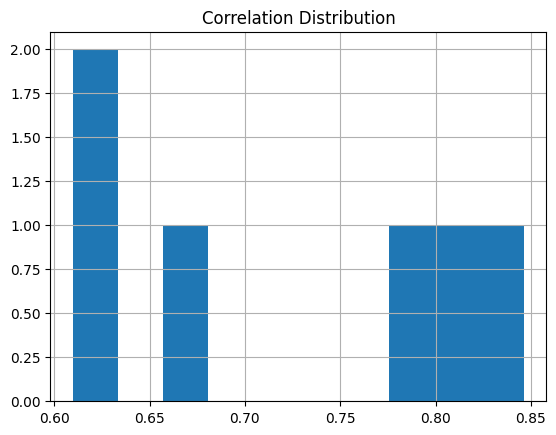

Testing correlation distribution:
count    6.000000
mean     0.724897
std      0.107066
min      0.609877
25%      0.629321
50%      0.726235
75%      0.814352
max      0.846296
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0054
NMSE: 0.0564
MAE: 0.4853
NMAE: 0.6153
aRRMSE: 0.6908
aCC: 0.9622


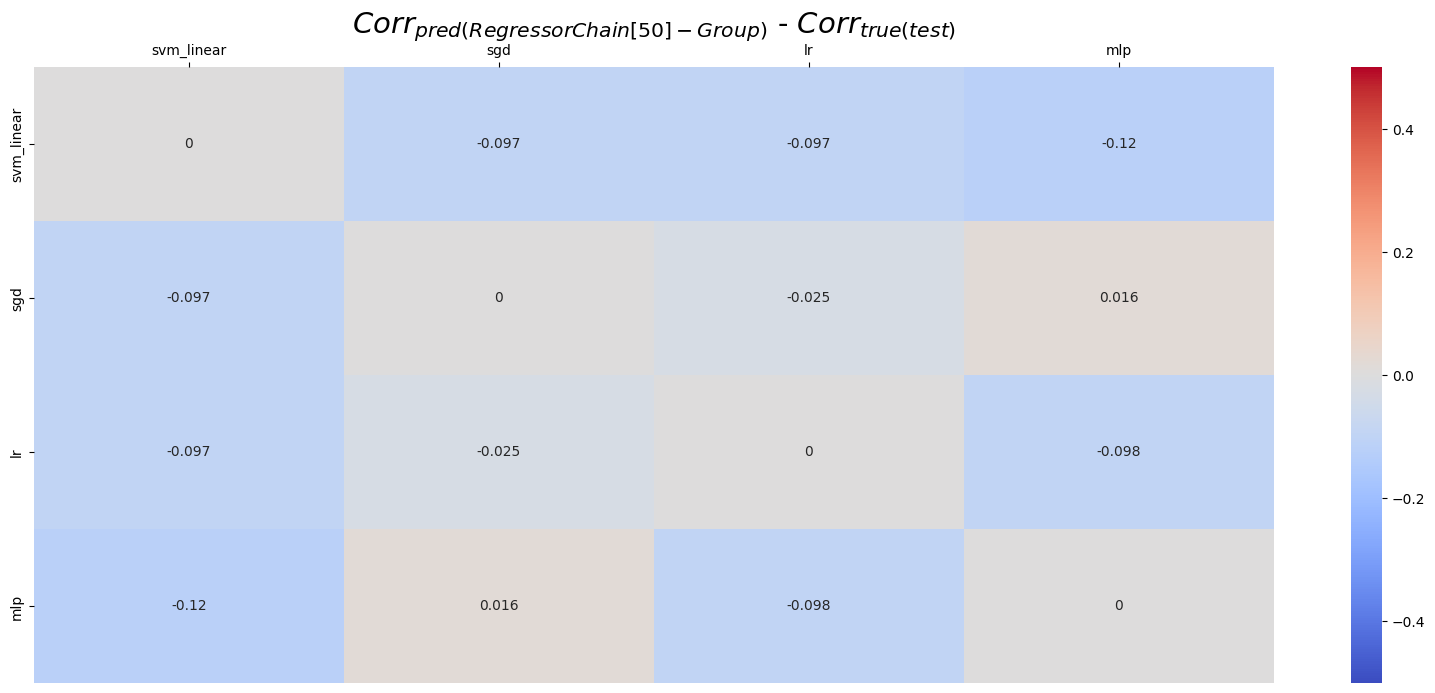

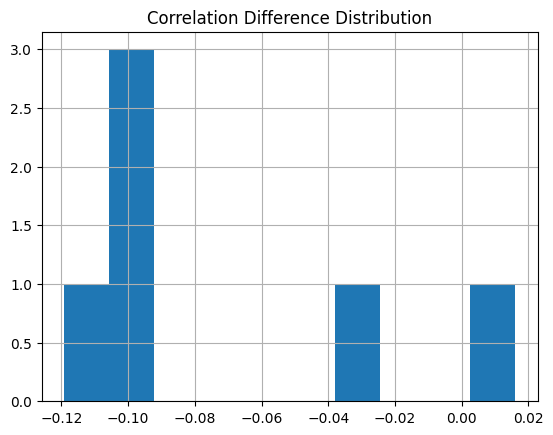

[['sgd', 'lr', 'mlp'], ['svm_linear']]


In [49]:
# keeping the concat because multiple numbers of chains could be recorded
#50chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

[TRAINING SET]
MSE: 0.0105
NMSE: 0.1689
MAE: 0.0764
NMAE: 0.3884
aRRMSE: 0.4099
aCC: 0.9550

[TESTING SET]
MSE: 0.0635
NMSE: 1.1408
MAE: 0.1988
NMAE: 1.0328
aRRMSE: 1.0680
aCC: 0.0934


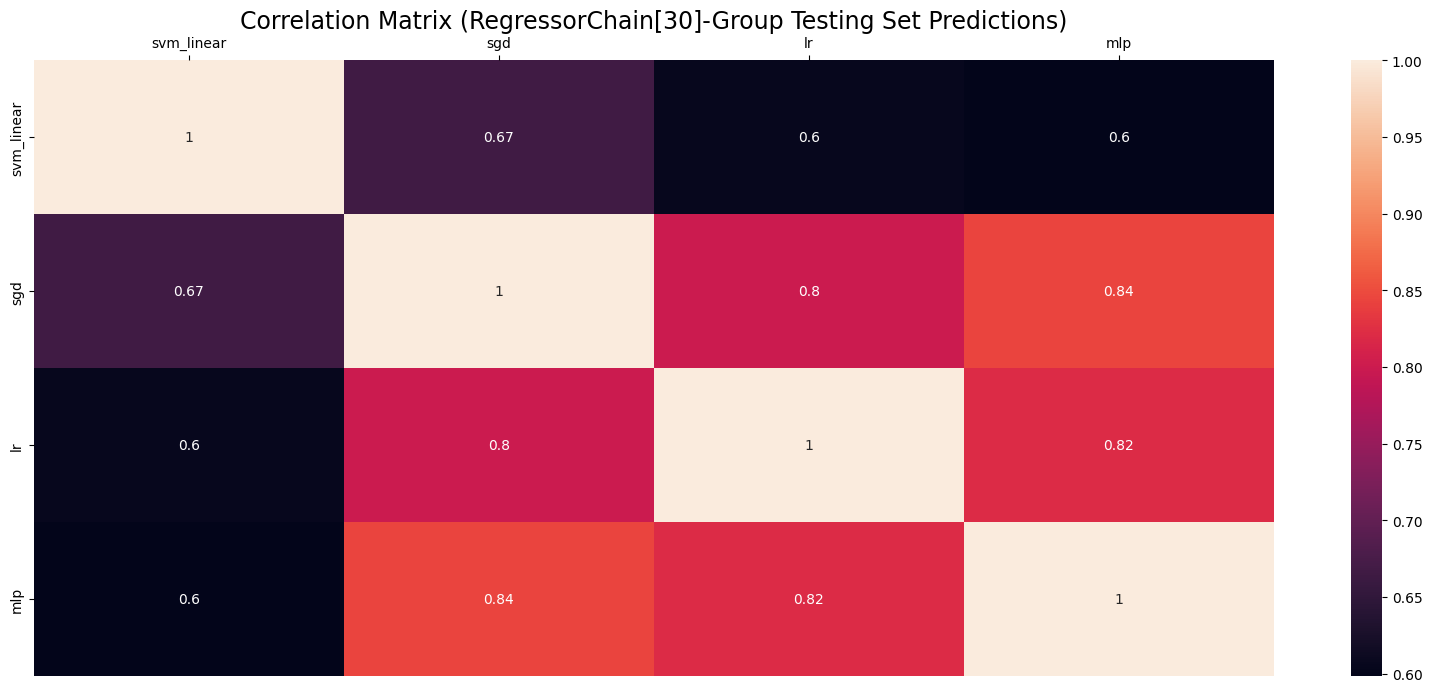

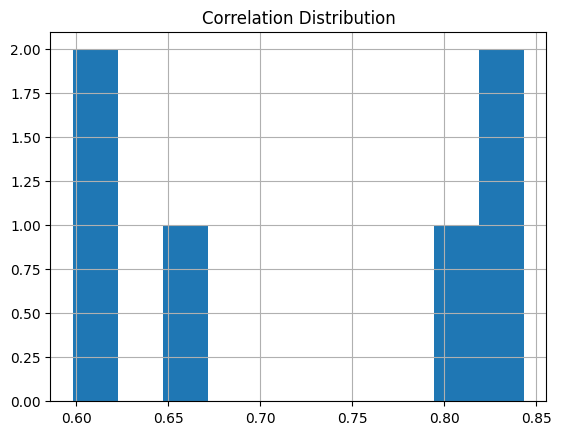

Testing correlation distribution:
count    6.000000
mean     0.722222
std      0.112002
min      0.598148
25%      0.620216
50%      0.733333
75%      0.815432
max      0.843210
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0060
NMSE: 0.0576
MAE: 0.5297
NMAE: 0.6248
aRRMSE: 0.7167
aCC: 0.9619


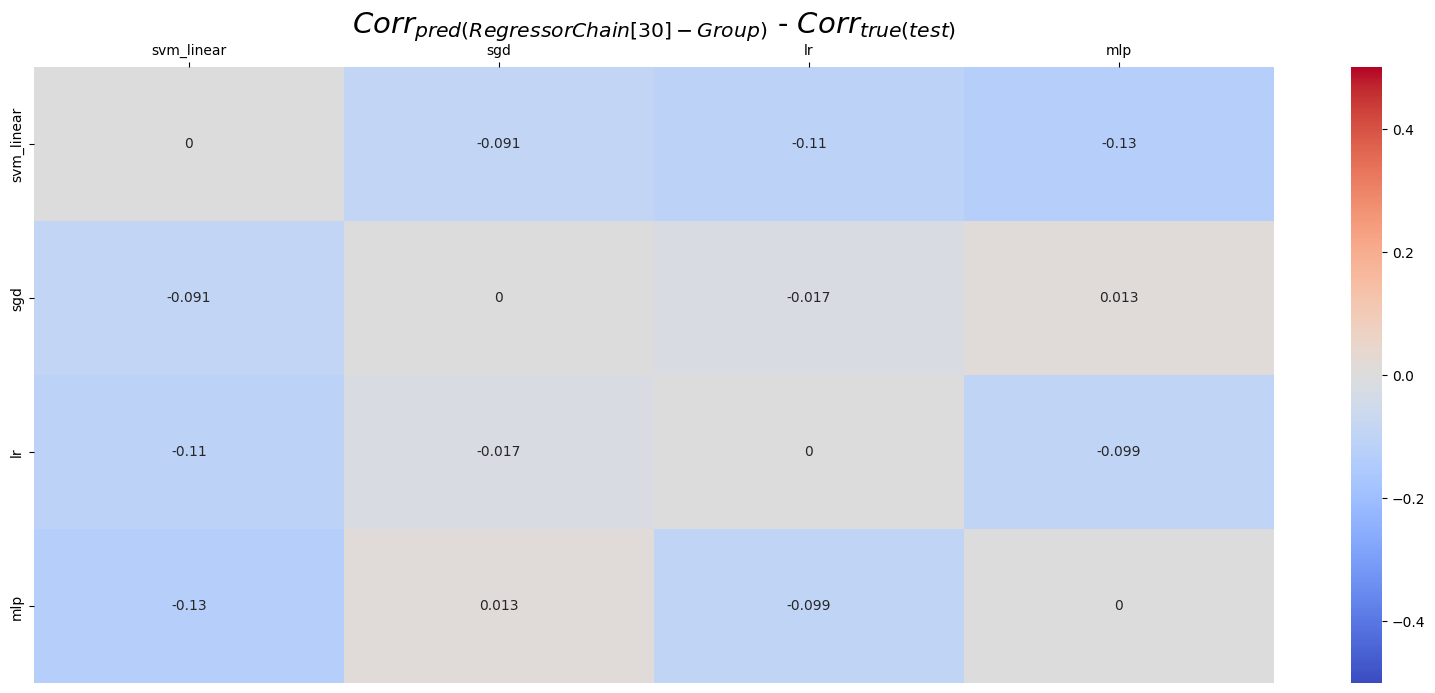

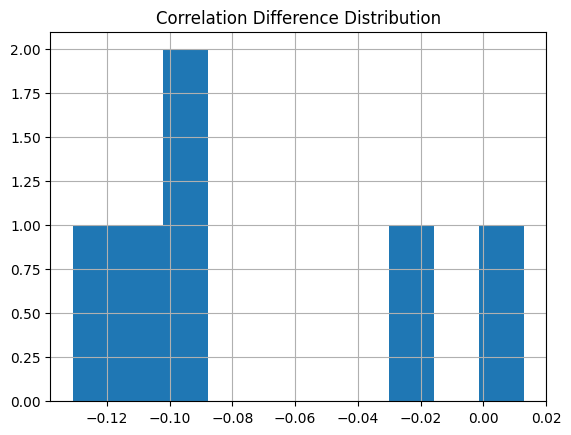

[['sgd', 'lr', 'mlp'], ['svm_linear']]


In [42]:
# keeping the concat because multiple numbers of chains could be recorded
# 30chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

[TRAINING SET]
MSE: 0.0103
NMSE: 0.1695
MAE: 0.0762
NMAE: 0.3896
aRRMSE: 0.4106
aCC: 0.9535

[TESTING SET]
MSE: 0.0642
NMSE: 1.1517
MAE: 0.1998
NMAE: 1.0387
aRRMSE: 1.0730
aCC: 0.0878


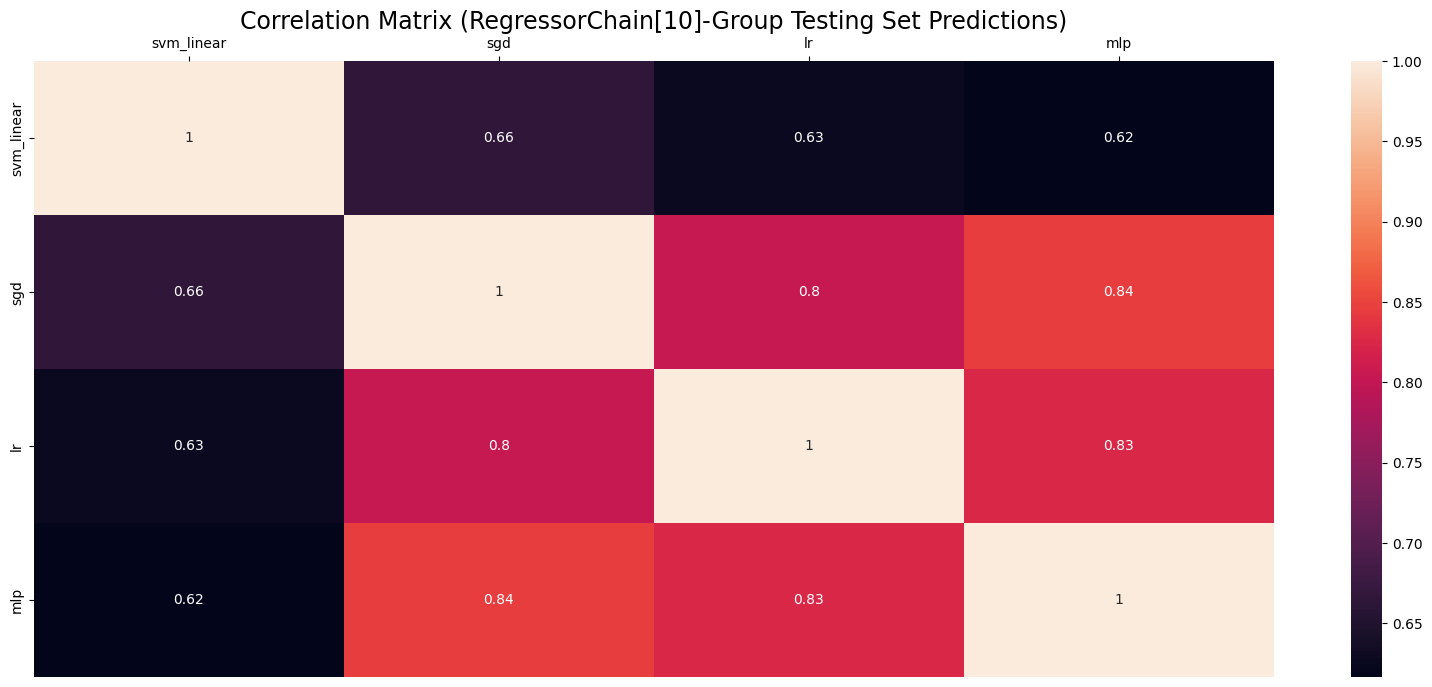

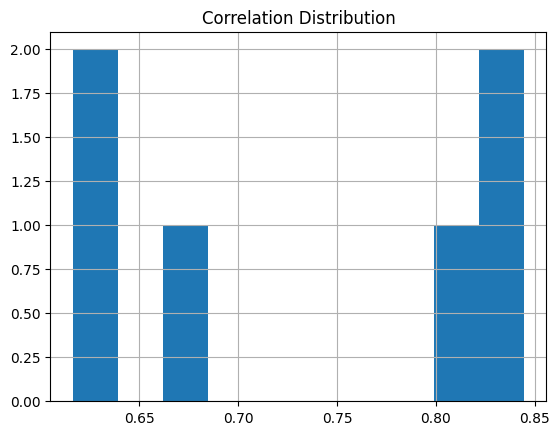

Testing correlation distribution:
count    6.000000
mean     0.730453
std      0.105236
min      0.616667
25%      0.636574
50%      0.734568
75%      0.820062
max      0.844444
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0048
NMSE: 0.0518
MAE: 0.4270
NMAE: 0.5636
aRRMSE: 0.6474
aCC: 0.9623


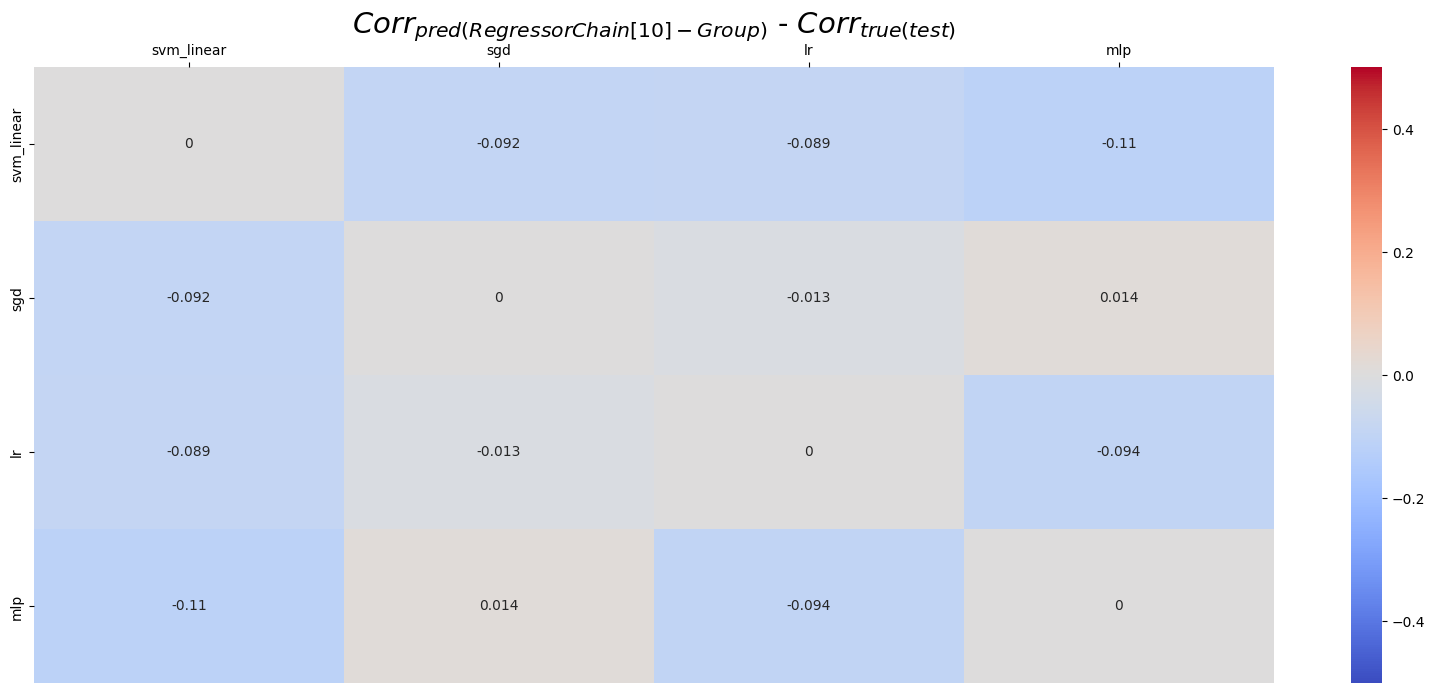

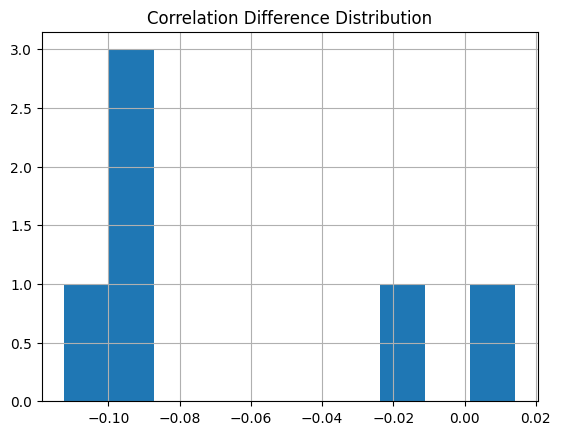

[['sgd', 'lr', 'mlp'], ['svm_linear']]


In [35]:
# keeping the concat because multiple numbers of chains could be recorded
# 10chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

### Multi-Output SVR

In [ ]:
msvrg = GroupedAssessor([MSVR() for _ in range(len(groups['true_assessor_train']))])

msvrg.fit(Xa_train_norm, ya_train, groups['true_assessor_train'])

c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:74: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u
c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:74: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u


[TRAINING SET]
MSE: 0.0244
NMSE: 0.5570
MAE: 0.1139
NMAE: 0.7091
aRRMSE: 0.7297
aCC: 0.7728

[TESTING SET]
MSE: 0.0530
NMSE: 1.3262
MAE: 0.1608
NMAE: 1.0029
aRRMSE: 1.1078
aCC: 0.3063


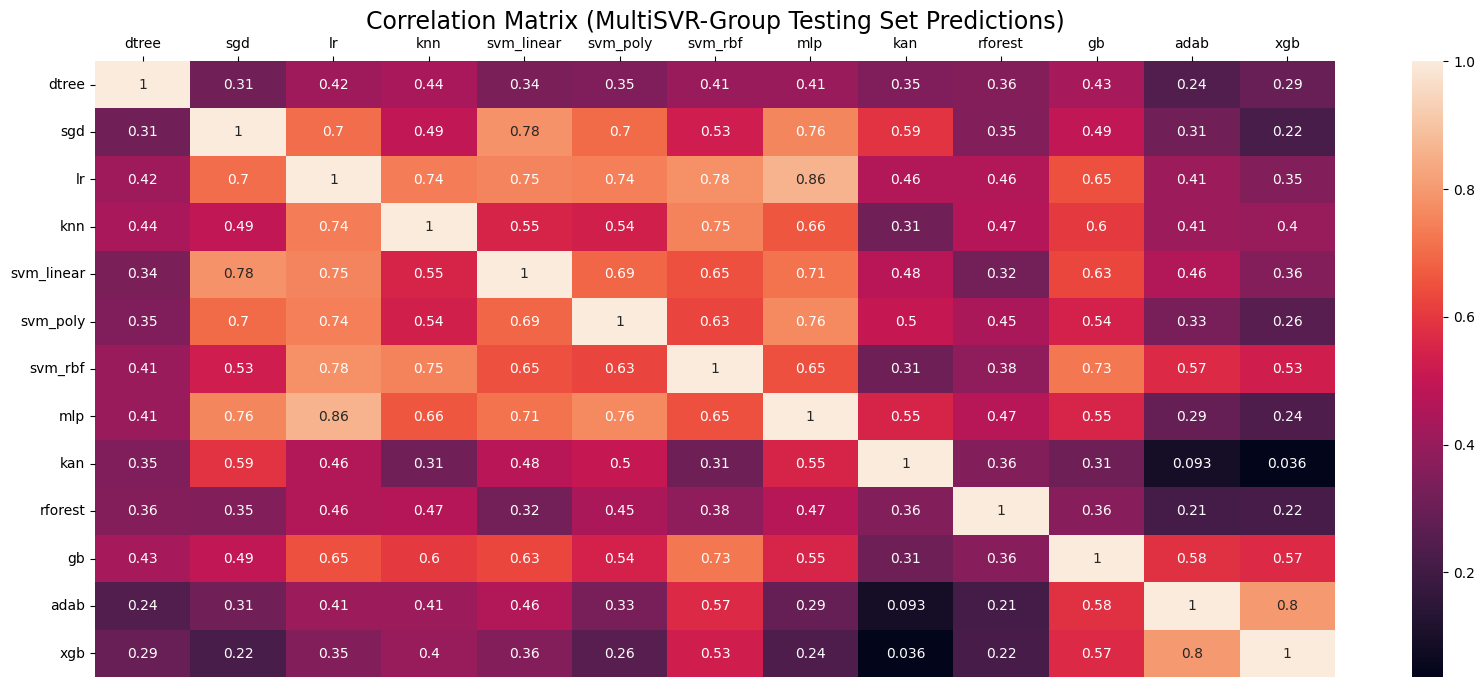

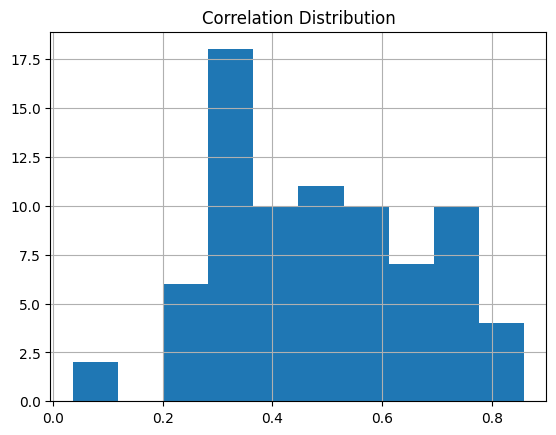

Testing correlation distribution:
count    78.000000
mean      0.484077
std       0.181417
min       0.036420
25%       0.350000
50%       0.465123
75%       0.629475
max       0.858642
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0238
NMSE: 0.1114
MAE: 1.0027
NMAE: 1.0256
aRRMSE: 0.9103
aCC: 0.7865


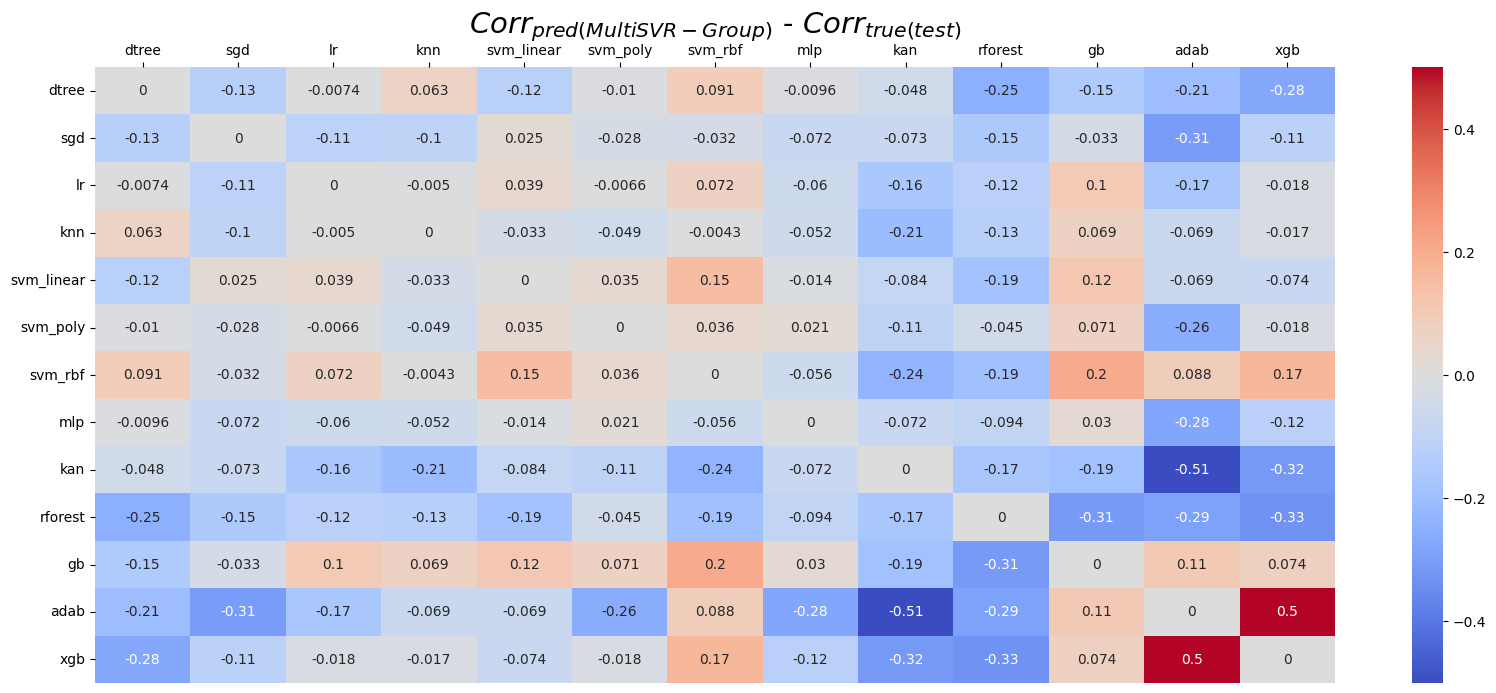

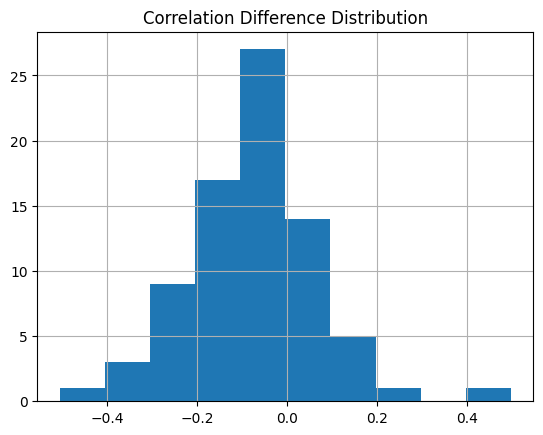

[['xgb', 'adab'], ['rforest'], ['sgd', 'svm_linear'], ['sgd', 'mlp'], ['kan'], ['dtree'], ['gb', 'svm_rbf'], ['knn', 'svm_rbf', 'lr'], ['lr', 'mlp', 'svm_poly'], ['svm_linear', 'lr']]


In [43]:
metrics_df.loc['M-SVR(g)',:] = assr_performance(msvrg, Xa_test_norm, ya_test, Xa_train_norm, ya_train)

results = correlation_pred_performance(msvrg, pd.DataFrame(Xa_test_norm, index=Xa_test.index), 
                                       ya_test, min_score=MIN_SCORE, name="MultiSVR-Group")

diff_metrics.loc['M-SVR(g)',:] = results['results']

groups['msvrg_assessor'] = results['groups']
print(groups['msvrg_assessor']['test'])

### Multi-Target Random Forest Regressor

In [ ]:
mrfg = GroupedAssessor([RandomForestRegressor(random_state=seed) for _ in range(len(groups['true_assessor_train']))])

mrfg.fit(Xa_train, ya_train, groups['true_assessor_train'])

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

[TRAINING SET]
MSE: 0.0061
NMSE: 0.1151
MAE: 0.0542
NMAE: 0.3147
aRRMSE: 0.3391
aCC: 0.9734

[TESTING SET]
MSE: 0.0557
NMSE: 1.0462
MAE: 0.1659
NMAE: 0.9410
aRRMSE: 1.0215
aCC: 0.1877


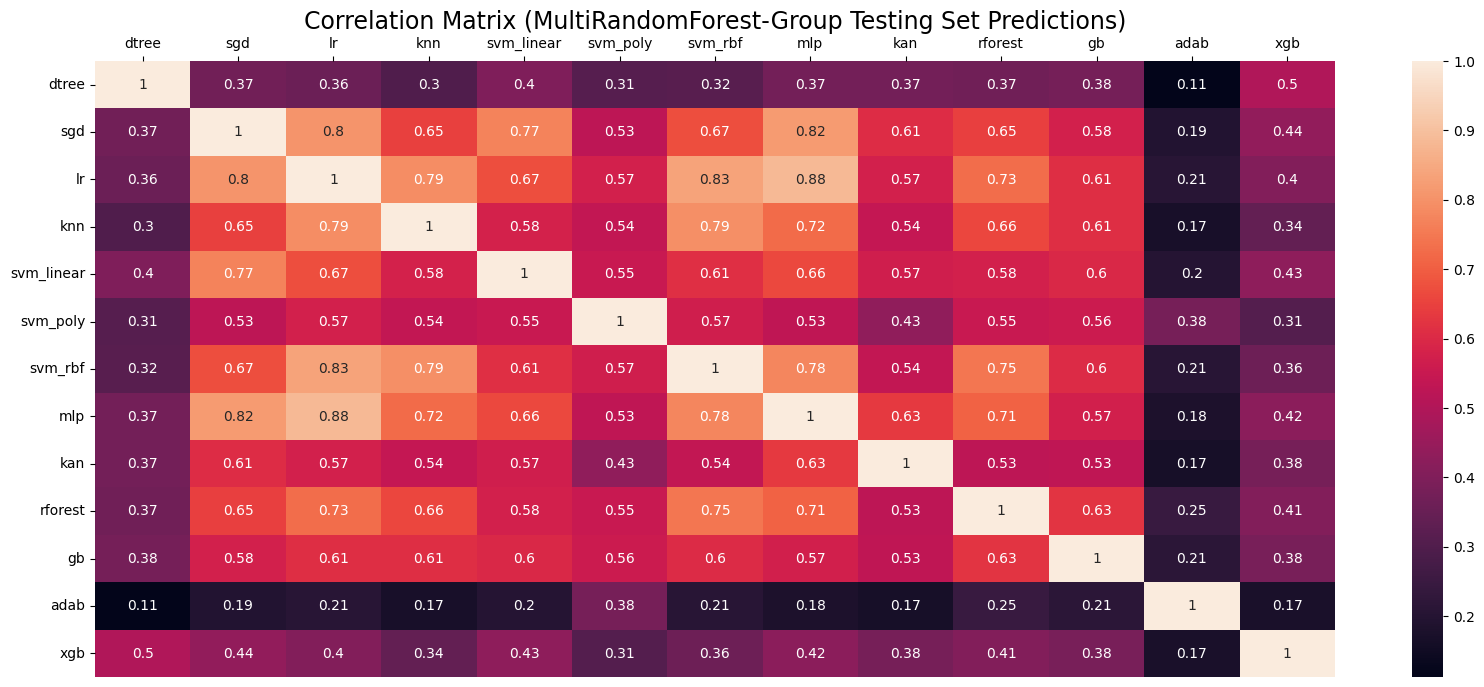

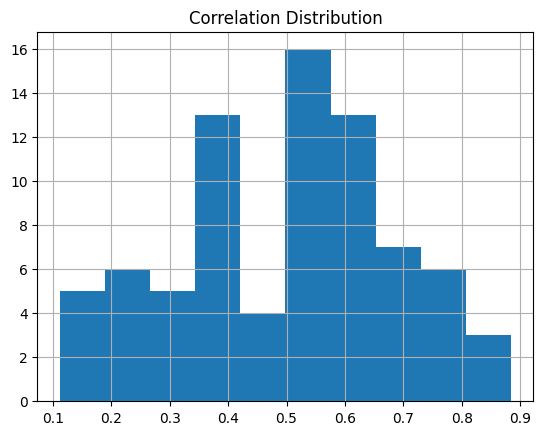

Testing correlation distribution:
count    78.000000
mean      0.500335
std       0.189302
min       0.112346
25%       0.372068
50%       0.538046
75%       0.622531
max       0.883951
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0213
NMSE: 0.0999
MAE: 0.8669
NMAE: 0.8953
aRRMSE: 0.8558
aCC: 0.8111


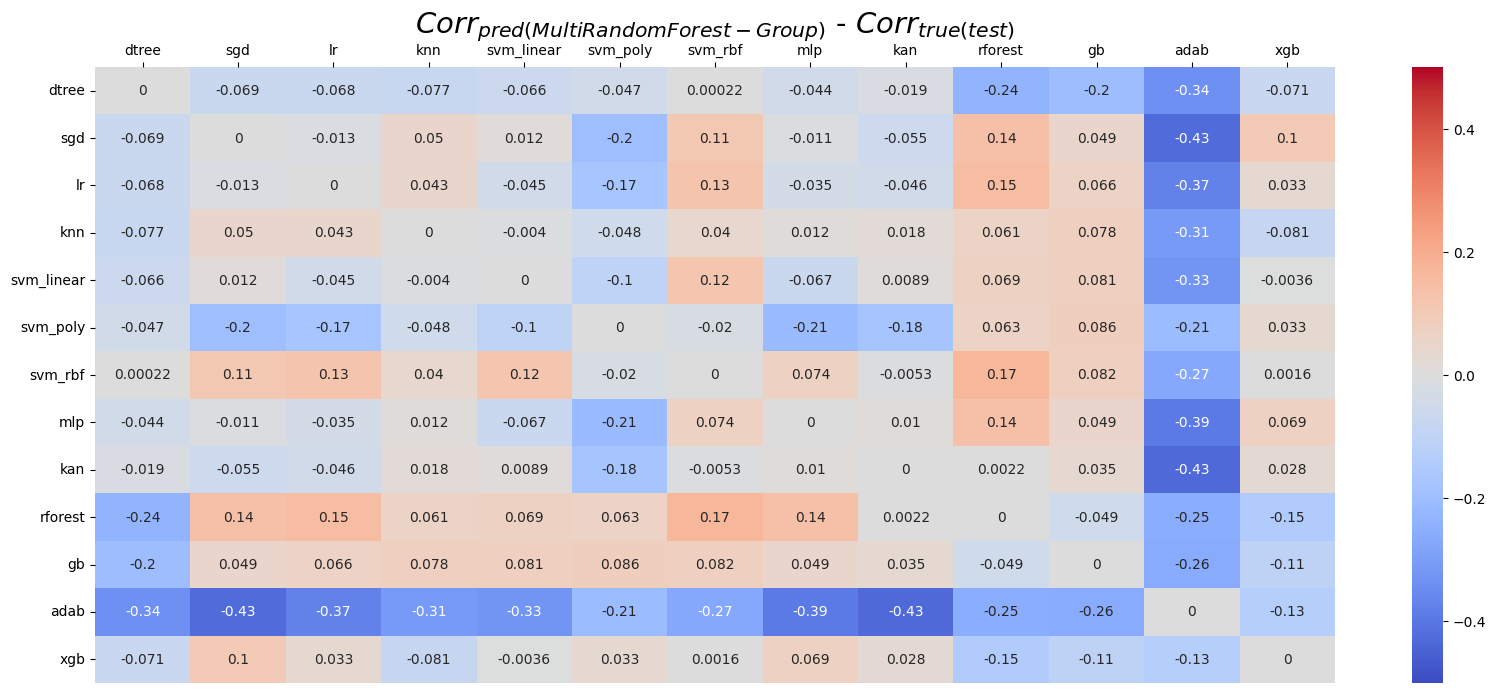

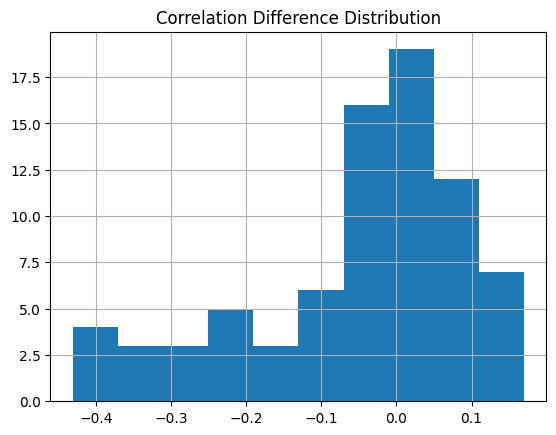

[['adab'], ['kan'], ['sgd', 'svm_linear'], ['dtree'], ['svm_poly'], ['gb'], ['xgb'], ['sgd', 'mlp', 'lr'], ['knn', 'svm_rbf', 'lr'], ['svm_rbf', 'mlp', 'lr'], ['svm_rbf', 'rforest', 'lr']]


In [45]:
metrics_df.loc['MRT(g)',:] = assr_performance(mrfg, Xa_test, ya_test, Xa_train, ya_train)

results = correlation_pred_performance(mrfg, Xa_test, ya_test, min_score=MIN_SCORE, name="MultiRandomForest-Group")

diff_metrics.loc['MRT(g)',:] = results['results']

groups['mrfg_assessor'] = results['groups']
print(groups['mrfg_assessor']['test'])

In [46]:
#keys = list(groups.keys())
#OBJV = len(groups['true_assessor_test'])
#for i in range(len(keys)):
#    if('test' in keys[i] and keys[i] != 'true_assessor_test'):
#        print(f'{keys[i]}({len(groups[keys[i]])}) & true_assessor_test({OBJV}):')
#        count = 0
#        for g in groups[keys[i]]:
#            if(g in groups['true_assessor_test']):
#                print(g)
#                count += 1
#        print(f'Número de grupos em comum: {count}\n\n')

## Análises

In [58]:
results_df = metrics_df.dropna().copy()
results_df = results_df.reset_index()

results_df

Assessor       Model       MSE       MAE      NMSE      NMAE    aRRMSE  \
0          ST  svm_linear  0.043766  1.086575  0.163649  1.007816  1.042389   
1          ST         sgd  0.095636  1.269838  0.245834  1.084573  1.126871   
2          ST          lr  0.046417   1.11667  0.171636  1.022398  1.056726   
3          ST         mlp  0.076306  1.190682  0.216691  1.024715  1.091184   
4          RC  svm_linear  0.044838  1.113201  0.171553  1.056493  1.055084   
5          RC         sgd  0.083711  1.111504  0.238313  1.051391  1.054279   
6          RC          lr  0.046417   1.11667  0.171636  1.022398  1.056726   
7          RC         mlp    0.0703  1.096962   0.21217  1.003335   1.04736   
8       RC(g)  svm_linear  0.045639  1.133077  0.169581  1.044348  1.064461   
9       RC(g)         sgd  0.095636  1.269838  0.245834  1.084573  1.126871   
10      RC(g)          lr  0.050775  1.221519  0.183236  1.091493  1.105223   
11      RC(g)         mlp  0.076536  1.194278  0.218912  1.035216   1.09283   
12     RC[10]  svm_linear  0.044308  1.100046  0.167954  1.034332  1.048831   
13     RC[10]         sgd  0.086997  1.155122  0.240881  1.062721  1.074766   
14     RC[10]          lr  0.045863  1.103345  0.169471  1.009498  1.050402   
15     RC[10]         mlp  0.072008  1.123624  0.214619  1.014917  1.060011   
16  RC[10](g)  svm_linear   0.04462   1.10779  0.166504    1.0254  1.052516   
17  RC[10](g)         sgd  0.091512  1.215072  0.243291  1.073354  1.102303   
18  RC[10](g)          lr  0.047685  1.147174  0.174193  1.037625  1.071062   
19  RC[10](g)         mlp  0.072854  1.136812  0.215329  1.018273  1.066214   
20     RC[30]  svm_linear  0.044423  1.102886  0.168119  1.035348  1.050184   
21     RC[30]         sgd   0.08792  1.167379  0.241404  1.065031  1.080453   
22     RC[30]          lr  0.045929  1.104934  0.169614  1.010348  1.051159   
23     RC[30]         mlp   0.07203  1.123965  0.215115   1.01726  1.060172   
24  RC[30](g)  svm_linear  0.044552  1.106085  0.166289  1.024078  1.051706   
25  RC[30](g)         sgd  0.090291  1.198866  0.242611  1.070352  1.094927   
26  RC[30](g)          lr  0.046969  1.129946  0.171486  1.021502  1.062989   
27  RC[30](g)         mlp  0.072305  1.128249  0.214701  1.015304  1.062191   
28     RC[50]  svm_linear   0.04431  1.100097  0.167523  1.031676  1.048855   
29     RC[50]         sgd  0.087806  1.165872  0.241295  1.064547  1.079756   
30     RC[50]          lr  0.045882  1.103797  0.169265   1.00827  1.050617   
31     RC[50]         mlp  0.071515  1.115924  0.214722  1.015405  1.056373   
32  RC[50](g)  svm_linear  0.044706  1.109917  0.166761  1.026987  1.053526   
33  RC[50](g)         sgd  0.091164  1.210454  0.243123  1.072614  1.100207   
34  RC[50](g)          lr  0.047273  1.137279  0.172334  1.026555  1.066433   
35  RC[50](g)         mlp  0.072703  1.134469  0.215441  1.018804  1.065114   
36     RC[80]  svm_linear  0.044243  1.098416  0.167503  1.031554  1.048053   
37     RC[80]         sgd   0.08699  1.155029  0.240877  1.062702  1.074723   
38     RC[80]          lr  0.045572  1.096345  0.168456  1.003451  1.047065   
39     RC[80]         mlp  0.071258  1.111921  0.214158  1.012735  1.054477   
40  RC[80](g)  svm_linear  0.044756  1.111153  0.166906  1.027879  1.054112   
41  RC[80](g)         sgd  0.091576  1.215933  0.243328  1.073516  1.102694   
42  RC[80](g)          lr  0.047506  1.142887  0.172708  1.028783  1.069059   
43  RC[80](g)         mlp  0.073115  1.140886   0.21594  1.021163  1.068123   

         aCC  
0   0.138563  
1   0.008631  
2   0.119061  
3   0.075473  
4   0.086545  
5    0.06708  
6   0.119061  
7   0.126748  
8   0.127189  
9   0.008631  
10   0.02116  
11   0.10636  
12  0.104949  
13  0.048889  
14  0.110855  
15  0.097641  
16  0.133327  
17  0.034129  
18  0.084044  
19  0.099607  
20  0.104115  
21  0.045656  
22  0.107571  
23  0.094295  
24  0.133757  
25  0.043943  
26  0.100755  
27   0.09514  
28  0.108949  

In [59]:
diff_results = diff_metrics.dropna().reset_index(names=['Assessor'])
diff_results.to_csv(f'data/{DIR}/results_diff_RC.csv')
diff_results

Assessor       MSE       MAE      NMSE      NMAE    aRRMSE       aCC
0          ST  0.015063  0.102238  1.395396  1.134611  1.179994  0.961923
1          RC  0.026119  0.133488   2.47433  1.499483  1.547492  0.966132
2       RC(g)  0.012491  0.085108   1.17469  0.946609  1.048151  0.883742
3      RC[10]  0.003387  0.041358  0.311157  0.453442  0.551981  0.968499
4   RC[10](g)  0.004769  0.051775  0.427014  0.563569  0.647389  0.962342
5      RC[30]  0.002216  0.034182  0.204425  0.377098  0.448247  0.961041
6   RC[30](g)  0.005988  0.057639   0.52971  0.624791  0.716653  0.961942
7      RC[50]    0.0018  0.034028   0.16629  0.377274  0.405447  0.967595
8   RC[50](g)   0.00542  0.056404  0.485289  0.615264  0.690802  0.962174
9      RC[80]  0.001774  0.030864  0.163913  0.341346  0.400761  0.968865
10  RC[80](g)  0.004951   0.05517  0.445548  0.604196  0.662813  0.960332

In [60]:
win_table = pd.DataFrame(index=results_df['Assessor'].unique(), columns=results_df.drop(columns=['Assessor', 'Model']).columns)

for mt in ['MSE', 'MAE', 'NMSE', 'NMAE', 'aRRMSE']:
    assr_wins = results_df.loc[results_df.groupby("Model")[mt].idxmin(), ["Model", "Assessor", mt]]
    win_table[mt] = assr_wins['Assessor'].value_counts()

assr_wins = results_df.loc[results_df.groupby("Model")['aCC'].idxmin(), ["Model", "Assessor", 'aCC']]
win_table['aCC'] = assr_wins['Assessor'].value_counts()

win_table = win_table.fillna(0)
win_table.to_csv(f'data/{DIR}/win_table_RC.csv')
win_table

MSE  MAE  NMSE  NMAE  aRRMSE  aCC
ST         1.0  1.0   1.0   1.0     1.0  1.0
RC         2.0  2.0   2.0   2.0     2.0  1.0
RC(g)      0.0  0.0   0.0   0.0     0.0  2.0
RC[10]     0.0  0.0   0.0   0.0     0.0  0.0
RC[10](g)  0.0  0.0   0.0   0.0     0.0  0.0
RC[30]     0.0  0.0   0.0   0.0     0.0  0.0
RC[30](g)  0.0  0.0   0.0   0.0     0.0  0.0
RC[50]     0.0  0.0   0.0   0.0     0.0  0.0
RC[50](g)  0.0  0.0   0.0   0.0     0.0  0.0
RC[80]     1.0  1.0   1.0   1.0     1.0  0.0
RC[80](g)  0.0  0.0   0.0   0.0     0.0  0.0

In [61]:
summary = results_df.drop(columns=['Model']).groupby(['Assessor']).agg(['mean', 'std'])
summary.to_csv(f'data/{DIR}/results_RC.csv')
summary

MSE                 MAE                NMSE            \
               mean       std      mean       std      mean       std   
Assessor                                                                
RC         0.061317  0.018936  1.109584  0.008685  0.198418  0.032760   
RC(g)      0.067147  0.023313  1.204678  0.057051   0.20439  0.034582   
RC[10]     0.062294  0.020801  1.120534  0.025305  0.198231  0.035737   
RC[10](g)  0.064167  0.022188  1.151712  0.045410  0.199829  0.036042   
RC[30]     0.062575  0.021121  1.124791  0.029936  0.198563  0.035936   
RC[30](g)  0.063529  0.021814  1.140787  0.040217  0.198772  0.036402   
RC[50]     0.062378  0.021045  1.121422  0.030394  0.198201  0.036095   
RC[50](g)  0.063962  0.022103   1.14803  0.043393  0.199415  0.036363   
RC[80]     0.062016  0.020780  1.115428  0.027289  0.197748  0.036065   
RC[80](g)  0.064238  0.022254  1.152715  0.044574  0.199721  0.036383   
ST         0.065531  0.024910  1.165941  0.081921  0.199453  0.038747   

               NMAE              aRRMSE                 aCC            
               mean       std      mean       std      mean       std  
Assessor                                                               
RC         1.033405  0.025046  1.053362  0.004129  0.099858  0.027949  
RC(g)      1.063907  0.028248  1.097346  0.026049  0.065835  0.059651  
RC[10]     1.030367  0.024061  1.058502  0.011915  0.090584  0.028317  
RC[10](g)  1.038663  0.024469  1.073024  0.021040  0.087777  0.041259  
RC[30]     1.031997  0.024415  1.060492  0.014047  0.087909  0.028725  
RC[30](g)  1.032809  0.025298  1.067953  0.018703  0.093399  0.037112  
RC[50]     1.029974  0.025044    1.0589  0.014269  0.090724  0.029590  
RC[50](g)   1.03624  0.024539   1.07132  0.020112  0.089727  0.039180  
RC[80]     1.027611  0.026153  1.056079  0.012856  0.093806  0.028642  
RC[80](g)  1.037835  0.024029  1.073497  0.020630  0.087699  0.040378  
ST         1.034876  0.033966  1.079292  0.037755  0.085432  0.057594

In [58]:
results_df_c = results_df.copy()

In [50]:
class_palette = sns.color_palette()[:7]

In [62]:
from torch import relu
from torch import Tensor

class_palette = [sns.color_palette('bright')[-3],
                 sns.color_palette('bright')[3], relu(Tensor(sns.color_palette()[3])-Tensor([0.2]*3)).tolist(),
                 sns.color_palette('bright')[2], relu(Tensor(sns.color_palette()[2])-Tensor([0.15]*3)).tolist(),
                 sns.color_palette('bright')[0], relu(Tensor(sns.color_palette()[0])-Tensor([0.15]*3)).tolist(),
                 sns.color_palette('bright')[8], relu(Tensor(sns.color_palette()[8])-Tensor([0.15]*3)).tolist(),
                 sns.color_palette('bright')[4], relu(Tensor(sns.color_palette()[4])-Tensor([0.15]*3)).tolist(),
                 
                 ]

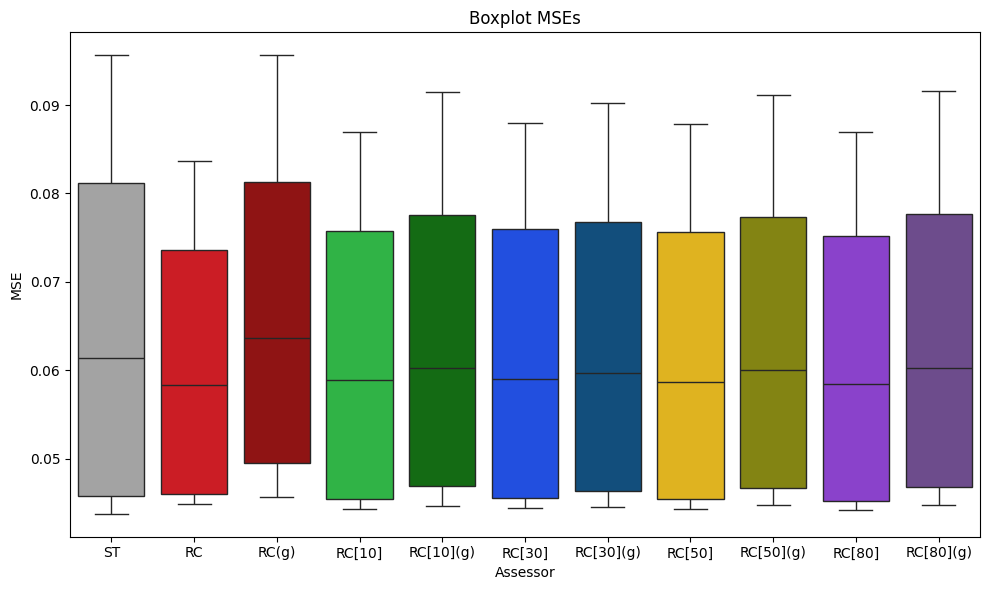

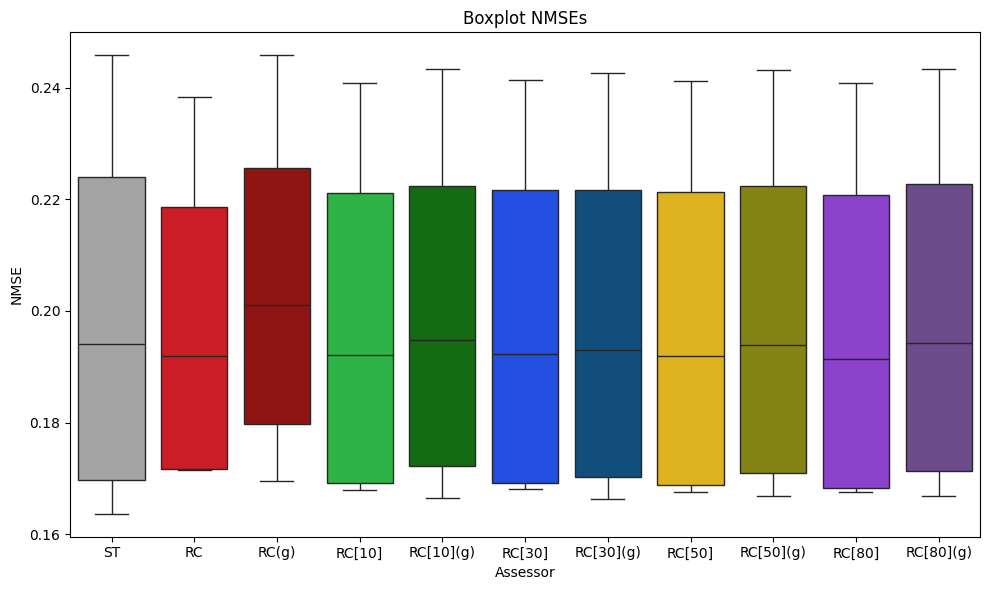

/tmp/ipykernel_84025/3845544327.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


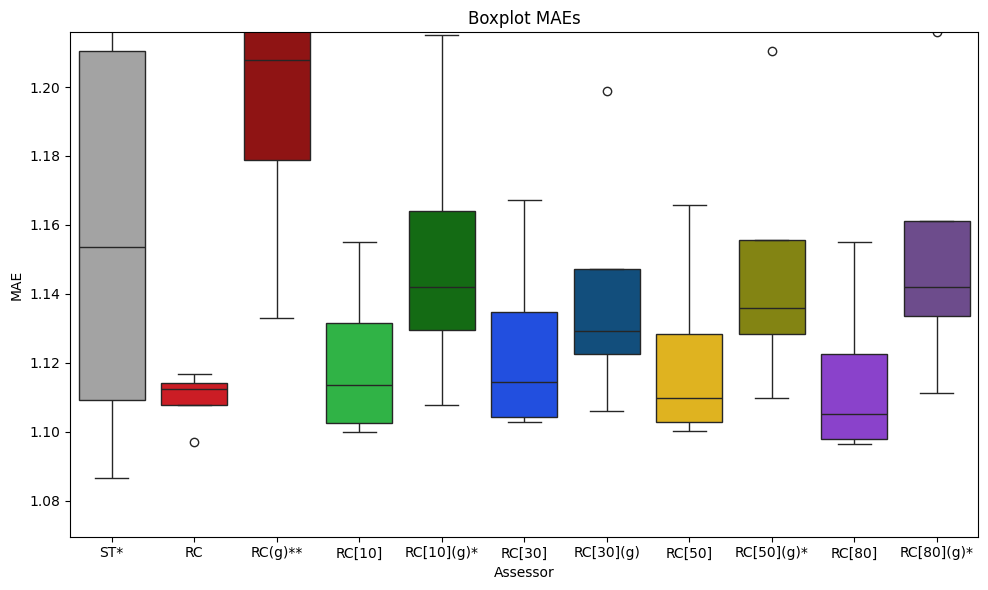

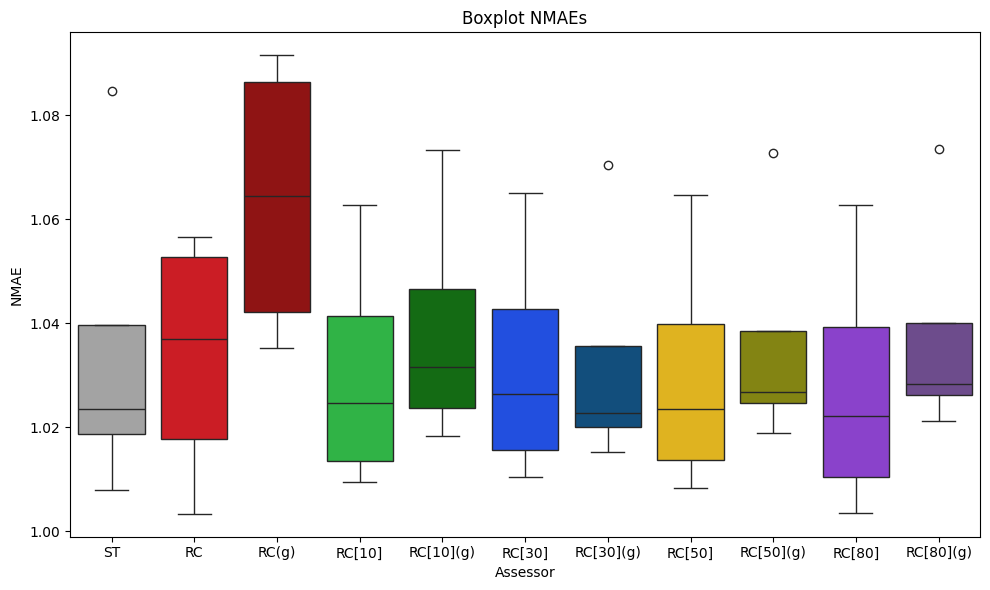

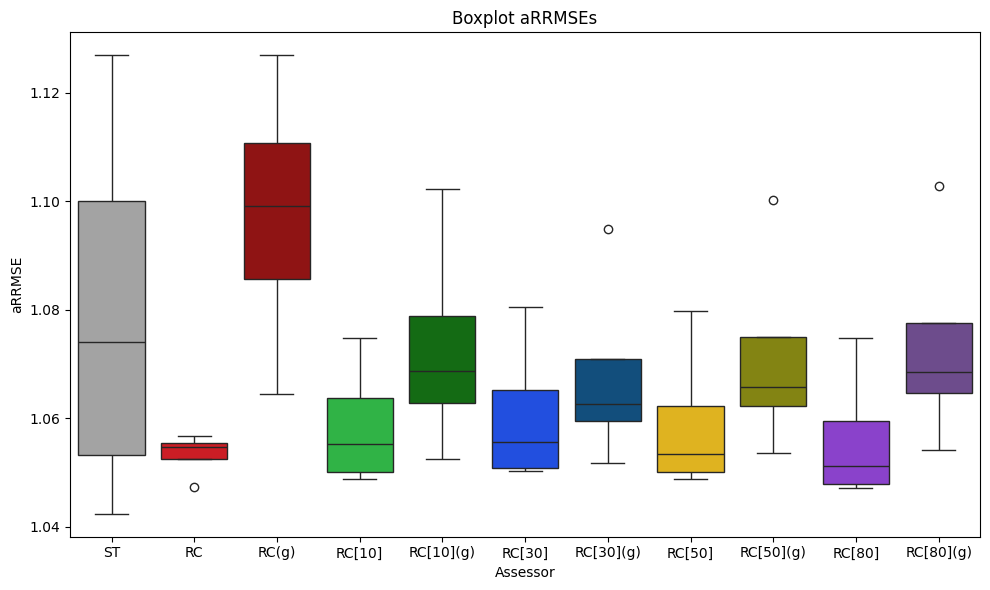

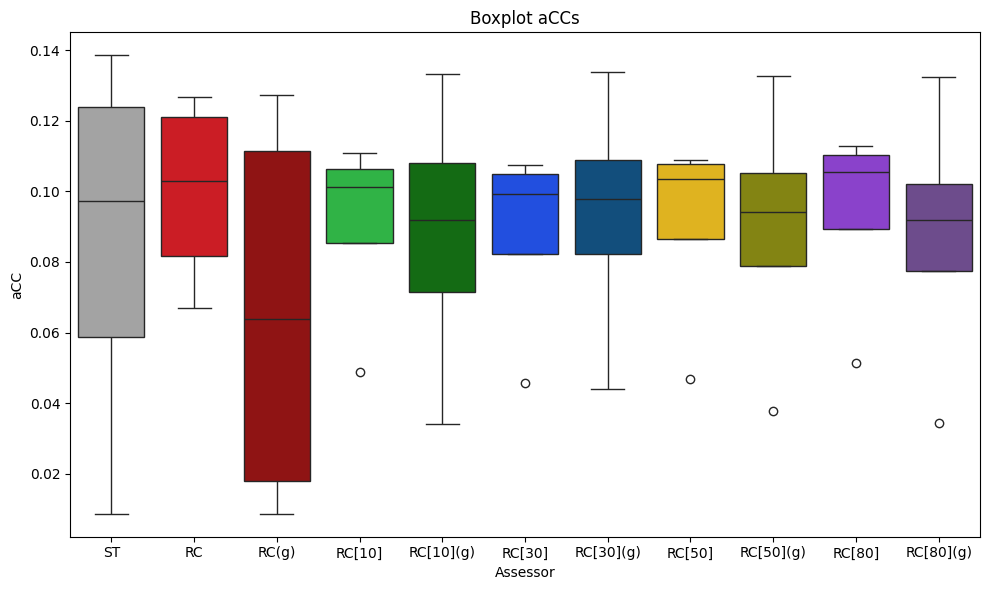

In [63]:
#temp = results_df.drop(index=results_df[results_df['Assessor'].str.contains('M-SVR')].index) #.copy()

for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.figure(figsize=(10,6))
    plt.title(f'Boxplot {mt}s')
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.2).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.2).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.ylim(bottom=temp[mt].min()-0.017,top=temp.loc[temp[mt]<1.2,mt].max()+0.017)
    imgplt = sns.boxplot(temp, y=mt, x='Assessor', hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}_RC.eps', format='eps', dpi=300)

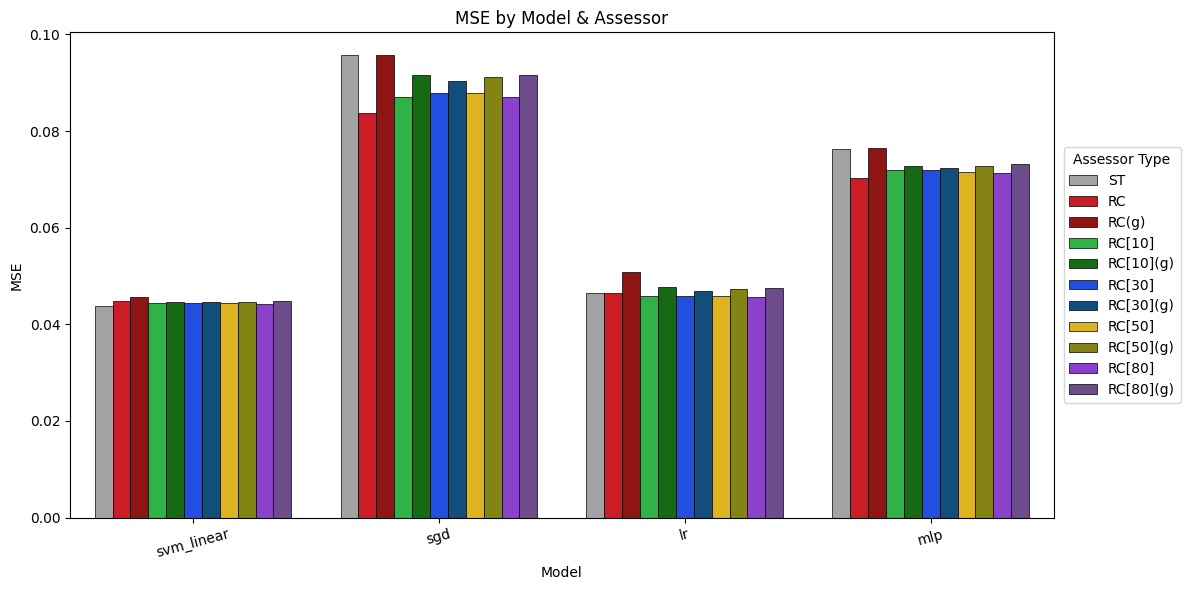

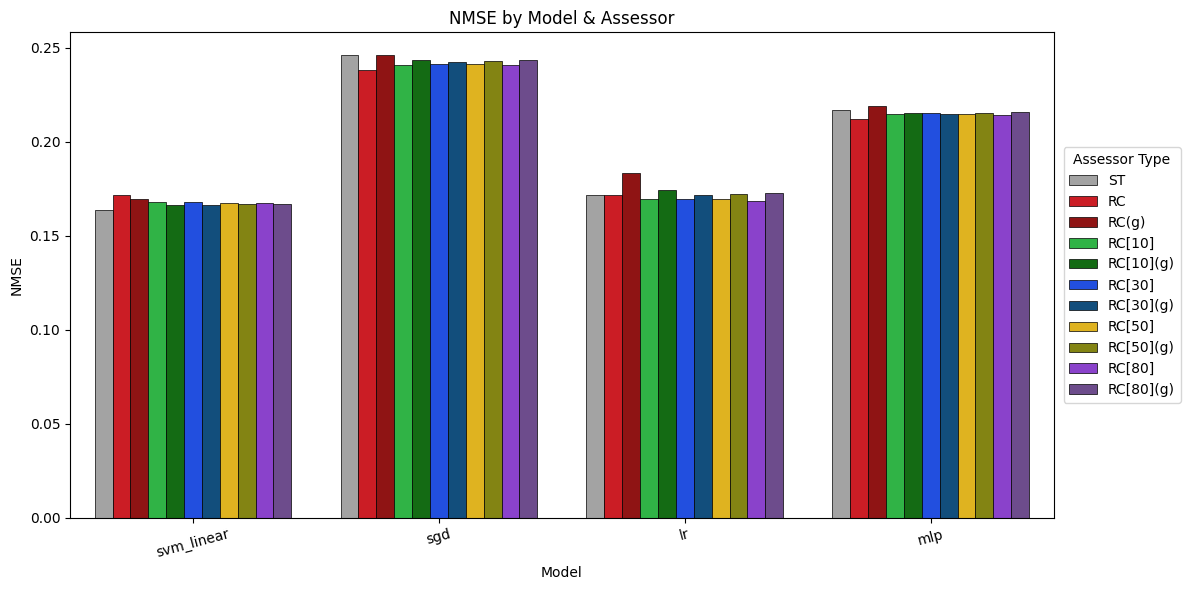

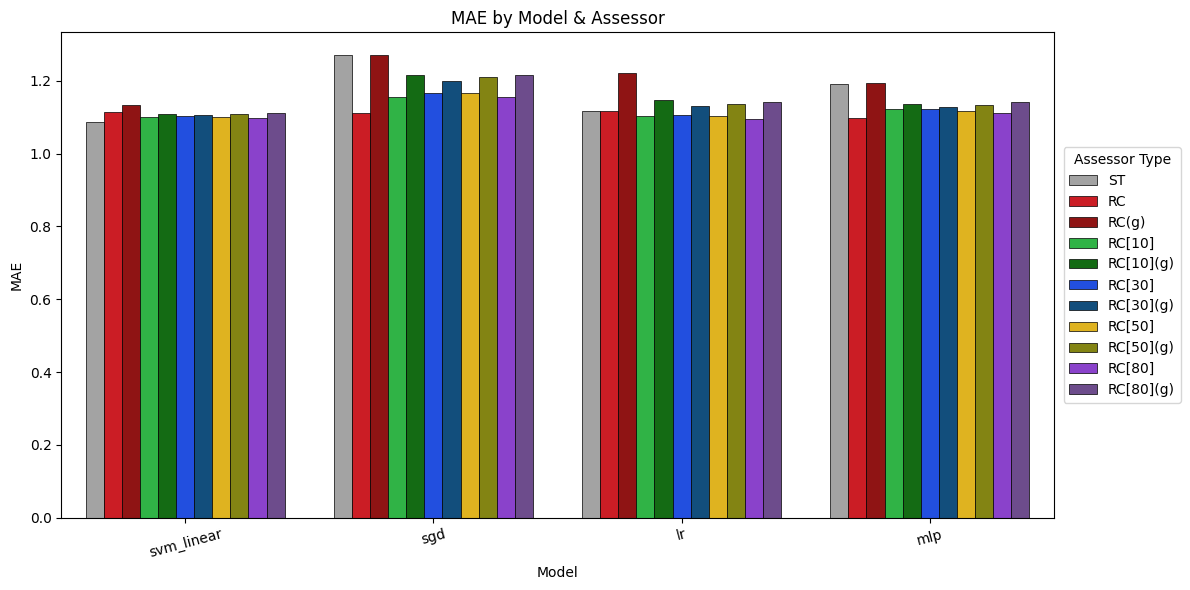

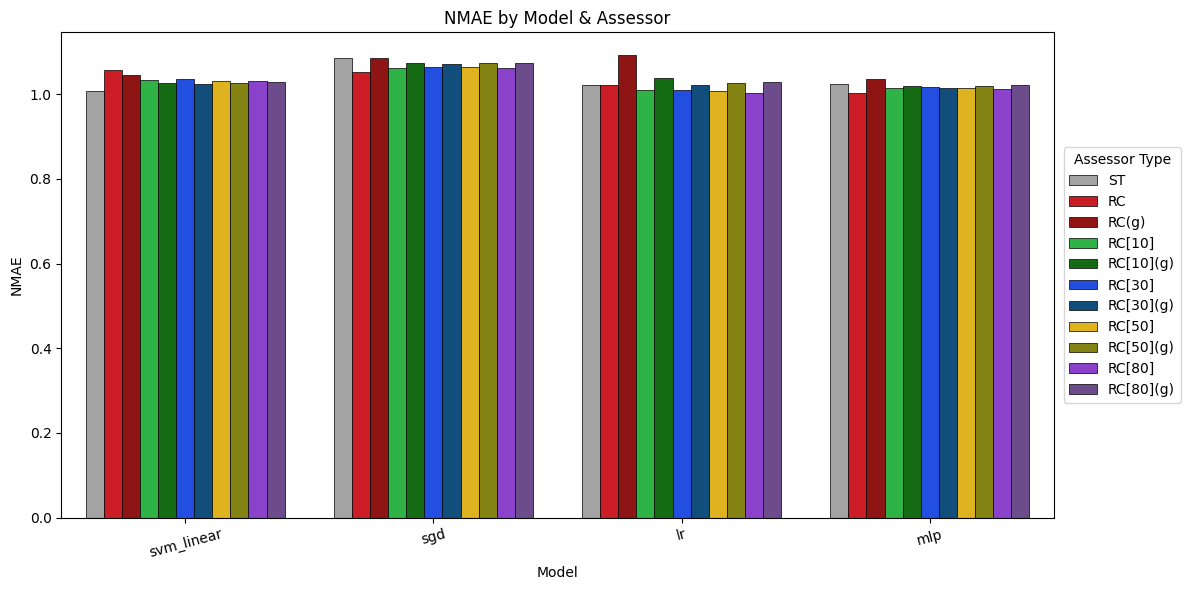

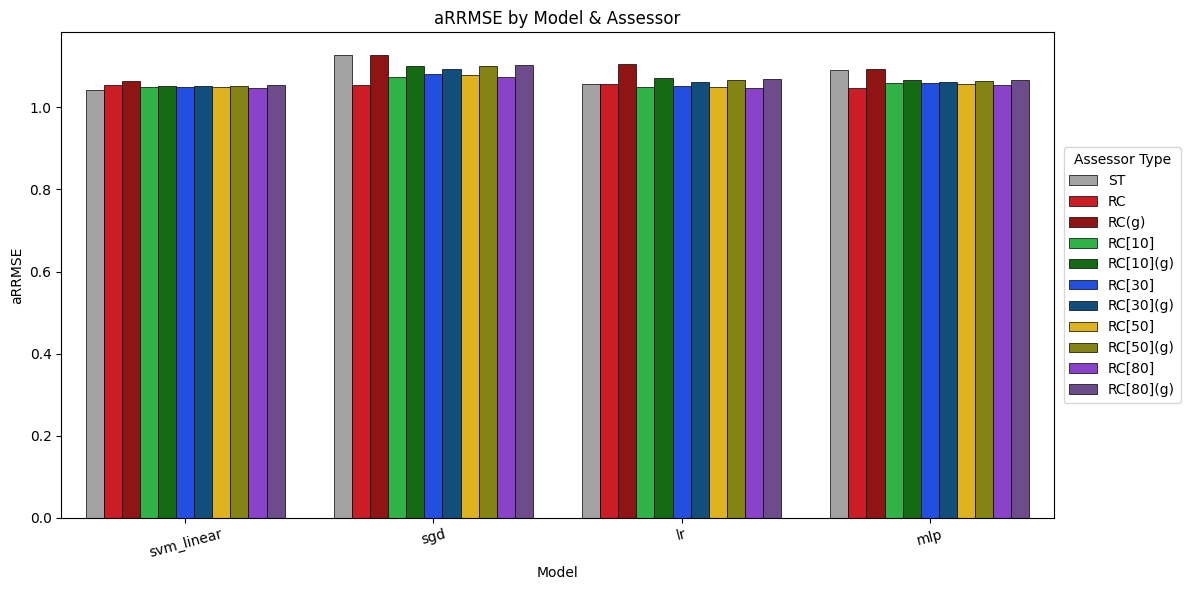

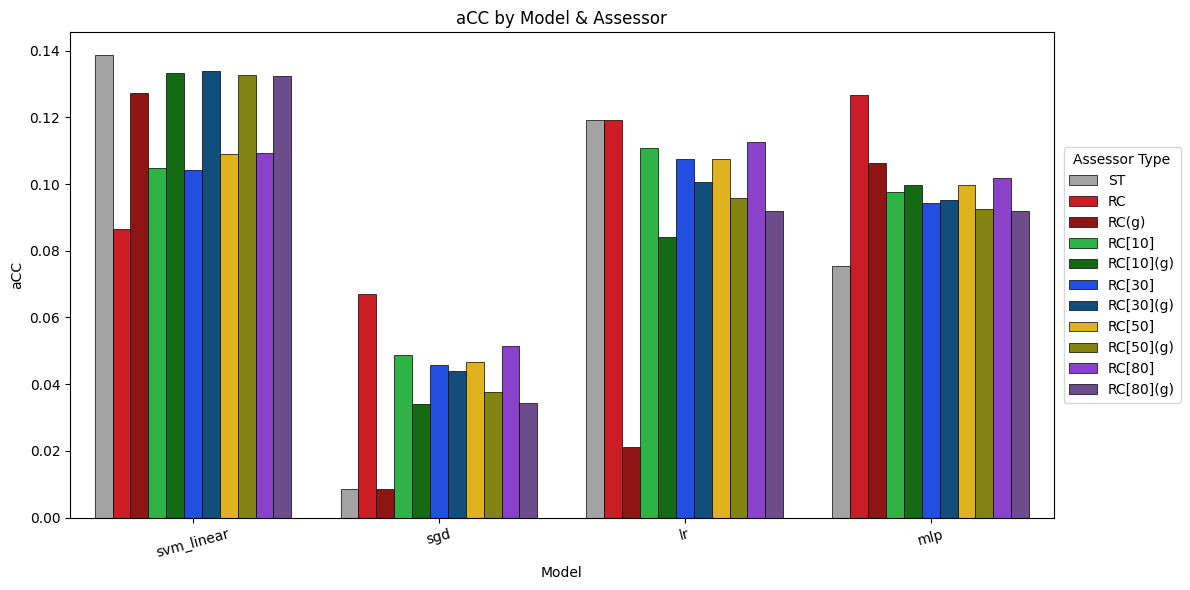

In [64]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=results_df, x='Model', y=mt, hue='Assessor', palette=class_palette, edgecolor='black', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    #imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)

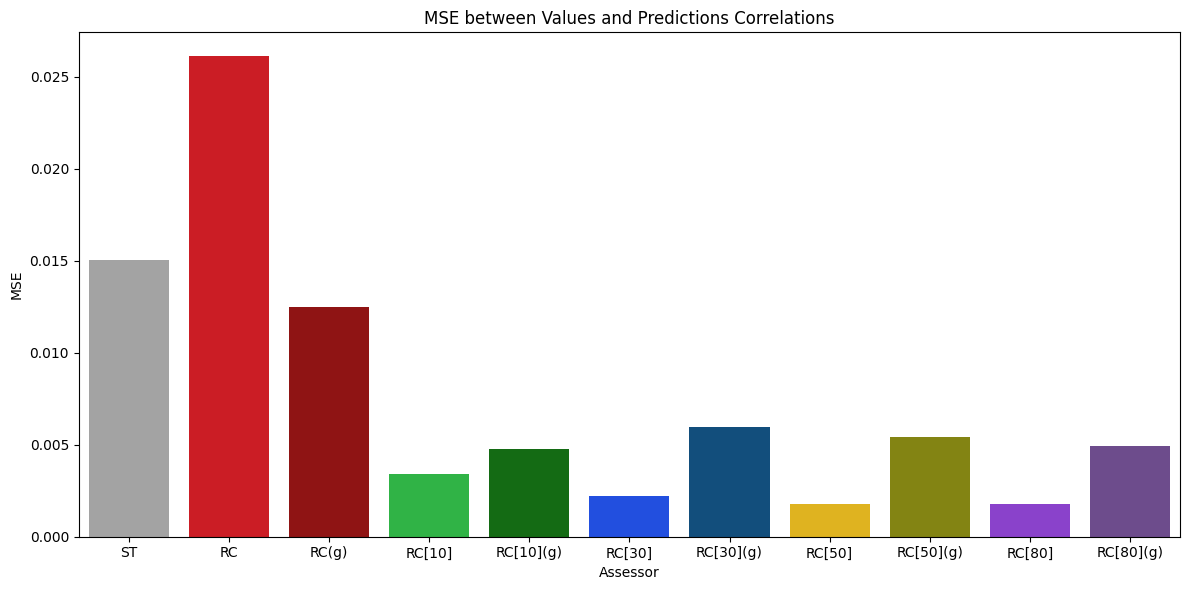

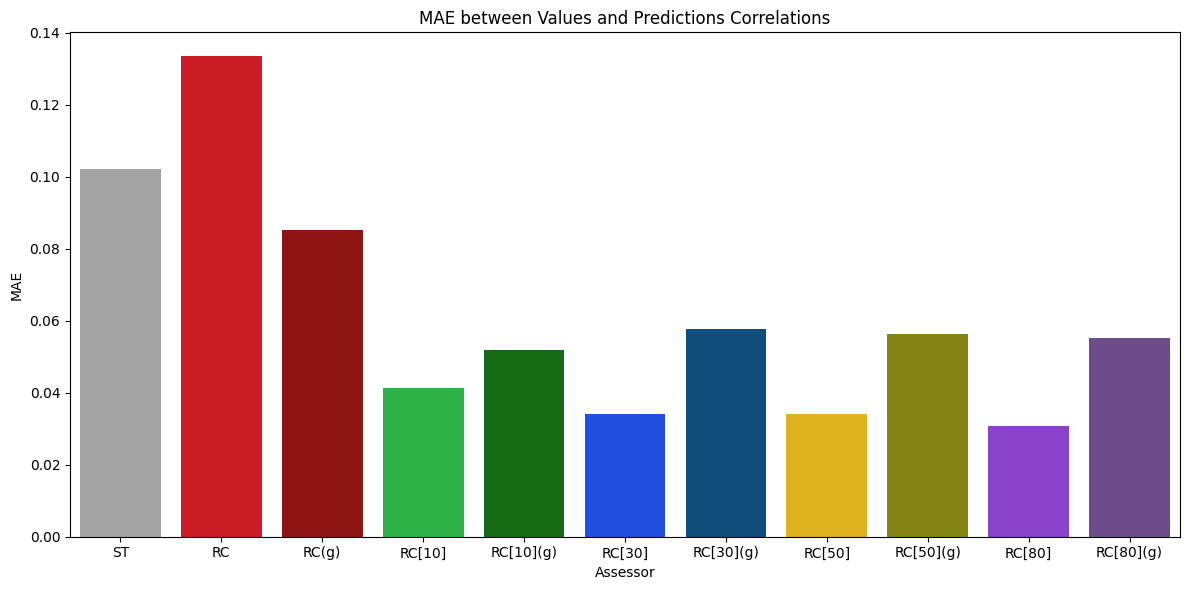

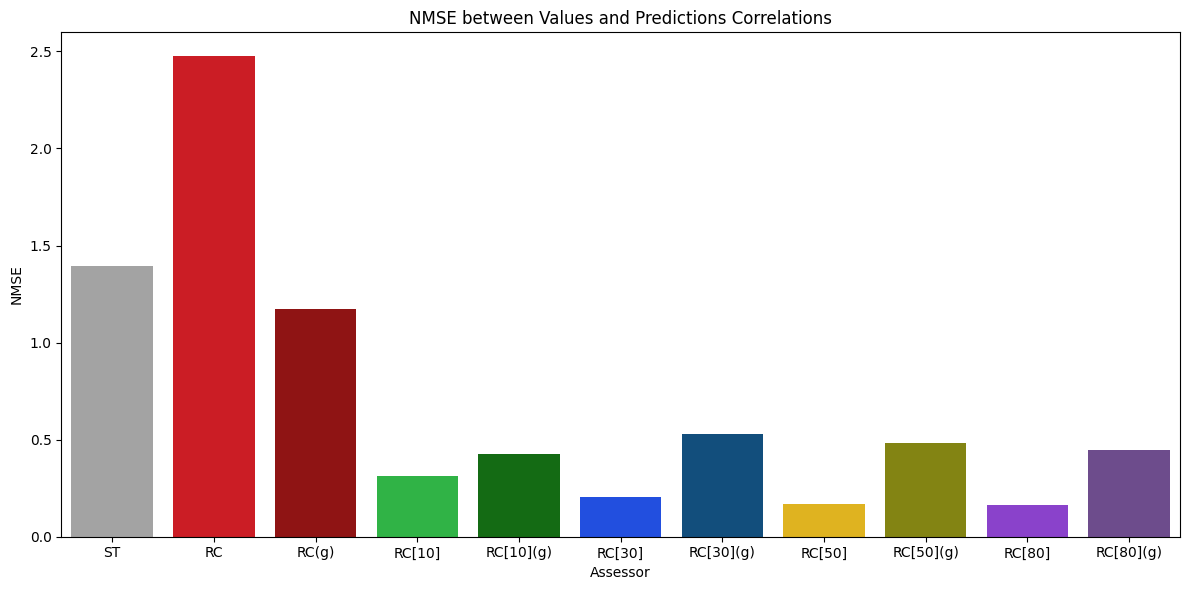

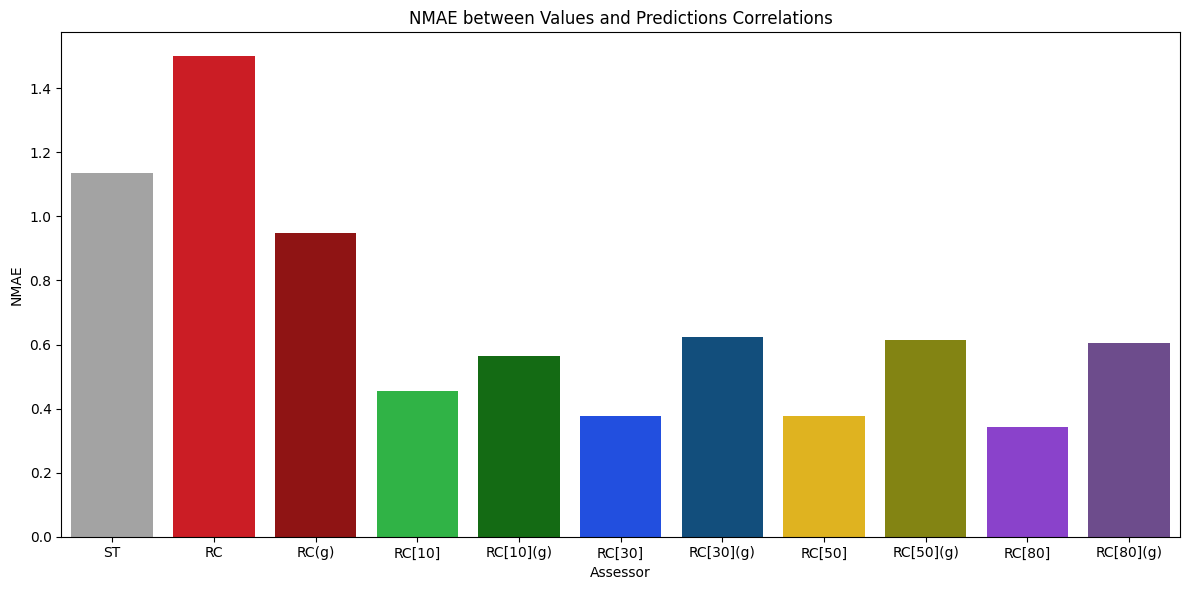

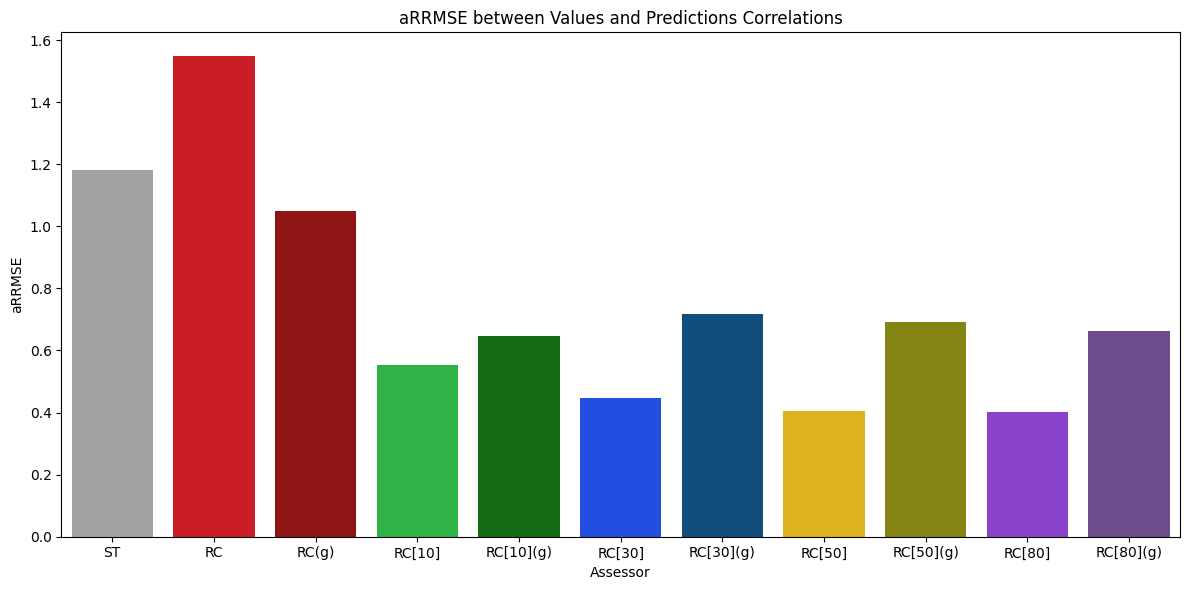

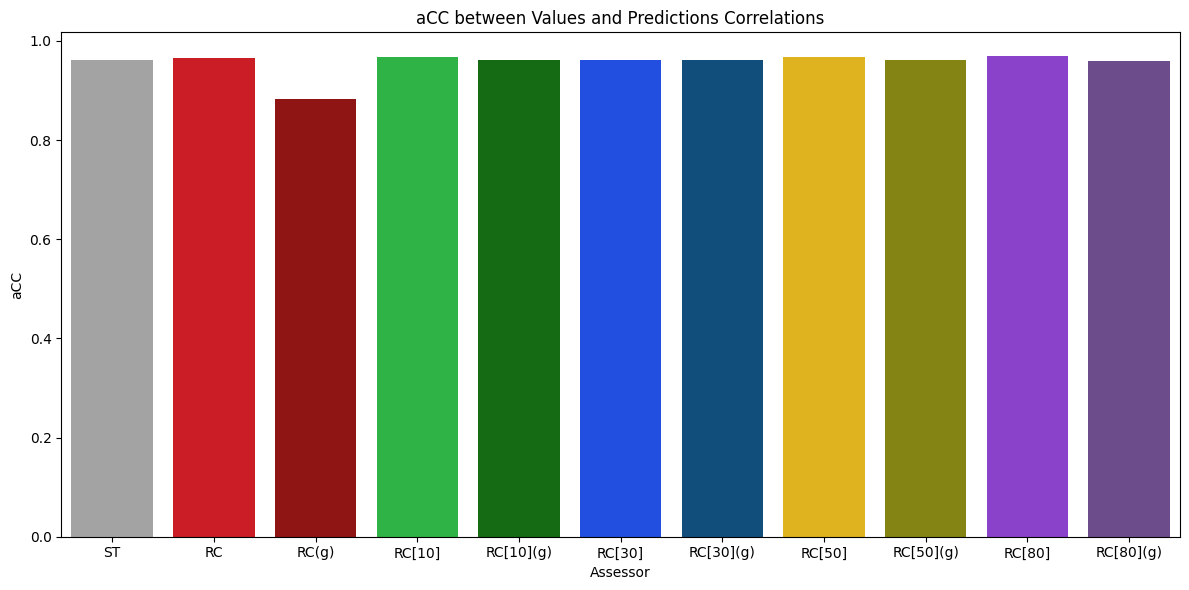

In [65]:
for mt in diff_metrics.columns:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=diff_results.loc[:,['Assessor', mt]], x='Assessor', y=mt, hue='Assessor', palette=class_palette)
    plt.title(f"{mt} between Values and Predictions Correlations")
    plt.tight_layout()
    plt.show(imgplt)
    #imgplt.figure.savefig(f'data/{DIR}/imgs/bardiff_{mt.lower()}.eps', format='eps', dpi=300)

---

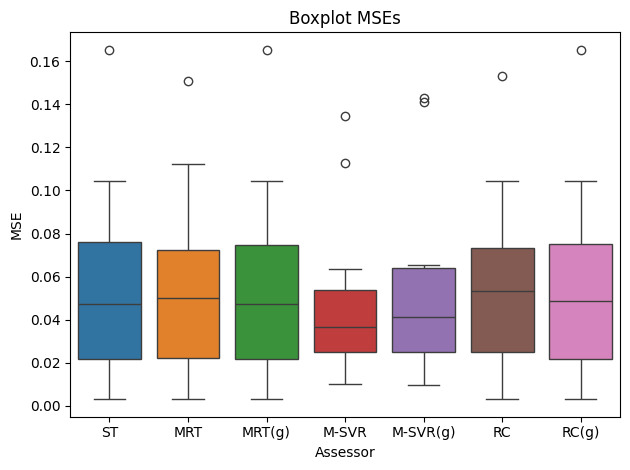

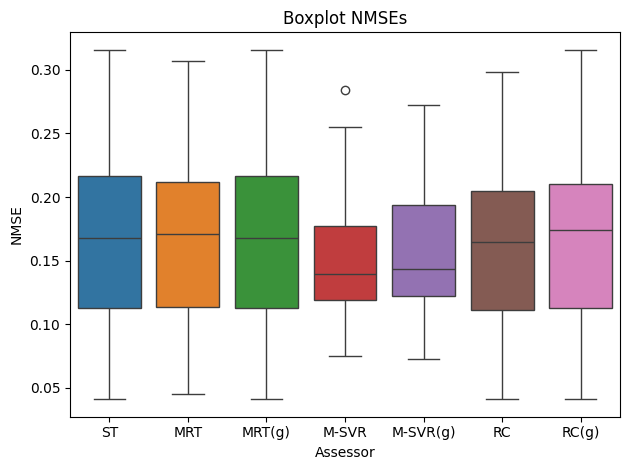

C:\Users\pedro\AppData\Local\Temp\ipykernel_9688\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


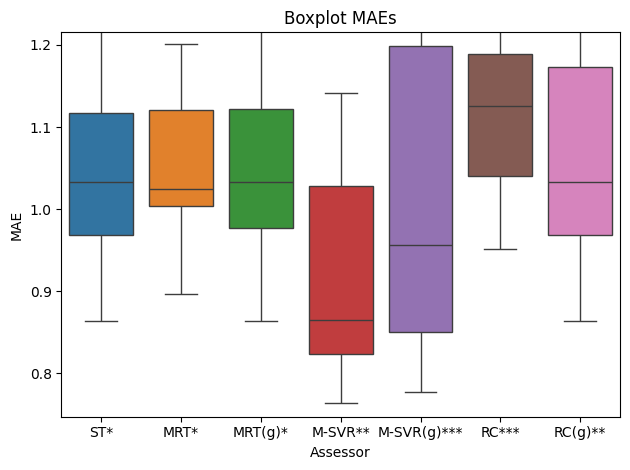

C:\Users\pedro\AppData\Local\Temp\ipykernel_9688\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


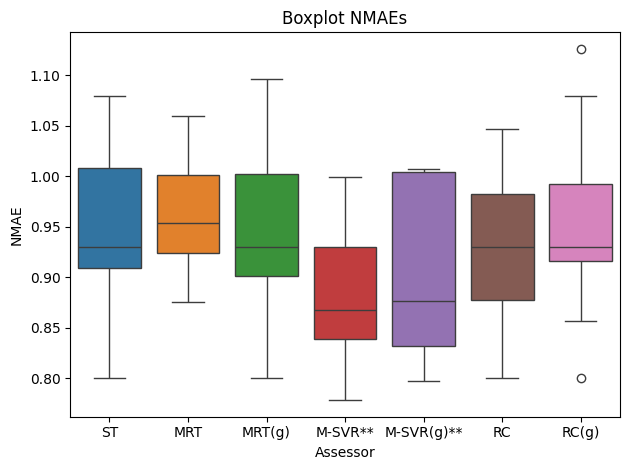

C:\Users\pedro\AppData\Local\Temp\ipykernel_9688\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


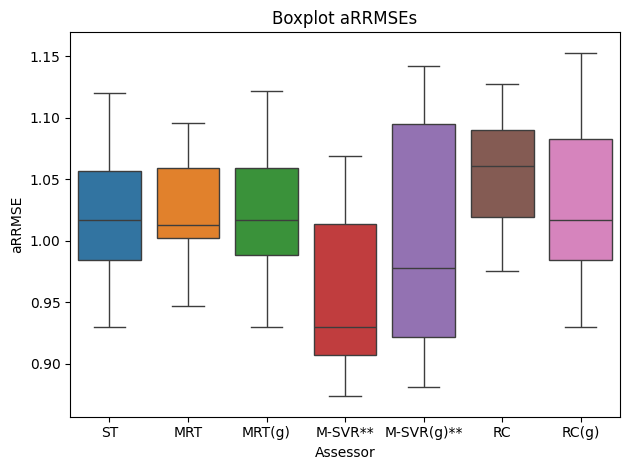

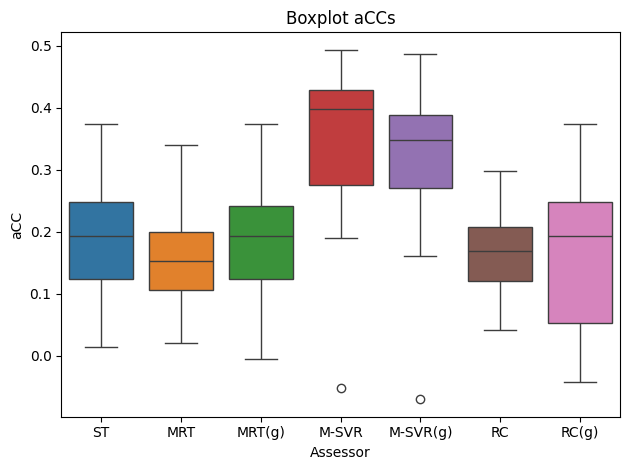

In [53]:
#temp = results_df.drop(index=results_df[results_df['Assessor'].str.contains('M-SVR')].index) #.copy()

for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.title(f'Boxplot {mt}s')
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.2).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.2).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.ylim(bottom=temp[mt].min()-0.017,top=temp.loc[temp[mt]<1.2,mt].max()+0.017)
    imgplt = sns.boxplot(temp, y=mt, x='Assessor', hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

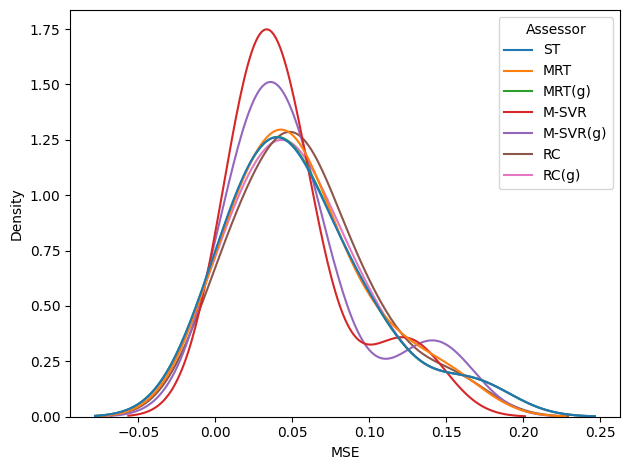

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


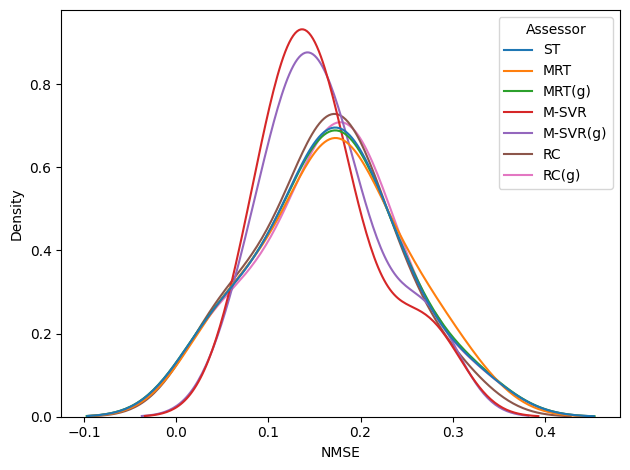

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\pedro\AppData\Local\Temp\ipykernel_9688\1270300147.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


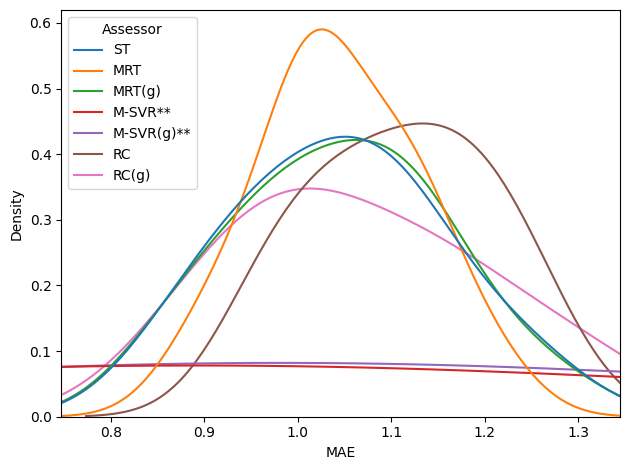

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\pedro\AppData\Local\Temp\ipykernel_9688\1270300147.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


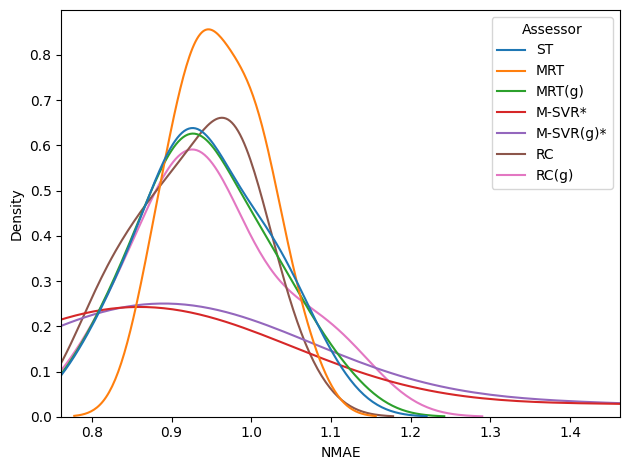

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\pedro\AppData\Local\Temp\ipykernel_9688\1270300147.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


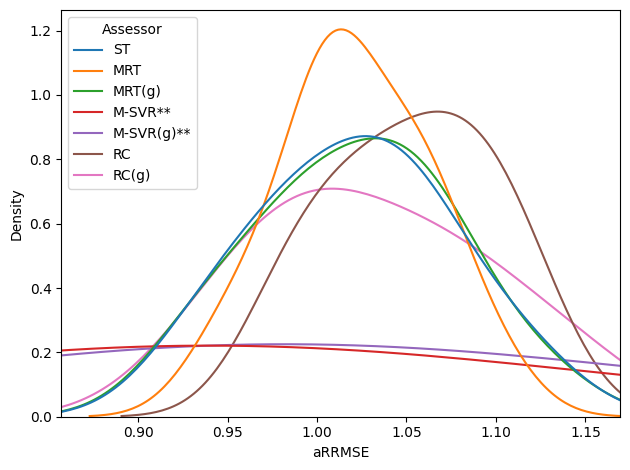

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


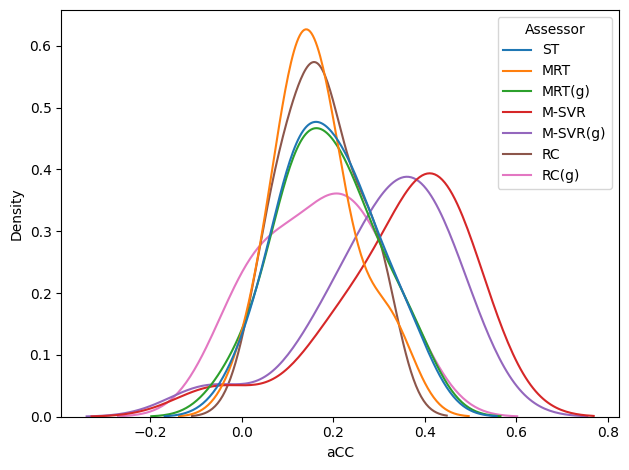

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [54]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.5).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.5).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.xlim(temp[mt].min()-0.017,temp.loc[temp[mt]<1.5,mt].max()+0.017)
    imgplt = sns.kdeplot(temp, x=mt, hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/kde_{mt.lower()}.eps', format='eps', dpi=300)

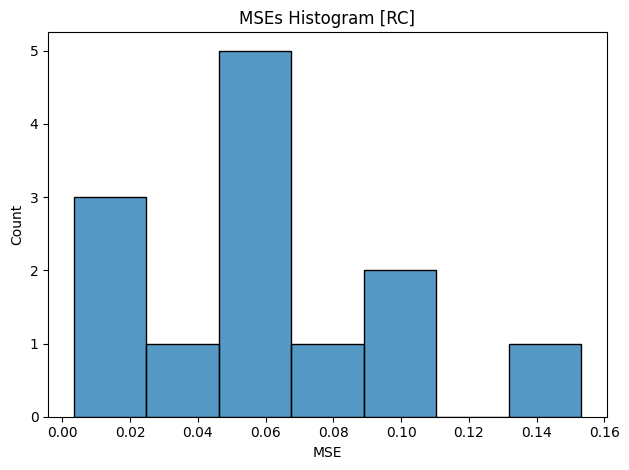

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


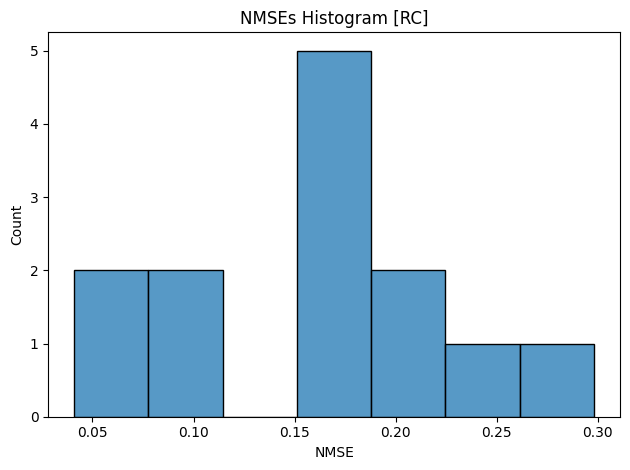

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


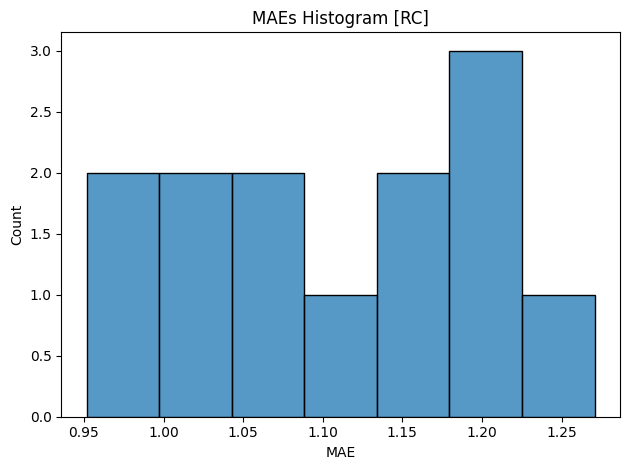

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


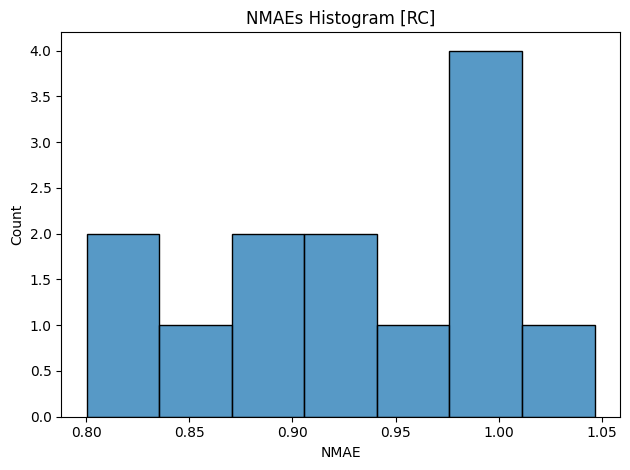

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


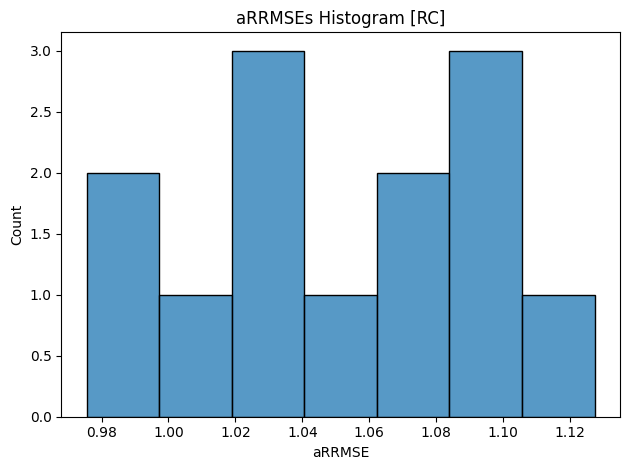

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


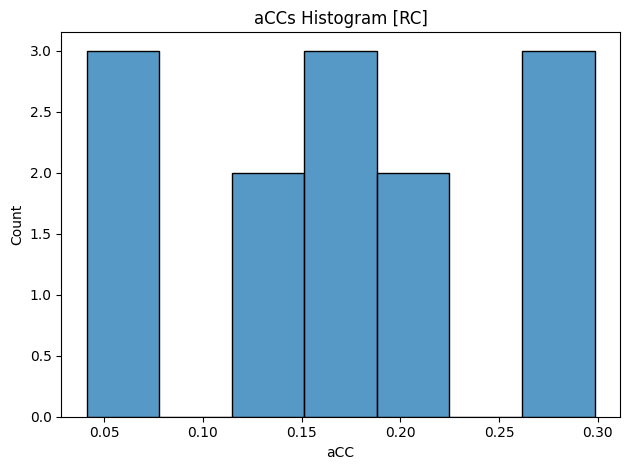

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


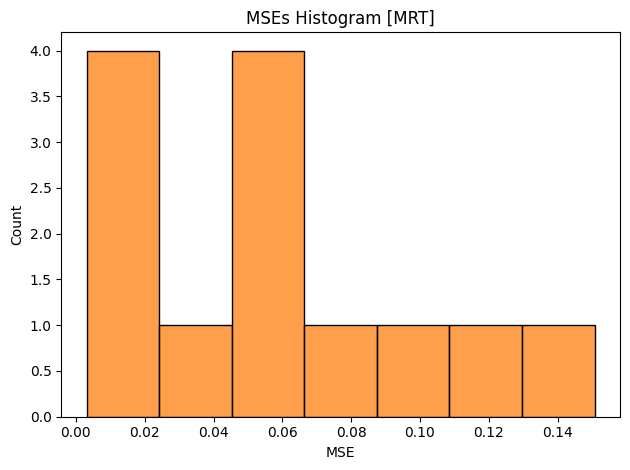

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


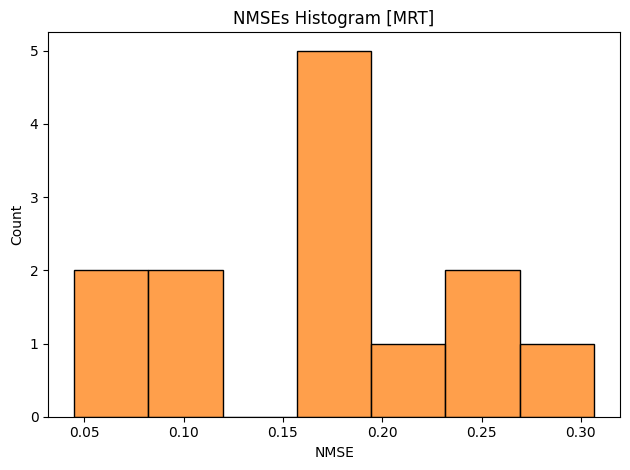

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


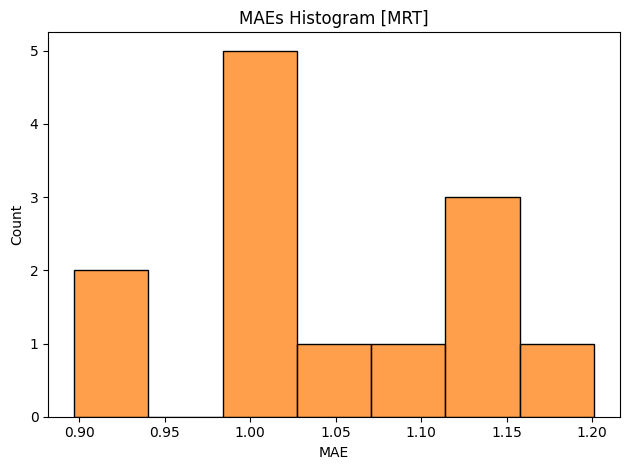

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


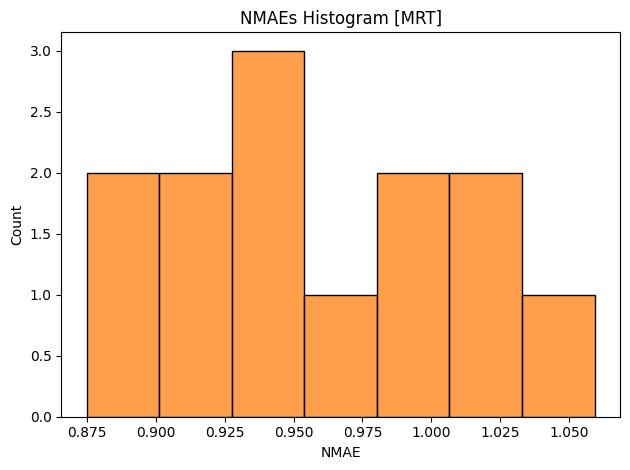

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


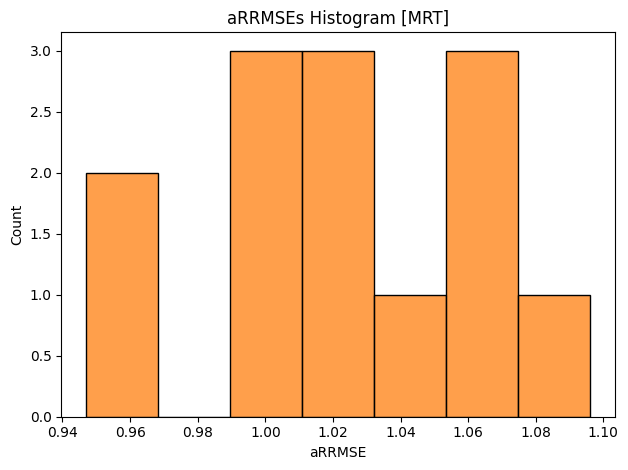

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


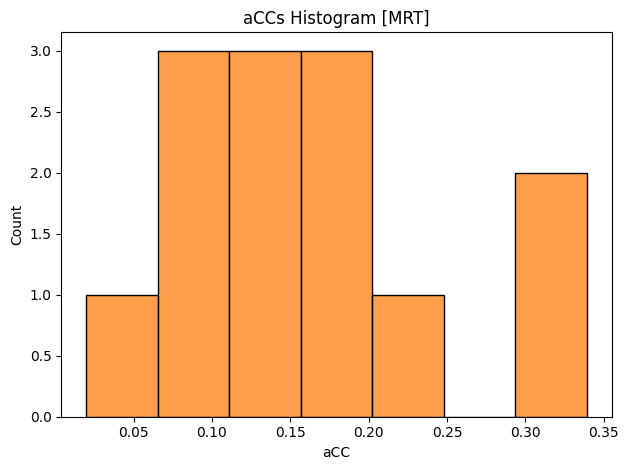

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


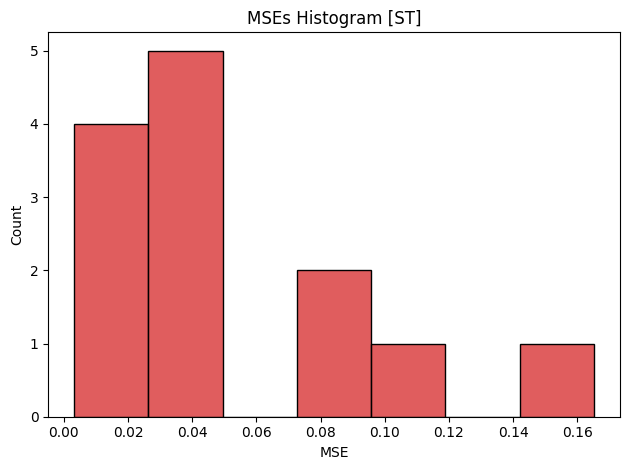

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


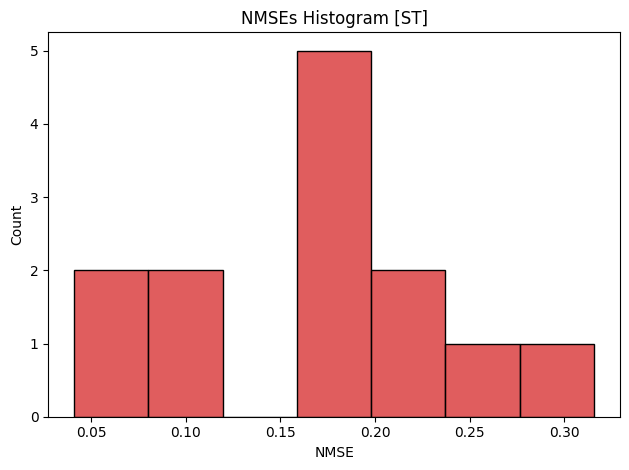

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


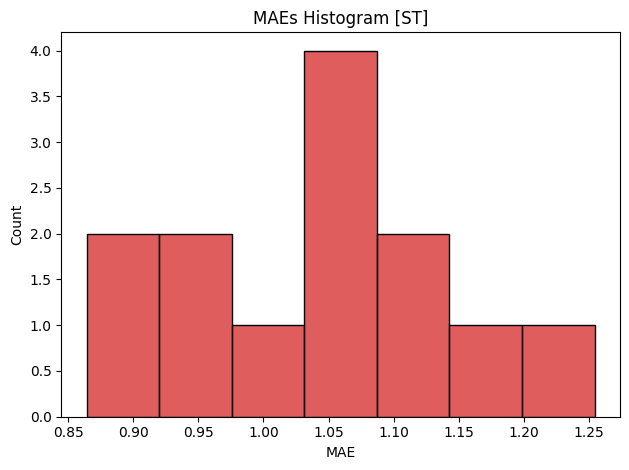

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


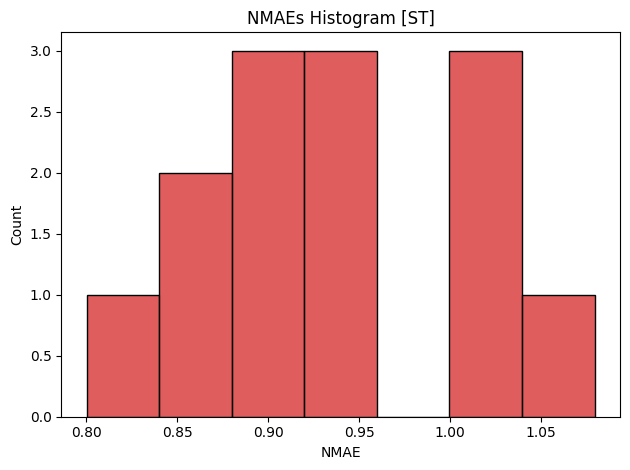

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


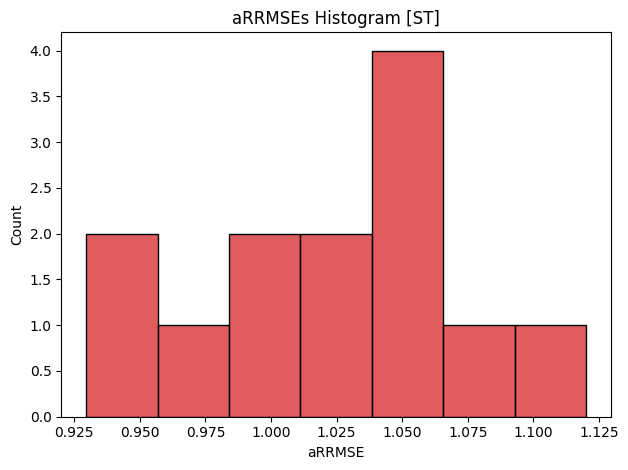

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


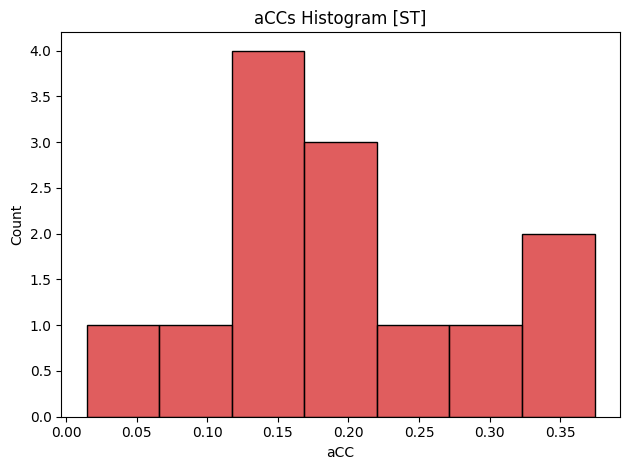

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


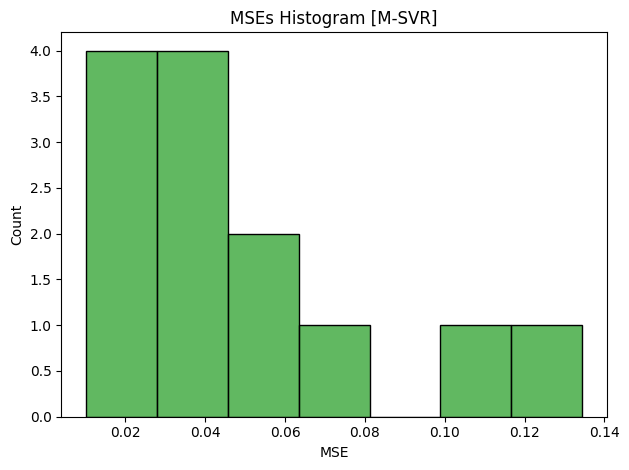

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


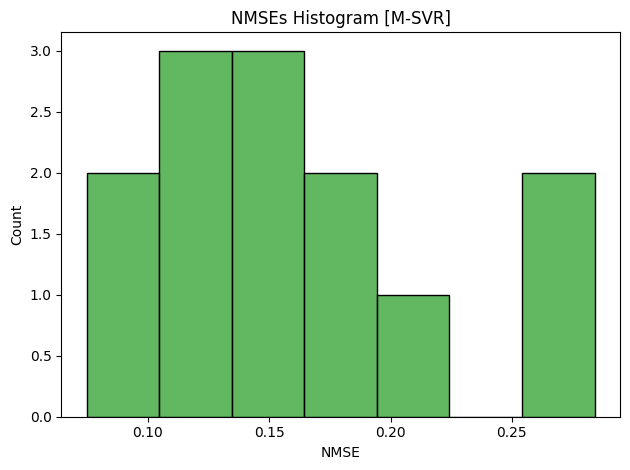

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


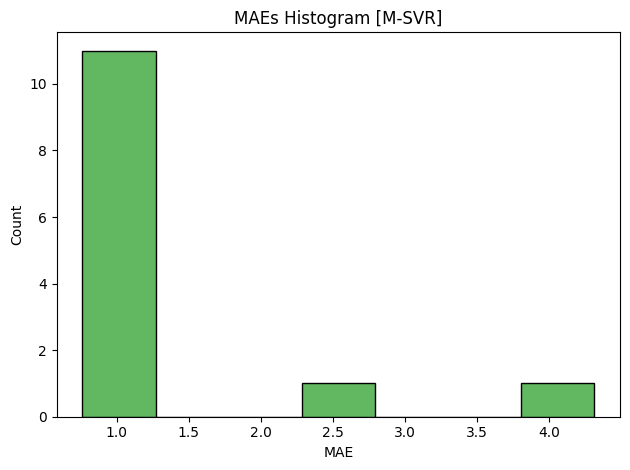

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


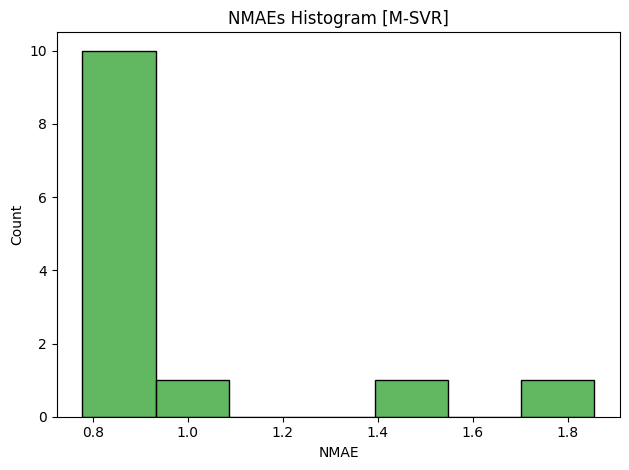

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


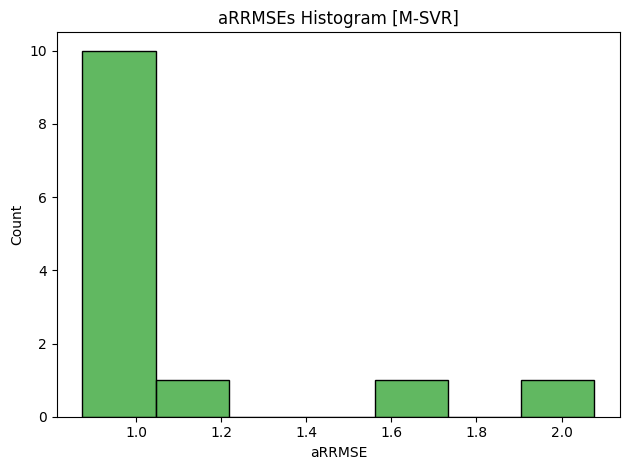

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


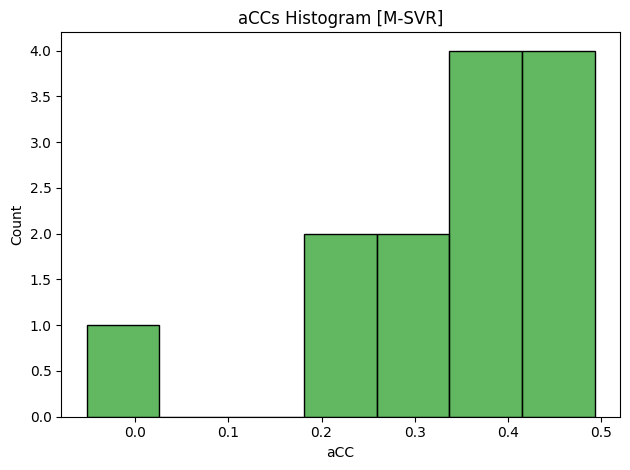

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


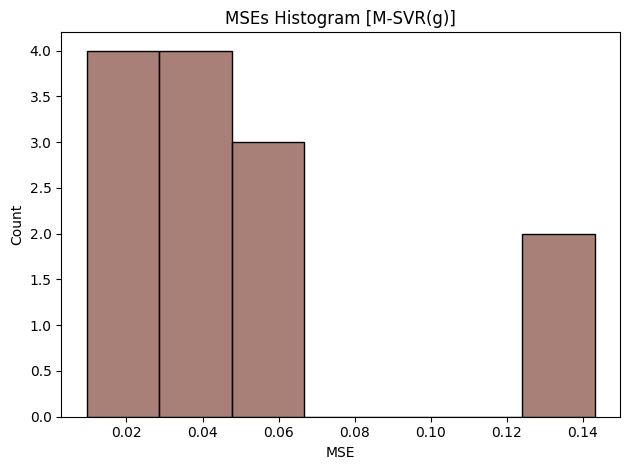

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


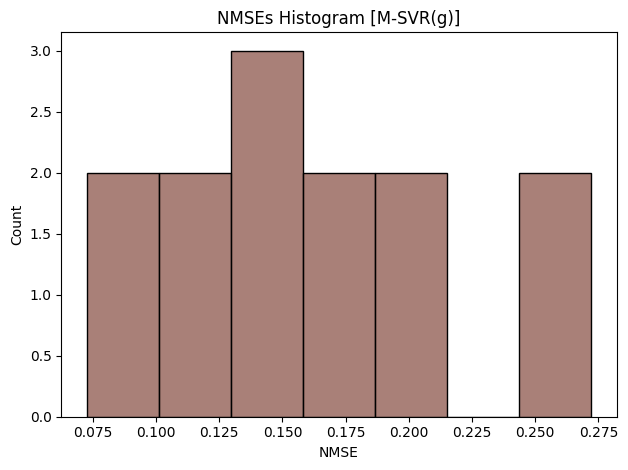

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


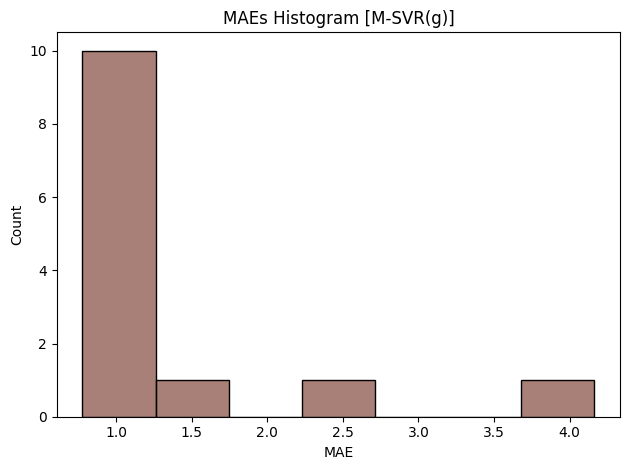

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


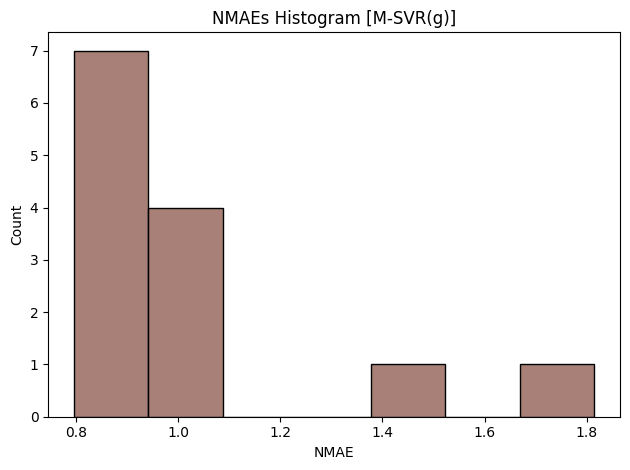

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


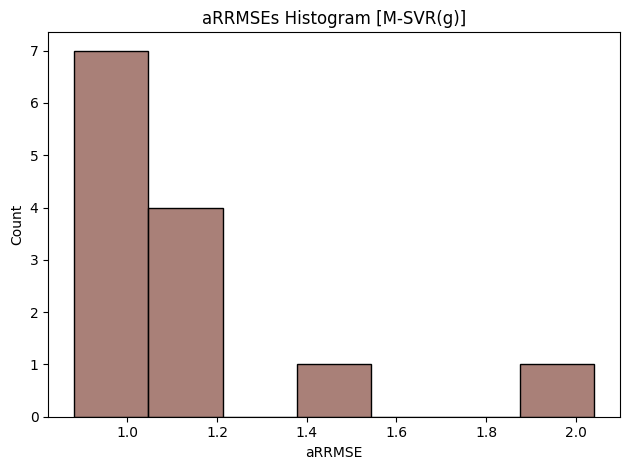

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


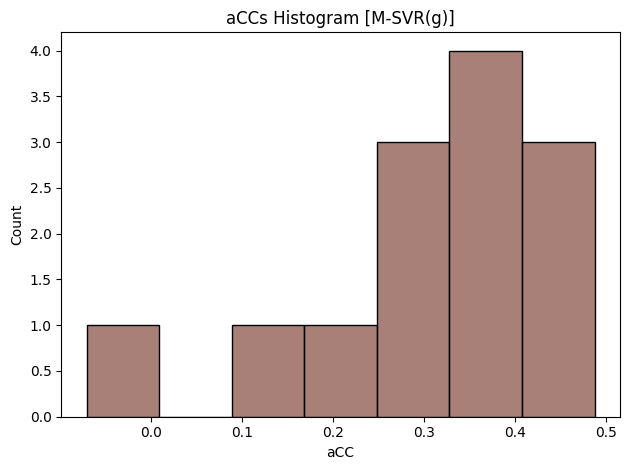

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


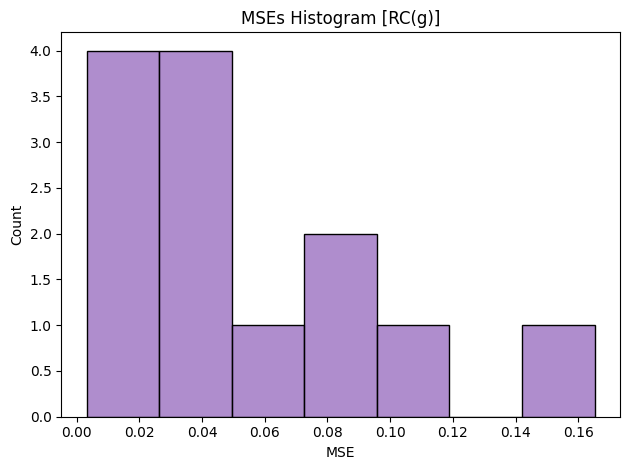

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


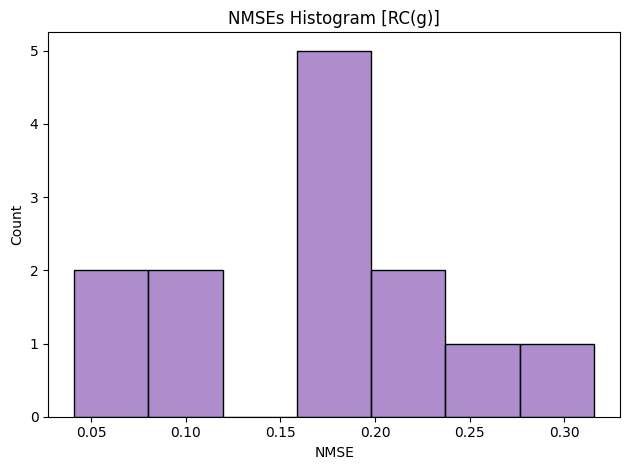

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


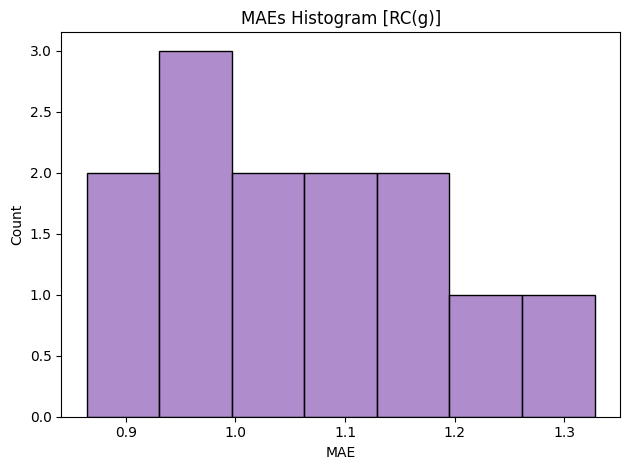

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


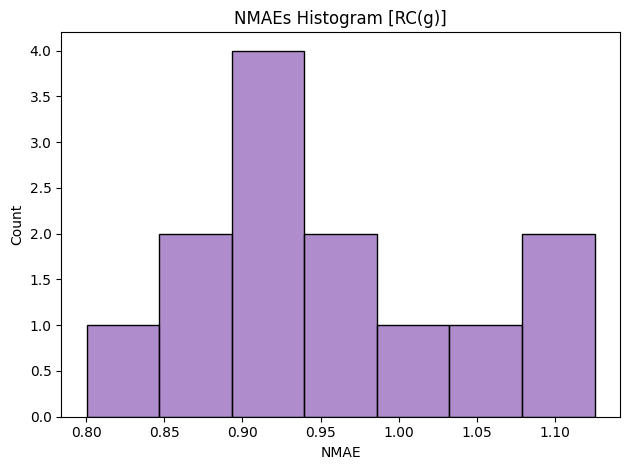

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


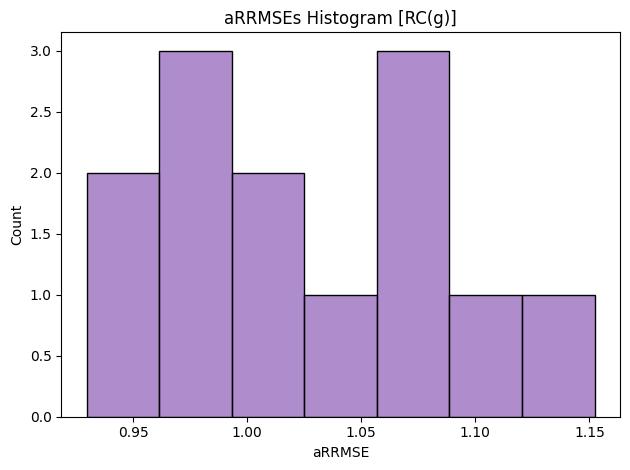

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


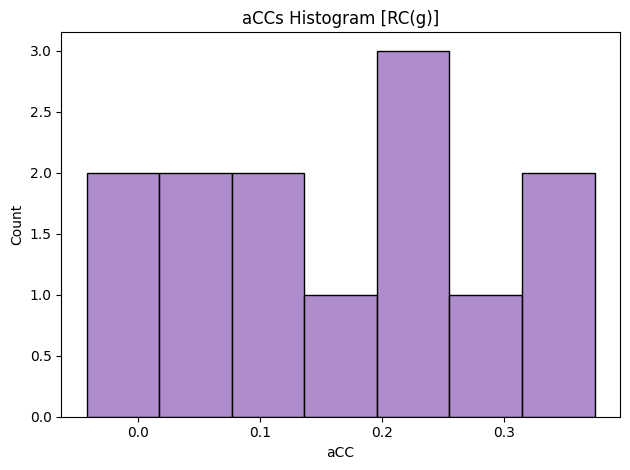

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


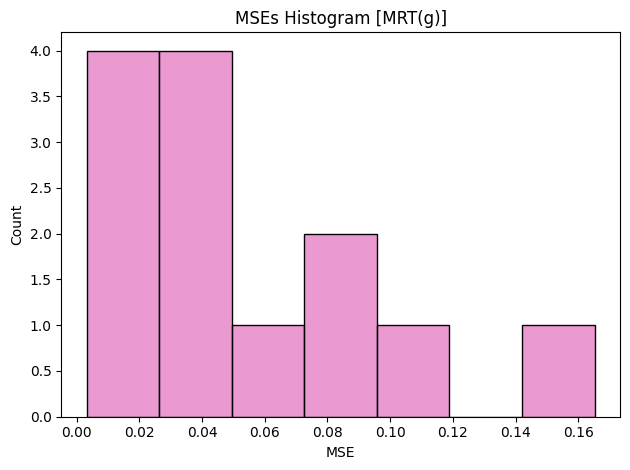

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


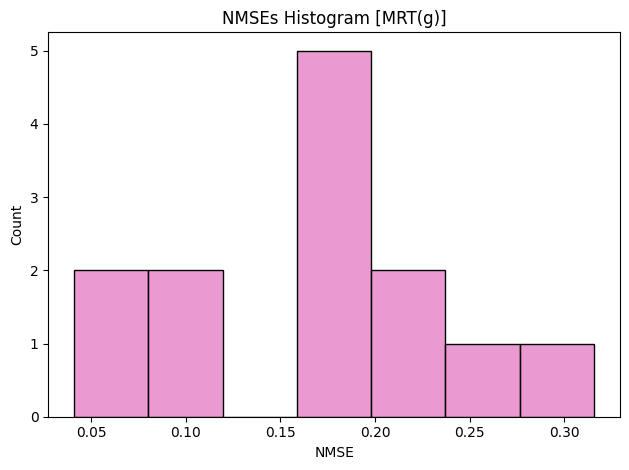

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


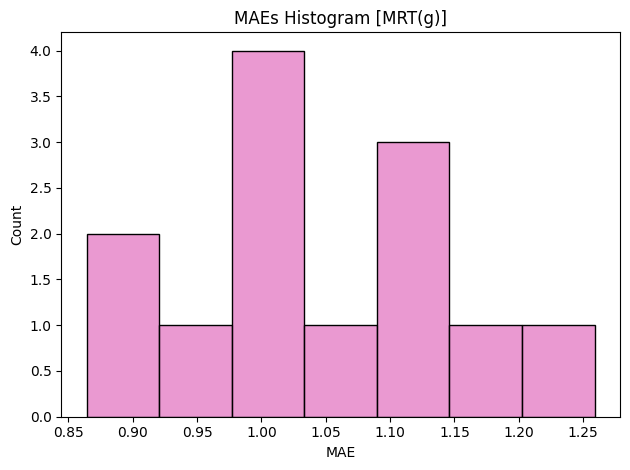

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


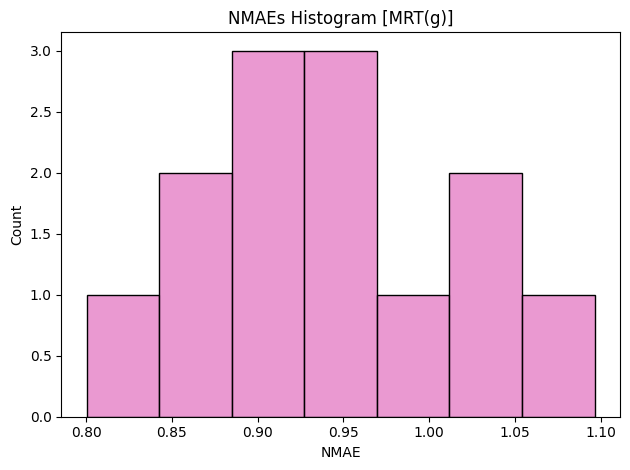

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


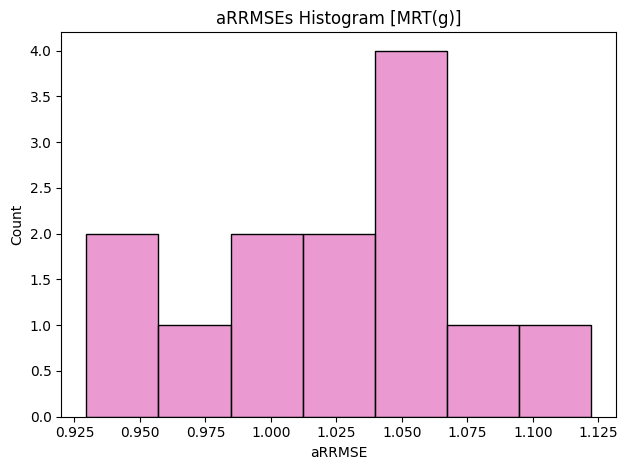

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


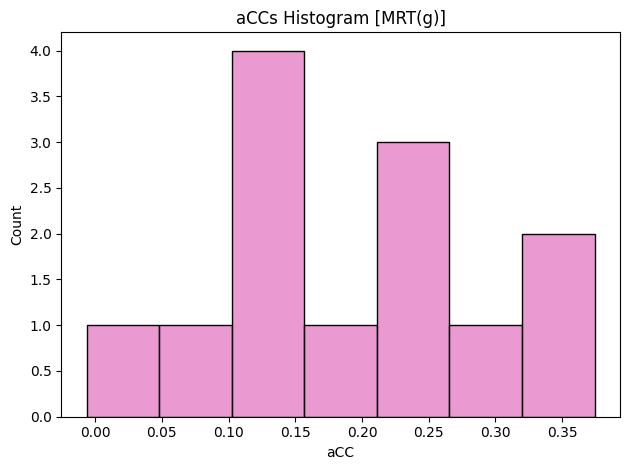

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [55]:
dicio = {'RC': {'color': class_palette[0], 'code': 'RC'},
         'MRT': {'color': class_palette[1], 'code': 'MRT'},
         'ST': {'color': class_palette[3], 'code': 'ST'},
         'M-SVR': {'color': class_palette[2], 'code': 'MSVR'},
         'M-SVR(g)': {'color': class_palette[-2], 'code': 'MSVRG'},
         'RC(g)': {'color': class_palette[-3], 'code': 'RCG'},
         'MRT(g)': {'color': class_palette[-1], 'code': 'MRTG'}}

for a in dicio.keys():
    for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(results_df.loc[results_df['Assessor']==a,['Assessor','Model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/{DIR}/imgs/hg_{dicio[a]["code"]}_{mt.lower()}.eps', format='eps', dpi=300)

In [56]:
results_df

Assessor       Model       MSE       MAE      NMSE      NMAE    aRRMSE  \
0        ST       dtree  0.104349  0.951737  0.224283  0.800256   0.97557   
1        ST         sgd  0.094476  1.254439  0.244691   1.07953  1.120017   
2        ST          lr  0.046417   1.11667  0.171636  1.022398  1.056726   
3        ST         knn  0.049038   0.96854  0.174982  0.915773  0.984144   
4        ST  svm_linear  0.043766  1.086575  0.163649  1.007816  1.042389   
..      ...         ...       ...       ...       ...       ...       ...   
86    RC(g)         kan  0.165216  1.121646  0.315833  0.951298  1.059078   
87    RC(g)     rforest  0.047254  0.864178  0.167651  0.856544  0.929612   
88    RC(g)          gb  0.021777  0.986115   0.11291  0.947642  0.993033   
89    RC(g)        adab  0.004464  1.085798  0.047467  0.916775  1.042016   
90    RC(g)         xgb  0.003189  1.033272  0.040942   0.85781    1.0165   

         aCC  
0   0.279237  
1   0.014541  
2   0.119061  
3    0.24813  
4   0.138563  
..       ...  
86  0.123893  
87  0.374331  
88  0.216084  
89   0.13221  
90   0.19298  

[91 rows x 8 columns]

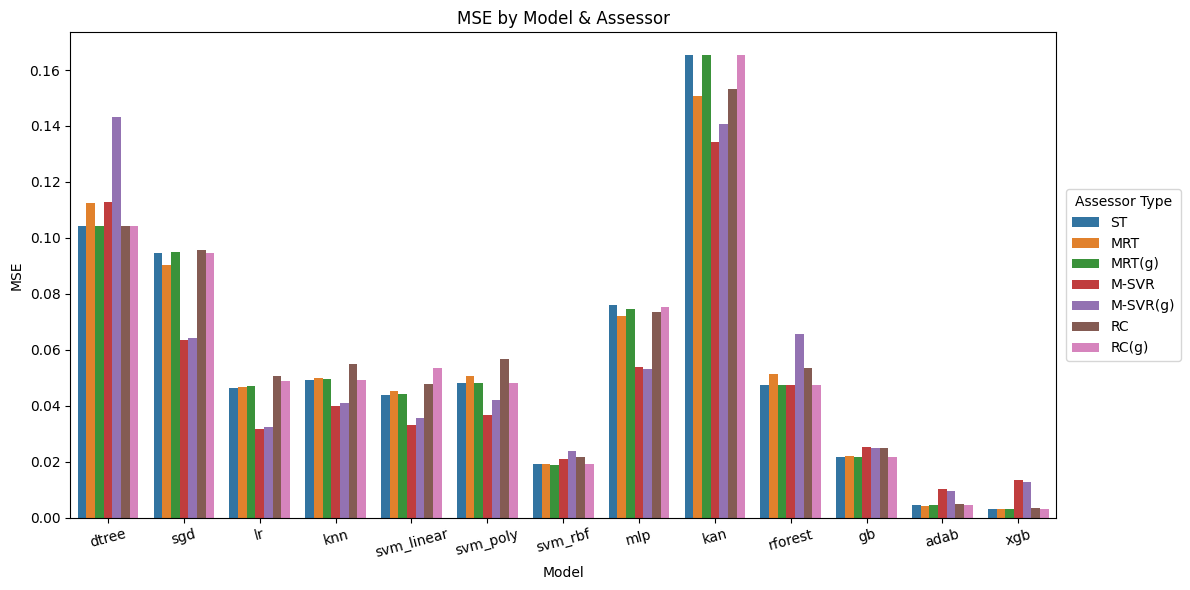

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


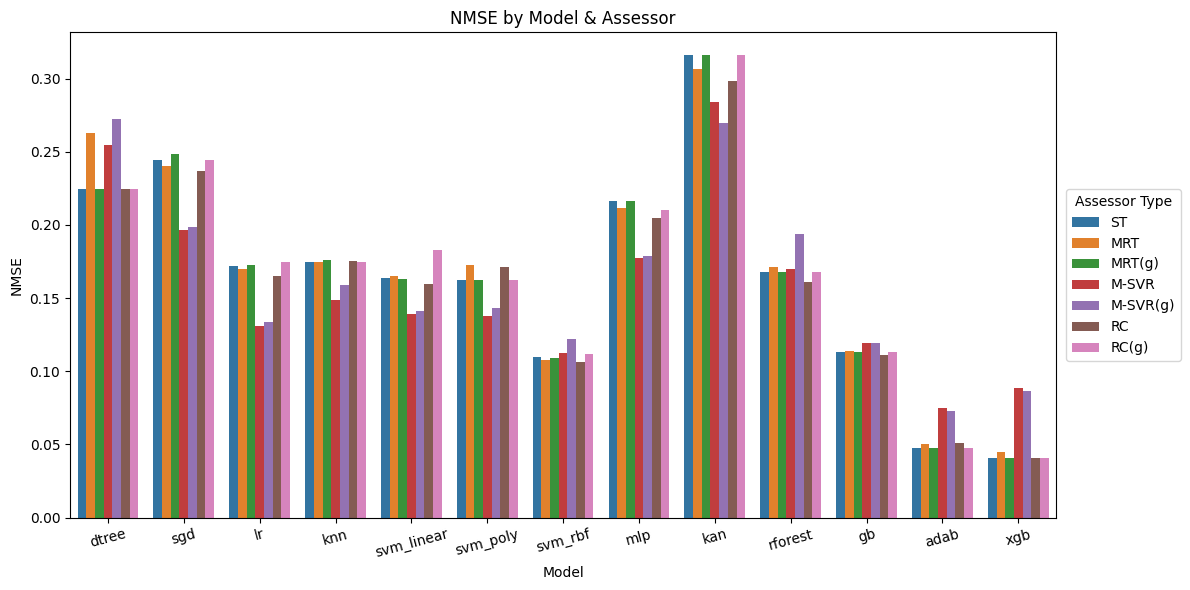

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


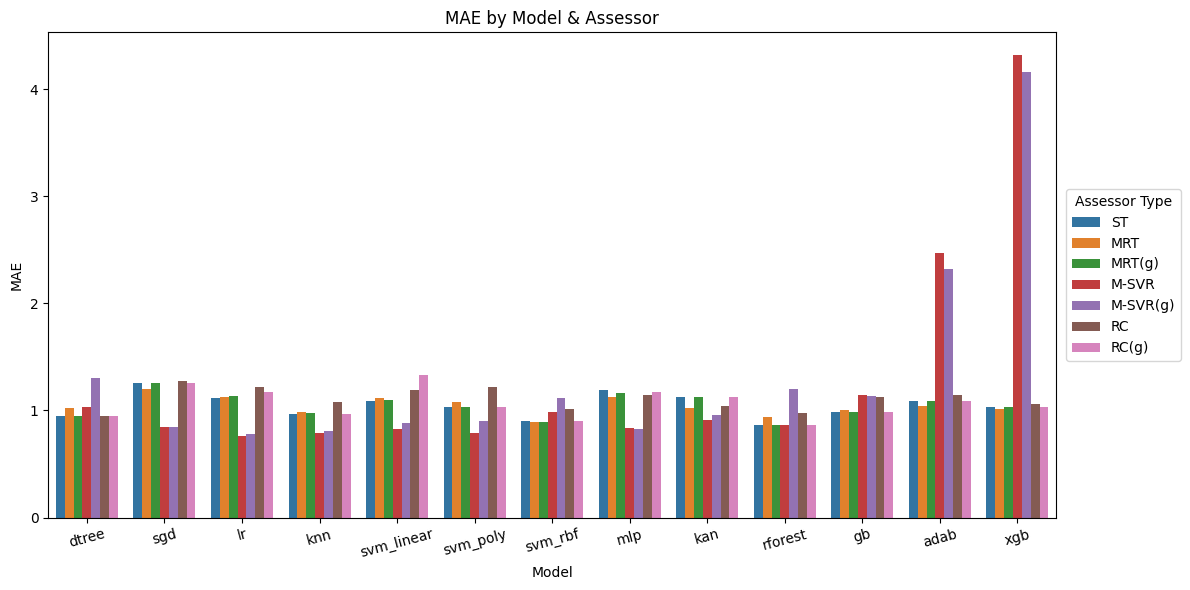

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


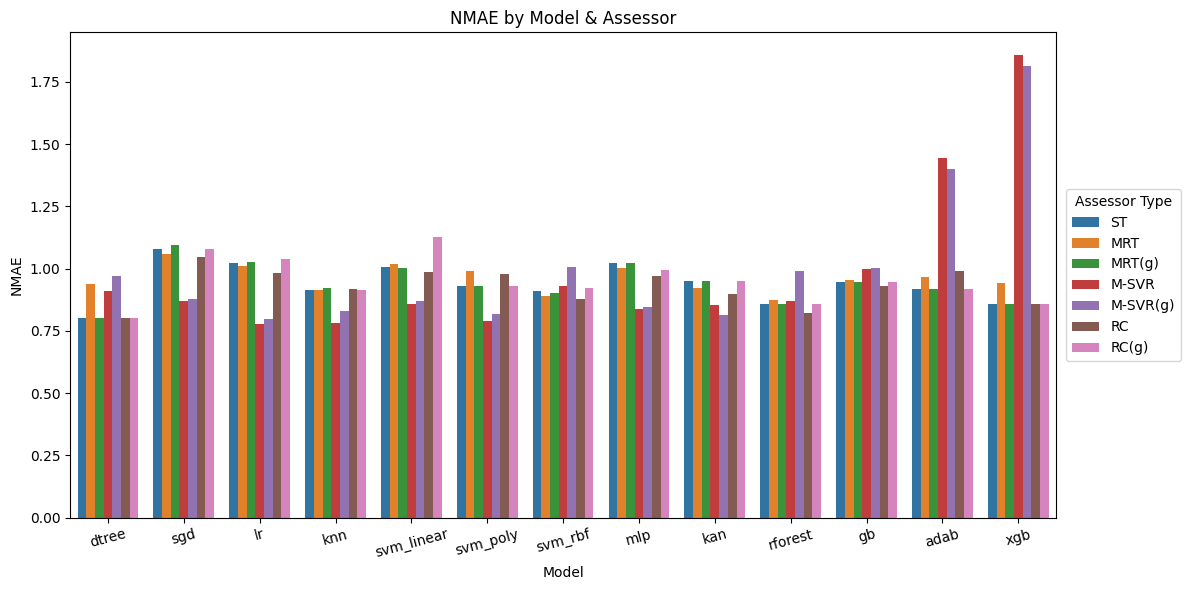

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


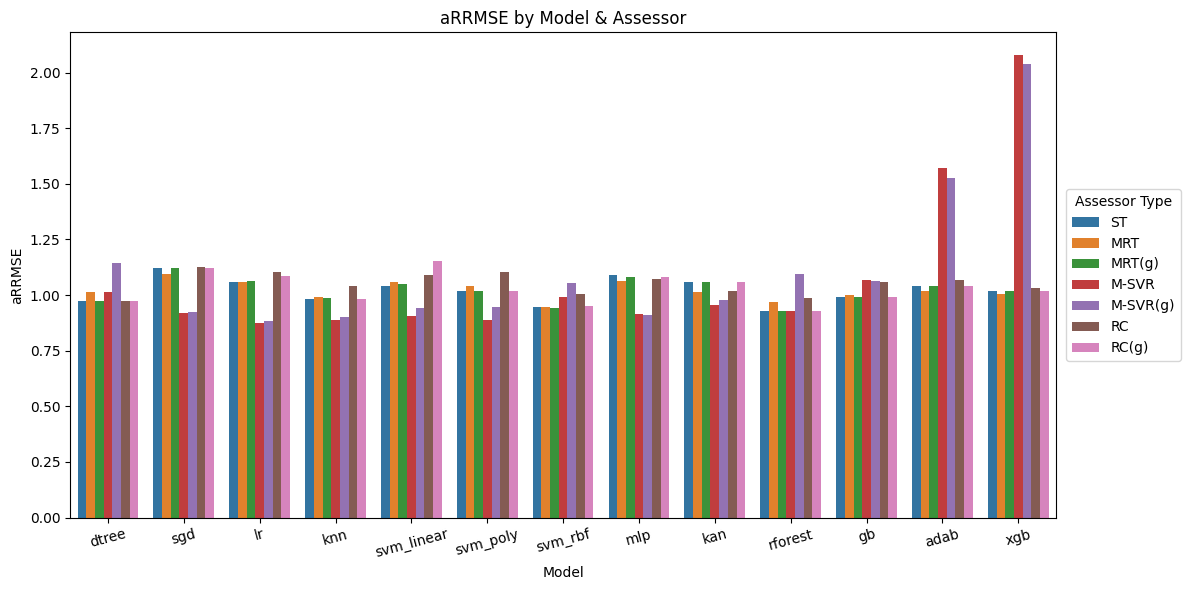

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


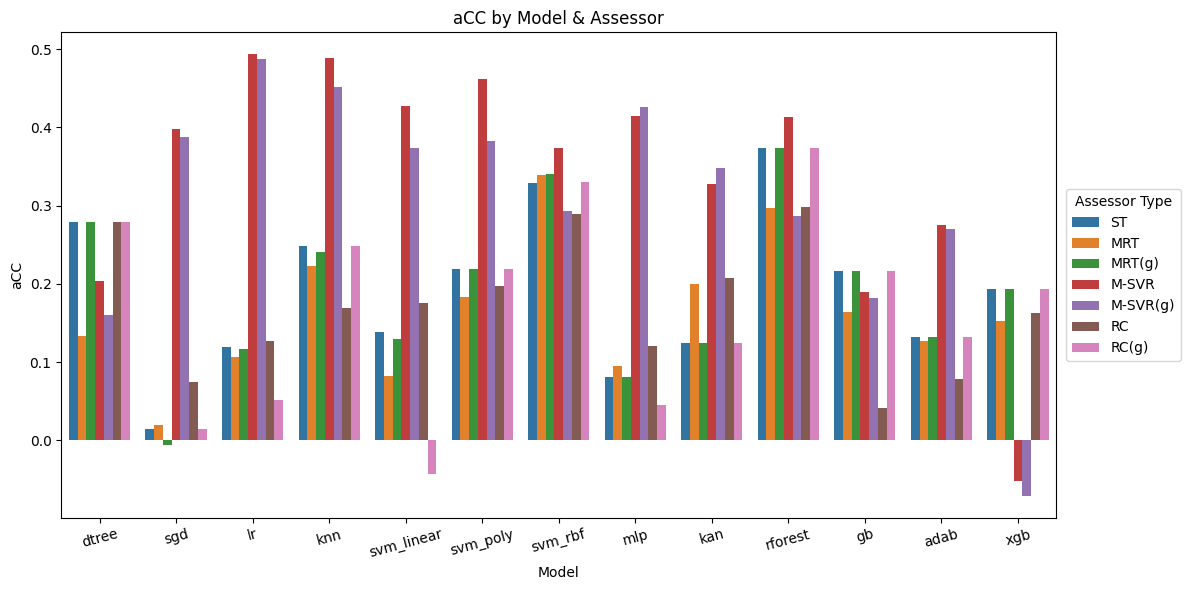

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [57]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=results_df, x='Model', y=mt, hue='Assessor', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)

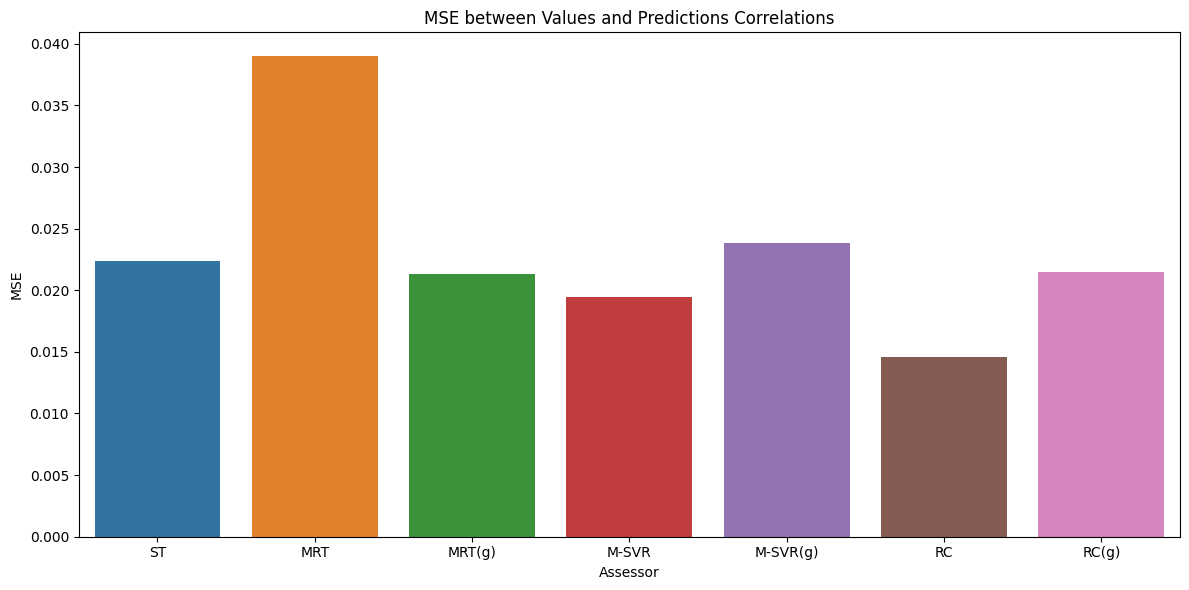

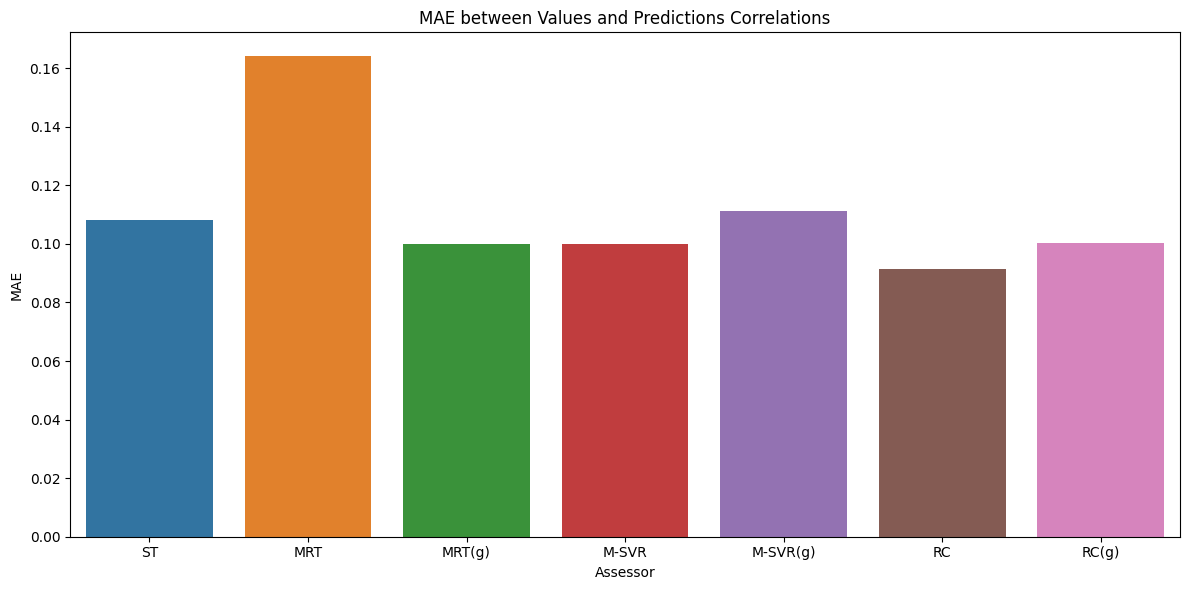

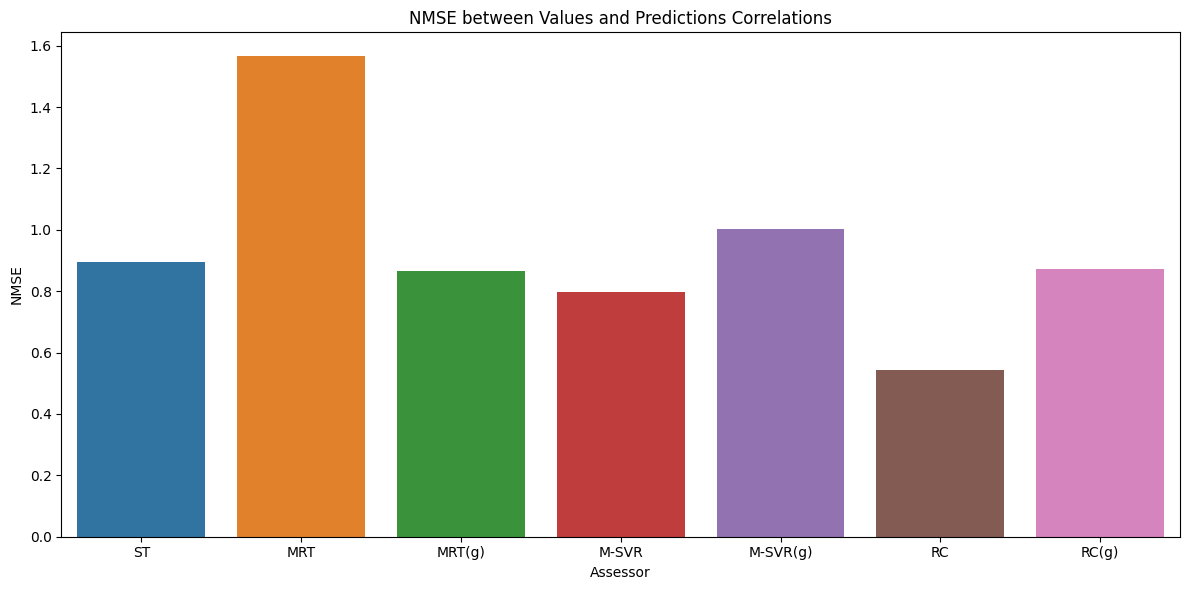

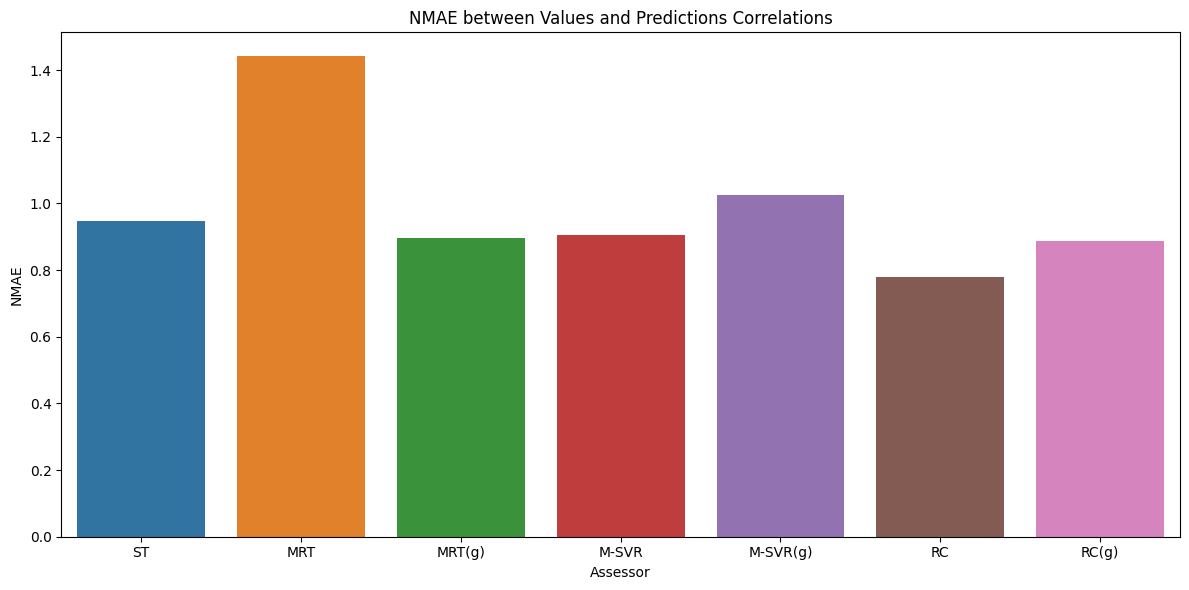

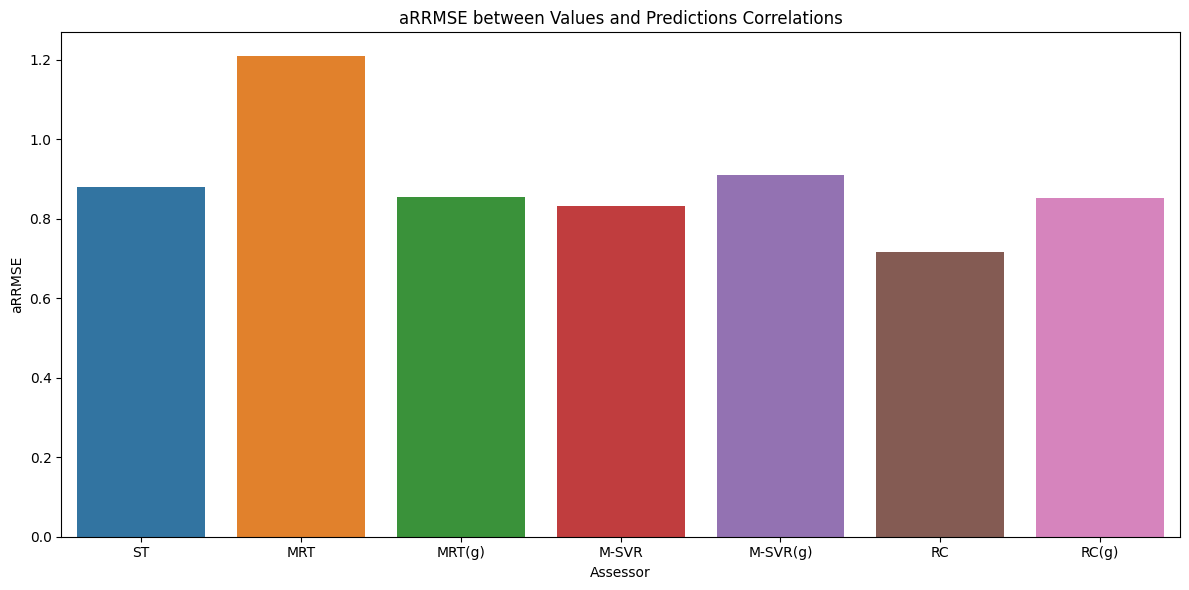

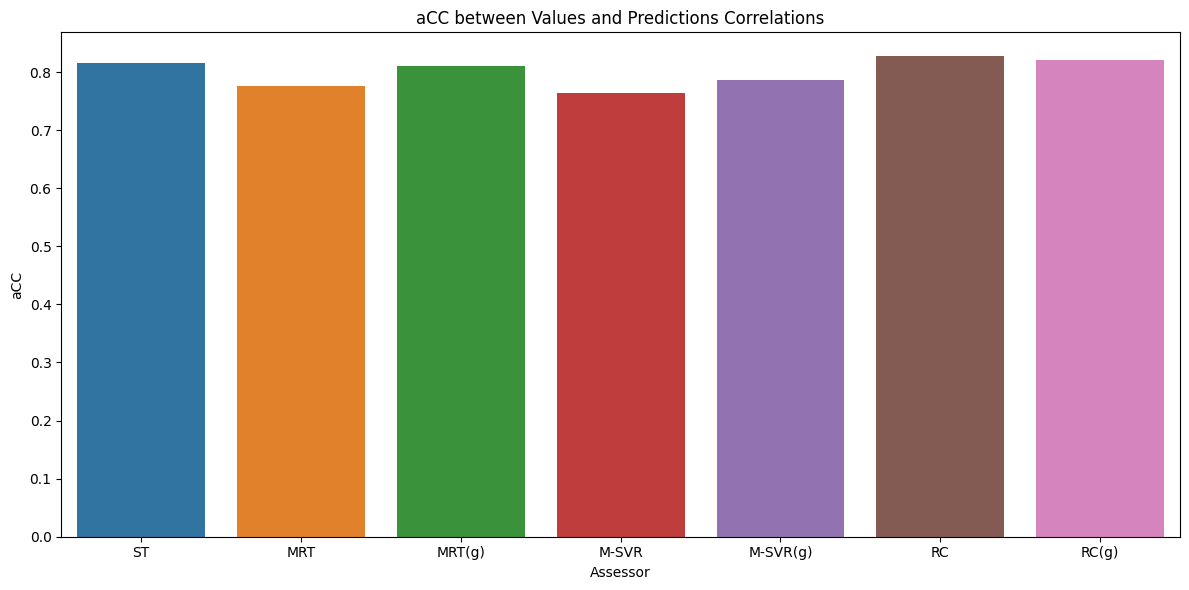

In [58]:
for mt in diff_metrics.columns:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=diff_results.loc[:,['Assessor', mt]], x='Assessor', y=mt, hue='Assessor', palette=class_palette)
    plt.title(f"{mt} between Values and Predictions Correlations")
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bardiff_{mt.lower()}.eps', format='eps', dpi=300)